In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from tqdm import tqdm
import wandb

# Import our custom modules
from dataloader import setup_pokemon_data
#from models.poke_gan import PokemonGAN
from models.poke_fastgan import FastPokemonGAN

wandb.init(
    project="pokemon-gan",
    config={
        "latent_dim": 100,
        "learning_rate": 0.0002,
        "batch_size": 128,
        "num_epochs": 200,
        "image_size": 64,
        "beta1": 0.5,
        "beta2": 0.999
    }
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for samples
os.makedirs('outputs', exist_ok=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: elianaive (elianaive-research). Use `wandb login --relogin` to force relogin


Invalid image detected: data\pokemon\10160.png
Invalid image detected: data\pokemon\10186.png
Invalid image detected: data\pokemon\678.png
Invalid image detected: data\pokemon\869-caramel-swirl-berry-sweet.png
Invalid image detected: data\pokemon\869-caramel-swirl-clover-sweet.png
Invalid image detected: data\pokemon\869-caramel-swirl-flower-sweet.png
Invalid image detected: data\pokemon\869-caramel-swirl-love-sweet.png
Invalid image detected: data\pokemon\869-caramel-swirl-ribbon-sweet.png
Invalid image detected: data\pokemon\869-caramel-swirl-star-sweet.png
Invalid image detected: data\pokemon\869-caramel-swirl-strawberry-sweet.png
Invalid image detected: data\pokemon\869-lemon-cream-berry-sweet.png
Invalid image detected: data\pokemon\869-lemon-cream-clover-sweet.png
Invalid image detected: data\pokemon\869-lemon-cream-flower-sweet.png
Invalid image detected: data\pokemon\869-lemon-cream-love-sweet.png
Invalid image detected: data\pokemon\869-lemon-cream-ribbon-sweet.png
Invalid ima

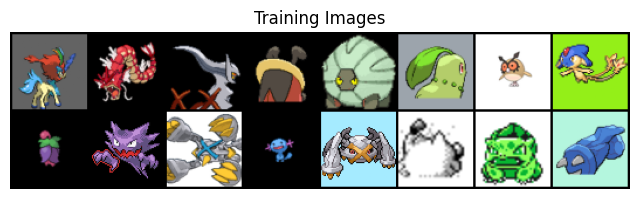

In [2]:
batch_size = wandb.config.batch_size
dataloader = setup_pokemon_data(
    data_dir='data/pokemon',
    batch_size=batch_size,
    image_size=wandb.config.image_size,
    num_workers=4
)

# Preview a batch
real_batch = next(iter(dataloader))[0]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

gan = FastPokemonGAN(
    latent_dim=100,
    lr_g=0.00003,
    lr_d=0.0002,
    n_critic=5,    # Train critic 5 times for each generator update
    clip_value=0.01
)

Using device: cuda


In [4]:
fixed_noise = torch.randn(64, wandb.config.latent_dim, device=device)
for epoch in tqdm(range(wandb.config.num_epochs)):
    epoch_g_loss = 0
    epoch_d_loss = 0
    epoch_gp = 0  # Track gradient penalty
    epoch_w_dist = 0  # Track Wasserstein distance
    
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        losses = gan.train_step(imgs)
        
        # Log batch losses to wandb
        wandb.log({
            "batch_g_loss": losses['g_loss'],
            "batch_d_loss": losses['d_loss'],
            "batch_gradient_penalty": losses['gradient_penalty'],
            "batch_wasserstein_distance": -losses['d_loss'],  # Negative critic loss is W-distance
            "batch": epoch * len(dataloader) + i
        })
        
        epoch_g_loss += losses['g_loss']
        epoch_d_loss += losses['d_loss']
        epoch_gp += losses['gradient_penalty']
        epoch_w_dist += -losses['d_loss']  # Track Wasserstein distance
        
        if i % 50 == 0:
            print(
                f"[Epoch {epoch}/{wandb.config.num_epochs}] "
                f"[Batch {i}/{len(dataloader)}] "
                f"[D loss: {losses['d_loss']:.4f}] "
                f"[G loss: {losses['g_loss']:.4f}] "
                f"[GP: {losses['gradient_penalty']:.4f}] "
                f"[W-dist: {-losses['d_loss']:.4f}]"
            )
    
    # Calculate and log average epoch losses
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_gp = epoch_gp / len(dataloader)
    avg_w_dist = epoch_w_dist / len(dataloader)
    
    wandb.log({
        "epoch": epoch,
        "avg_g_loss": avg_g_loss,
        "avg_d_loss": avg_d_loss,
        "avg_gradient_penalty": avg_gp,
        "avg_wasserstein_distance": avg_w_dist,
    })
    
    # Generate and log sample images every 10 epochs
    if epoch % 10 == 0:
        gan.generator.eval()
        with torch.no_grad():
            fake = gan.generator(fixed_noise).detach().cpu()
            # Save locally
            save_image(fake[:16], f"outputs/pokemon_{epoch}.png", nrow=4, normalize=True)
            
            # Log to wandb
            images = wandb.Image(
                make_grid(fake[:16], nrow=4, normalize=True).cpu(),
                caption=f"Generated Pokemon - Epoch {epoch}"
            )
            wandb.log({"generated_samples": images})
        gan.generator.train()
    
    # Save model checkpoints every 50 epochs
    if epoch % 50 == 0:
        checkpoint_path = f'outputs/pokemon_gan_checkpoint_{epoch}.pt'
        torch.save({
            'generator_state_dict': gan.generator.state_dict(),
            'discriminator_state_dict': gan.discriminator.state_dict(),
            'g_optimizer_state_dict': gan.optimizer_G.state_dict(),
            'd_optimizer_state_dict': gan.optimizer_D.state_dict(),
            'epoch': epoch,
        }, checkpoint_path)
        
        # Log checkpoint to wandb
        wandb.save(checkpoint_path)

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 0/200] [Batch 0/413] [D loss: 9.9339] [G loss: -0.0054] [GP: 0.9951] [W-dist: -9.9339]
[Epoch 0/200] [Batch 50/413] [D loss: 9.3922] [G loss: -0.0040] [GP: 0.9430] [W-dist: -9.3922]
[Epoch 0/200] [Batch 100/413] [D loss: 6.9888] [G loss: -0.0640] [GP: 0.7039] [W-dist: -6.9888]
[Epoch 0/200] [Batch 150/413] [D loss: 7.8975] [G loss: -0.0520] [GP: 0.7860] [W-dist: -7.8975]
[Epoch 0/200] [Batch 200/413] [D loss: 5.6258] [G loss: -0.0379] [GP: 0.5738] [W-dist: -5.6258]
[Epoch 0/200] [Batch 250/413] [D loss: 5.4327] [G loss: -0.0284] [GP: 0.5535] [W-dist: -5.4327]
[Epoch 0/200] [Batch 300/413] [D loss: 4.3245] [G loss: 0.0770] [GP: 0.4330] [W-dist: -4.3245]
[Epoch 0/200] [Batch 350/413] [D loss: 2.7854] [G loss: 0.1203] [GP: 0.2785] [W-dist: -2.7854]
[Epoch 0/200] [Batch 400/413] [D loss: 7.7564] [G loss: -0.0299] [GP: 0.7724] [W-dist: -7.7564]


  0%|          | 1/200 [02:52<9:30:37, 172.05s/it]

[Epoch 1/200] [Batch 0/413] [D loss: 3.8898] [G loss: -0.0153] [GP: 0.3928] [W-dist: -3.8898]
[Epoch 1/200] [Batch 50/413] [D loss: 4.5960] [G loss: 0.1314] [GP: 0.4581] [W-dist: -4.5960]
[Epoch 1/200] [Batch 100/413] [D loss: 5.8466] [G loss: -0.0281] [GP: 0.5953] [W-dist: -5.8466]
[Epoch 1/200] [Batch 150/413] [D loss: 6.6699] [G loss: 0.0416] [GP: 0.6805] [W-dist: -6.6699]
[Epoch 1/200] [Batch 200/413] [D loss: 4.1645] [G loss: -0.0339] [GP: 0.4274] [W-dist: -4.1645]
[Epoch 1/200] [Batch 250/413] [D loss: 5.7295] [G loss: 0.0144] [GP: 0.5713] [W-dist: -5.7295]
[Epoch 1/200] [Batch 300/413] [D loss: 4.0914] [G loss: -0.0343] [GP: 0.4179] [W-dist: -4.0914]
[Epoch 1/200] [Batch 350/413] [D loss: 5.9092] [G loss: 0.1412] [GP: 0.5868] [W-dist: -5.9092]
[Epoch 1/200] [Batch 400/413] [D loss: 3.7020] [G loss: -0.0195] [GP: 0.3739] [W-dist: -3.7020]


  1%|          | 2/200 [05:42<9:23:51, 170.86s/it]

[Epoch 2/200] [Batch 0/413] [D loss: 2.2041] [G loss: 0.1275] [GP: 0.2232] [W-dist: -2.2041]
[Epoch 2/200] [Batch 50/413] [D loss: 6.6994] [G loss: 0.0298] [GP: 0.6659] [W-dist: -6.6994]
[Epoch 2/200] [Batch 100/413] [D loss: 6.7585] [G loss: 0.0078] [GP: 0.6893] [W-dist: -6.7585]
[Epoch 2/200] [Batch 150/413] [D loss: 4.6074] [G loss: 0.1406] [GP: 0.4578] [W-dist: -4.6074]
[Epoch 2/200] [Batch 200/413] [D loss: 7.8359] [G loss: -0.0329] [GP: 0.7795] [W-dist: -7.8359]
[Epoch 2/200] [Batch 250/413] [D loss: 3.9100] [G loss: 0.1456] [GP: 0.3889] [W-dist: -3.9100]
[Epoch 2/200] [Batch 300/413] [D loss: 3.1908] [G loss: 0.0030] [GP: 0.3217] [W-dist: -3.1908]
[Epoch 2/200] [Batch 350/413] [D loss: 3.6556] [G loss: 0.1266] [GP: 0.3689] [W-dist: -3.6556]
[Epoch 2/200] [Batch 400/413] [D loss: 4.5239] [G loss: 0.1466] [GP: 0.4509] [W-dist: -4.5239]


  2%|▏         | 3/200 [08:31<9:19:27, 170.39s/it]

[Epoch 3/200] [Batch 0/413] [D loss: 4.1709] [G loss: -0.0332] [GP: 0.4241] [W-dist: -4.1709]
[Epoch 3/200] [Batch 50/413] [D loss: 5.5641] [G loss: 0.0857] [GP: 0.5600] [W-dist: -5.5641]
[Epoch 3/200] [Batch 100/413] [D loss: 3.2795] [G loss: 0.0665] [GP: 0.3334] [W-dist: -3.2795]
[Epoch 3/200] [Batch 150/413] [D loss: 4.2457] [G loss: 0.0263] [GP: 0.4281] [W-dist: -4.2457]
[Epoch 3/200] [Batch 200/413] [D loss: 3.6557] [G loss: -0.0204] [GP: 0.3746] [W-dist: -3.6557]
[Epoch 3/200] [Batch 250/413] [D loss: 1.9053] [G loss: 0.0706] [GP: 0.1935] [W-dist: -1.9053]
[Epoch 3/200] [Batch 300/413] [D loss: 2.3981] [G loss: 0.0179] [GP: 0.2433] [W-dist: -2.3981]
[Epoch 3/200] [Batch 350/413] [D loss: 3.7458] [G loss: 0.0729] [GP: 0.3775] [W-dist: -3.7458]
[Epoch 3/200] [Batch 400/413] [D loss: 3.0217] [G loss: -0.0178] [GP: 0.3056] [W-dist: -3.0217]


  2%|▏         | 4/200 [11:21<9:16:04, 170.23s/it]

[Epoch 4/200] [Batch 0/413] [D loss: 3.5242] [G loss: 0.1151] [GP: 0.3507] [W-dist: -3.5242]
[Epoch 4/200] [Batch 50/413] [D loss: 2.1050] [G loss: 0.0342] [GP: 0.2115] [W-dist: -2.1050]
[Epoch 4/200] [Batch 100/413] [D loss: 3.1884] [G loss: 0.0062] [GP: 0.3288] [W-dist: -3.1884]
[Epoch 4/200] [Batch 150/413] [D loss: 3.7342] [G loss: -0.0386] [GP: 0.3841] [W-dist: -3.7342]
[Epoch 4/200] [Batch 200/413] [D loss: 4.8130] [G loss: -0.0121] [GP: 0.4937] [W-dist: -4.8130]
[Epoch 4/200] [Batch 250/413] [D loss: 2.7826] [G loss: -0.0374] [GP: 0.2876] [W-dist: -2.7826]
[Epoch 4/200] [Batch 300/413] [D loss: 5.5291] [G loss: 0.0289] [GP: 0.5663] [W-dist: -5.5291]
[Epoch 4/200] [Batch 350/413] [D loss: 3.0019] [G loss: 0.0322] [GP: 0.3038] [W-dist: -3.0019]
[Epoch 4/200] [Batch 400/413] [D loss: 4.0874] [G loss: -0.0308] [GP: 0.4202] [W-dist: -4.0874]


  2%|▎         | 5/200 [14:11<9:12:55, 170.13s/it]

[Epoch 5/200] [Batch 0/413] [D loss: 3.1122] [G loss: 0.0352] [GP: 0.3146] [W-dist: -3.1122]
[Epoch 5/200] [Batch 50/413] [D loss: 2.8414] [G loss: 0.0237] [GP: 0.2894] [W-dist: -2.8414]
[Epoch 5/200] [Batch 100/413] [D loss: 1.2826] [G loss: 0.0143] [GP: 0.1361] [W-dist: -1.2826]
[Epoch 5/200] [Batch 150/413] [D loss: 2.7080] [G loss: -0.0174] [GP: 0.2766] [W-dist: -2.7080]
[Epoch 5/200] [Batch 200/413] [D loss: 5.1992] [G loss: 0.0964] [GP: 0.5160] [W-dist: -5.1992]
[Epoch 5/200] [Batch 250/413] [D loss: 2.7685] [G loss: 0.0214] [GP: 0.2834] [W-dist: -2.7685]
[Epoch 5/200] [Batch 300/413] [D loss: 3.6810] [G loss: 0.0132] [GP: 0.3783] [W-dist: -3.6810]
[Epoch 5/200] [Batch 350/413] [D loss: 5.1038] [G loss: 0.0405] [GP: 0.5242] [W-dist: -5.1038]
[Epoch 5/200] [Batch 400/413] [D loss: 2.0760] [G loss: 0.0084] [GP: 0.2115] [W-dist: -2.0760]


  3%|▎         | 6/200 [17:01<9:09:52, 170.07s/it]

[Epoch 6/200] [Batch 0/413] [D loss: 6.5218] [G loss: -0.0213] [GP: 0.6492] [W-dist: -6.5218]
[Epoch 6/200] [Batch 50/413] [D loss: 3.8636] [G loss: -0.0243] [GP: 0.3998] [W-dist: -3.8636]
[Epoch 6/200] [Batch 100/413] [D loss: 2.4963] [G loss: 0.0208] [GP: 0.2577] [W-dist: -2.4963]
[Epoch 6/200] [Batch 150/413] [D loss: 3.0670] [G loss: -0.0127] [GP: 0.3146] [W-dist: -3.0670]
[Epoch 6/200] [Batch 200/413] [D loss: 4.0482] [G loss: 0.1122] [GP: 0.4026] [W-dist: -4.0482]
[Epoch 6/200] [Batch 250/413] [D loss: 3.4592] [G loss: -0.0166] [GP: 0.3562] [W-dist: -3.4592]
[Epoch 6/200] [Batch 300/413] [D loss: 1.3903] [G loss: -0.0187] [GP: 0.1473] [W-dist: -1.3903]
[Epoch 6/200] [Batch 350/413] [D loss: 3.1557] [G loss: 0.1249] [GP: 0.3146] [W-dist: -3.1557]
[Epoch 6/200] [Batch 400/413] [D loss: 1.4514] [G loss: 0.0521] [GP: 0.1449] [W-dist: -1.4514]


  4%|▎         | 7/200 [19:51<9:06:48, 169.99s/it]

[Epoch 7/200] [Batch 0/413] [D loss: 4.1658] [G loss: 0.0242] [GP: 0.4225] [W-dist: -4.1658]
[Epoch 7/200] [Batch 50/413] [D loss: 3.3765] [G loss: -0.0263] [GP: 0.3497] [W-dist: -3.3765]
[Epoch 7/200] [Batch 100/413] [D loss: 1.2234] [G loss: -0.0098] [GP: 0.1227] [W-dist: -1.2234]
[Epoch 7/200] [Batch 150/413] [D loss: 4.0286] [G loss: -0.0270] [GP: 0.4149] [W-dist: -4.0286]
[Epoch 7/200] [Batch 200/413] [D loss: 4.6082] [G loss: 0.0060] [GP: 0.4740] [W-dist: -4.6082]
[Epoch 7/200] [Batch 250/413] [D loss: 2.5224] [G loss: 0.0038] [GP: 0.2561] [W-dist: -2.5224]
[Epoch 7/200] [Batch 300/413] [D loss: 2.4754] [G loss: -0.0283] [GP: 0.2496] [W-dist: -2.4754]
[Epoch 7/200] [Batch 350/413] [D loss: 2.1429] [G loss: 0.0097] [GP: 0.2167] [W-dist: -2.1429]
[Epoch 7/200] [Batch 400/413] [D loss: 5.6709] [G loss: 0.0542] [GP: 0.5792] [W-dist: -5.6709]


  4%|▍         | 8/200 [22:41<9:03:47, 169.94s/it]

[Epoch 8/200] [Batch 0/413] [D loss: 3.8305] [G loss: -0.0305] [GP: 0.3947] [W-dist: -3.8305]
[Epoch 8/200] [Batch 50/413] [D loss: 1.4009] [G loss: 0.1248] [GP: 0.1379] [W-dist: -1.4009]
[Epoch 8/200] [Batch 100/413] [D loss: 4.1794] [G loss: -0.0205] [GP: 0.4281] [W-dist: -4.1794]
[Epoch 8/200] [Batch 150/413] [D loss: 4.7826] [G loss: -0.0205] [GP: 0.4881] [W-dist: -4.7826]
[Epoch 8/200] [Batch 200/413] [D loss: 1.1252] [G loss: 0.0252] [GP: 0.1157] [W-dist: -1.1252]
[Epoch 8/200] [Batch 250/413] [D loss: 2.1196] [G loss: -0.0209] [GP: 0.2182] [W-dist: -2.1196]
[Epoch 8/200] [Batch 300/413] [D loss: 3.8094] [G loss: -0.0261] [GP: 0.3907] [W-dist: -3.8094]
[Epoch 8/200] [Batch 350/413] [D loss: 1.6939] [G loss: -0.0003] [GP: 0.1674] [W-dist: -1.6939]
[Epoch 8/200] [Batch 400/413] [D loss: 4.7977] [G loss: 0.0253] [GP: 0.4757] [W-dist: -4.7977]


  4%|▍         | 9/200 [25:31<9:00:55, 169.92s/it]

[Epoch 9/200] [Batch 0/413] [D loss: 3.8035] [G loss: -0.0385] [GP: 0.3912] [W-dist: -3.8035]
[Epoch 9/200] [Batch 50/413] [D loss: 6.8962] [G loss: 0.0979] [GP: 0.7004] [W-dist: -6.8962]
[Epoch 9/200] [Batch 100/413] [D loss: 5.0651] [G loss: 0.0874] [GP: 0.5002] [W-dist: -5.0651]
[Epoch 9/200] [Batch 150/413] [D loss: 4.6538] [G loss: 0.1126] [GP: 0.4601] [W-dist: -4.6538]
[Epoch 9/200] [Batch 200/413] [D loss: 4.1152] [G loss: -0.0298] [GP: 0.4219] [W-dist: -4.1152]
[Epoch 9/200] [Batch 250/413] [D loss: 4.5627] [G loss: 0.1138] [GP: 0.4507] [W-dist: -4.5627]
[Epoch 9/200] [Batch 300/413] [D loss: 2.3269] [G loss: -0.0356] [GP: 0.2409] [W-dist: -2.3269]
[Epoch 9/200] [Batch 350/413] [D loss: 6.6971] [G loss: 0.0164] [GP: 0.6634] [W-dist: -6.6971]
[Epoch 9/200] [Batch 400/413] [D loss: 3.0459] [G loss: 0.1196] [GP: 0.3000] [W-dist: -3.0459]


  5%|▌         | 10/200 [28:21<8:57:55, 169.87s/it]

[Epoch 10/200] [Batch 0/413] [D loss: 4.4213] [G loss: -0.0311] [GP: 0.4509] [W-dist: -4.4213]
[Epoch 10/200] [Batch 50/413] [D loss: 2.2902] [G loss: -0.0307] [GP: 0.2355] [W-dist: -2.2902]
[Epoch 10/200] [Batch 100/413] [D loss: 1.6004] [G loss: 0.0474] [GP: 0.1595] [W-dist: -1.6004]
[Epoch 10/200] [Batch 150/413] [D loss: 2.2804] [G loss: 0.1367] [GP: 0.2230] [W-dist: -2.2804]
[Epoch 10/200] [Batch 200/413] [D loss: 2.3086] [G loss: -0.0409] [GP: 0.2392] [W-dist: -2.3086]
[Epoch 10/200] [Batch 250/413] [D loss: 4.8934] [G loss: -0.0161] [GP: 0.4983] [W-dist: -4.8934]
[Epoch 10/200] [Batch 300/413] [D loss: 3.0920] [G loss: -0.0224] [GP: 0.3128] [W-dist: -3.0920]
[Epoch 10/200] [Batch 350/413] [D loss: 1.6792] [G loss: 0.1128] [GP: 0.1635] [W-dist: -1.6792]
[Epoch 10/200] [Batch 400/413] [D loss: 3.0486] [G loss: -0.0259] [GP: 0.3104] [W-dist: -3.0486]


  6%|▌         | 11/200 [31:11<8:55:08, 169.88s/it]

[Epoch 11/200] [Batch 0/413] [D loss: 7.2550] [G loss: 0.1224] [GP: 0.7352] [W-dist: -7.2550]
[Epoch 11/200] [Batch 50/413] [D loss: 1.6852] [G loss: 0.0329] [GP: 0.1692] [W-dist: -1.6852]
[Epoch 11/200] [Batch 100/413] [D loss: 6.1657] [G loss: -0.0314] [GP: 0.6109] [W-dist: -6.1657]
[Epoch 11/200] [Batch 150/413] [D loss: 1.9685] [G loss: 0.1332] [GP: 0.1920] [W-dist: -1.9685]
[Epoch 11/200] [Batch 200/413] [D loss: 4.5056] [G loss: 0.0820] [GP: 0.4466] [W-dist: -4.5056]
[Epoch 11/200] [Batch 250/413] [D loss: 3.8286] [G loss: 0.1344] [GP: 0.3786] [W-dist: -3.8286]
[Epoch 11/200] [Batch 300/413] [D loss: 5.6000] [G loss: 0.0682] [GP: 0.5709] [W-dist: -5.6000]
[Epoch 11/200] [Batch 350/413] [D loss: 4.9830] [G loss: 0.0086] [GP: 0.5086] [W-dist: -4.9830]
[Epoch 11/200] [Batch 400/413] [D loss: 2.5913] [G loss: 0.1318] [GP: 0.2560] [W-dist: -2.5913]


  6%|▌         | 12/200 [34:00<8:52:05, 169.82s/it]

[Epoch 12/200] [Batch 0/413] [D loss: 1.2222] [G loss: 0.1423] [GP: 0.1207] [W-dist: -1.2222]
[Epoch 12/200] [Batch 50/413] [D loss: 1.8294] [G loss: 0.0949] [GP: 0.1828] [W-dist: -1.8294]
[Epoch 12/200] [Batch 100/413] [D loss: 4.6262] [G loss: -0.0144] [GP: 0.4727] [W-dist: -4.6262]
[Epoch 12/200] [Batch 150/413] [D loss: 0.6210] [G loss: 0.0749] [GP: 0.0641] [W-dist: -0.6210]
[Epoch 12/200] [Batch 200/413] [D loss: 5.0417] [G loss: -0.0075] [GP: 0.5002] [W-dist: -5.0417]
[Epoch 12/200] [Batch 250/413] [D loss: 1.9240] [G loss: 0.0809] [GP: 0.1954] [W-dist: -1.9240]
[Epoch 12/200] [Batch 300/413] [D loss: 2.4007] [G loss: 0.1375] [GP: 0.2389] [W-dist: -2.4007]
[Epoch 12/200] [Batch 350/413] [D loss: 4.7738] [G loss: -0.0027] [GP: 0.4727] [W-dist: -4.7738]
[Epoch 12/200] [Batch 400/413] [D loss: 2.6915] [G loss: 0.0841] [GP: 0.2691] [W-dist: -2.6915]


  6%|▋         | 13/200 [36:47<8:46:33, 168.95s/it]

[Epoch 13/200] [Batch 0/413] [D loss: 0.8115] [G loss: 0.1053] [GP: 0.0838] [W-dist: -0.8115]
[Epoch 13/200] [Batch 50/413] [D loss: 5.6167] [G loss: 0.0531] [GP: 0.5737] [W-dist: -5.6167]
[Epoch 13/200] [Batch 100/413] [D loss: 2.4344] [G loss: 0.0306] [GP: 0.2463] [W-dist: -2.4344]
[Epoch 13/200] [Batch 150/413] [D loss: 5.0368] [G loss: 0.1000] [GP: 0.5164] [W-dist: -5.0368]
[Epoch 13/200] [Batch 200/413] [D loss: 0.6094] [G loss: 0.0519] [GP: 0.0631] [W-dist: -0.6094]
[Epoch 13/200] [Batch 250/413] [D loss: 2.2494] [G loss: 0.0531] [GP: 0.2290] [W-dist: -2.2494]
[Epoch 13/200] [Batch 300/413] [D loss: 0.7380] [G loss: 0.1107] [GP: 0.0808] [W-dist: -0.7380]
[Epoch 13/200] [Batch 350/413] [D loss: 2.7320] [G loss: 0.1343] [GP: 0.2717] [W-dist: -2.7320]
[Epoch 13/200] [Batch 400/413] [D loss: 2.2361] [G loss: 0.1459] [GP: 0.2219] [W-dist: -2.2361]


  7%|▋         | 14/200 [39:35<8:42:17, 168.48s/it]

[Epoch 14/200] [Batch 0/413] [D loss: 4.5655] [G loss: -0.0033] [GP: 0.4524] [W-dist: -4.5655]
[Epoch 14/200] [Batch 50/413] [D loss: 0.9257] [G loss: -0.0285] [GP: 0.1010] [W-dist: -0.9257]
[Epoch 14/200] [Batch 100/413] [D loss: 3.3018] [G loss: 0.0000] [GP: 0.3397] [W-dist: -3.3018]
[Epoch 14/200] [Batch 150/413] [D loss: 3.3483] [G loss: 0.1044] [GP: 0.3318] [W-dist: -3.3483]
[Epoch 14/200] [Batch 200/413] [D loss: 4.1365] [G loss: 0.0555] [GP: 0.4099] [W-dist: -4.1365]
[Epoch 14/200] [Batch 250/413] [D loss: 2.7556] [G loss: 0.1309] [GP: 0.2740] [W-dist: -2.7556]
[Epoch 14/200] [Batch 300/413] [D loss: 4.7958] [G loss: -0.0313] [GP: 0.4911] [W-dist: -4.7958]
[Epoch 14/200] [Batch 350/413] [D loss: 1.1151] [G loss: 0.0057] [GP: 0.1215] [W-dist: -1.1151]
[Epoch 14/200] [Batch 400/413] [D loss: 3.5458] [G loss: 0.0959] [GP: 0.3528] [W-dist: -3.5458]


  8%|▊         | 15/200 [42:22<8:38:25, 168.14s/it]

[Epoch 15/200] [Batch 0/413] [D loss: 1.3361] [G loss: -0.0187] [GP: 0.1421] [W-dist: -1.3361]
[Epoch 15/200] [Batch 50/413] [D loss: 2.6541] [G loss: 0.0049] [GP: 0.2708] [W-dist: -2.6541]
[Epoch 15/200] [Batch 100/413] [D loss: 2.6166] [G loss: 0.1209] [GP: 0.2600] [W-dist: -2.6166]
[Epoch 15/200] [Batch 150/413] [D loss: 0.8116] [G loss: 0.0534] [GP: 0.0856] [W-dist: -0.8116]
[Epoch 15/200] [Batch 200/413] [D loss: 2.4760] [G loss: -0.0025] [GP: 0.2538] [W-dist: -2.4760]
[Epoch 15/200] [Batch 250/413] [D loss: 1.6516] [G loss: -0.0333] [GP: 0.1765] [W-dist: -1.6516]
[Epoch 15/200] [Batch 300/413] [D loss: 2.9911] [G loss: -0.0071] [GP: 0.3087] [W-dist: -2.9911]
[Epoch 15/200] [Batch 350/413] [D loss: 4.2857] [G loss: -0.0056] [GP: 0.4422] [W-dist: -4.2857]
[Epoch 15/200] [Batch 400/413] [D loss: 5.1929] [G loss: -0.0212] [GP: 0.5157] [W-dist: -5.1929]


  8%|▊         | 16/200 [45:09<8:34:48, 167.87s/it]

[Epoch 16/200] [Batch 0/413] [D loss: 3.4270] [G loss: -0.0135] [GP: 0.3551] [W-dist: -3.4270]
[Epoch 16/200] [Batch 50/413] [D loss: 3.9981] [G loss: 0.0734] [GP: 0.3988] [W-dist: -3.9981]
[Epoch 16/200] [Batch 100/413] [D loss: 3.2202] [G loss: 0.1100] [GP: 0.3184] [W-dist: -3.2202]
[Epoch 16/200] [Batch 150/413] [D loss: 3.5396] [G loss: -0.0270] [GP: 0.3670] [W-dist: -3.5396]
[Epoch 16/200] [Batch 200/413] [D loss: 2.8698] [G loss: 0.0912] [GP: 0.2855] [W-dist: -2.8698]
[Epoch 16/200] [Batch 250/413] [D loss: 0.6672] [G loss: 0.0632] [GP: 0.0710] [W-dist: -0.6672]
[Epoch 16/200] [Batch 300/413] [D loss: 1.8318] [G loss: 0.1018] [GP: 0.1836] [W-dist: -1.8318]
[Epoch 16/200] [Batch 350/413] [D loss: 1.9860] [G loss: 0.1386] [GP: 0.1958] [W-dist: -1.9860]
[Epoch 16/200] [Batch 400/413] [D loss: 2.3081] [G loss: 0.1321] [GP: 0.2275] [W-dist: -2.3081]


  8%|▊         | 17/200 [47:57<8:31:34, 167.73s/it]

[Epoch 17/200] [Batch 0/413] [D loss: 3.5040] [G loss: 0.0762] [GP: 0.3473] [W-dist: -3.5040]
[Epoch 17/200] [Batch 50/413] [D loss: 2.1611] [G loss: 0.0993] [GP: 0.2149] [W-dist: -2.1611]
[Epoch 17/200] [Batch 100/413] [D loss: 0.9590] [G loss: 0.0385] [GP: 0.0989] [W-dist: -0.9590]
[Epoch 17/200] [Batch 150/413] [D loss: 3.0089] [G loss: -0.0262] [GP: 0.3117] [W-dist: -3.0089]
[Epoch 17/200] [Batch 200/413] [D loss: 3.4504] [G loss: 0.0618] [GP: 0.3401] [W-dist: -3.4504]
[Epoch 17/200] [Batch 250/413] [D loss: 3.2262] [G loss: 0.0917] [GP: 0.3178] [W-dist: -3.2262]
[Epoch 17/200] [Batch 300/413] [D loss: 1.4801] [G loss: 0.0030] [GP: 0.1543] [W-dist: -1.4801]
[Epoch 17/200] [Batch 350/413] [D loss: 0.9928] [G loss: 0.1290] [GP: 0.0985] [W-dist: -0.9928]
[Epoch 17/200] [Batch 400/413] [D loss: 0.5531] [G loss: 0.0726] [GP: 0.0569] [W-dist: -0.5531]


  9%|▉         | 18/200 [50:44<8:28:28, 167.63s/it]

[Epoch 18/200] [Batch 0/413] [D loss: 2.8469] [G loss: 0.1154] [GP: 0.2806] [W-dist: -2.8469]
[Epoch 18/200] [Batch 50/413] [D loss: 3.8911] [G loss: 0.0328] [GP: 0.4005] [W-dist: -3.8911]
[Epoch 18/200] [Batch 100/413] [D loss: 2.1993] [G loss: 0.0909] [GP: 0.2202] [W-dist: -2.1993]
[Epoch 18/200] [Batch 150/413] [D loss: 0.6387] [G loss: 0.0727] [GP: 0.0653] [W-dist: -0.6387]
[Epoch 18/200] [Batch 200/413] [D loss: 2.9518] [G loss: 0.1129] [GP: 0.2936] [W-dist: -2.9518]
[Epoch 18/200] [Batch 250/413] [D loss: 2.8347] [G loss: 0.0992] [GP: 0.2814] [W-dist: -2.8347]
[Epoch 18/200] [Batch 300/413] [D loss: 1.0754] [G loss: 0.1179] [GP: 0.1071] [W-dist: -1.0754]
[Epoch 18/200] [Batch 350/413] [D loss: 1.3002] [G loss: 0.0080] [GP: 0.1371] [W-dist: -1.3002]
[Epoch 18/200] [Batch 400/413] [D loss: 0.9294] [G loss: -0.0109] [GP: 0.0992] [W-dist: -0.9294]


 10%|▉         | 19/200 [53:32<8:25:52, 167.69s/it]

[Epoch 19/200] [Batch 0/413] [D loss: 3.4921] [G loss: 0.0977] [GP: 0.3455] [W-dist: -3.4921]
[Epoch 19/200] [Batch 50/413] [D loss: 0.6456] [G loss: 0.0632] [GP: 0.0669] [W-dist: -0.6456]
[Epoch 19/200] [Batch 100/413] [D loss: 0.6070] [G loss: 0.0121] [GP: 0.0634] [W-dist: -0.6070]
[Epoch 19/200] [Batch 150/413] [D loss: 0.7333] [G loss: -0.0148] [GP: 0.0772] [W-dist: -0.7333]
[Epoch 19/200] [Batch 200/413] [D loss: 2.5873] [G loss: 0.1361] [GP: 0.2573] [W-dist: -2.5873]
[Epoch 19/200] [Batch 250/413] [D loss: 3.8092] [G loss: 0.0521] [GP: 0.3768] [W-dist: -3.8092]
[Epoch 19/200] [Batch 300/413] [D loss: 2.0852] [G loss: 0.1283] [GP: 0.2037] [W-dist: -2.0852]
[Epoch 19/200] [Batch 350/413] [D loss: 1.0280] [G loss: -0.0007] [GP: 0.1118] [W-dist: -1.0280]
[Epoch 19/200] [Batch 400/413] [D loss: 5.0091] [G loss: -0.0035] [GP: 0.4965] [W-dist: -5.0091]


 10%|█         | 20/200 [56:20<8:23:07, 167.71s/it]

[Epoch 20/200] [Batch 0/413] [D loss: 2.7788] [G loss: 0.0872] [GP: 0.2740] [W-dist: -2.7788]
[Epoch 20/200] [Batch 50/413] [D loss: 2.6996] [G loss: 0.1166] [GP: 0.2671] [W-dist: -2.6996]
[Epoch 20/200] [Batch 100/413] [D loss: 2.2091] [G loss: 0.1122] [GP: 0.2211] [W-dist: -2.2091]
[Epoch 20/200] [Batch 150/413] [D loss: 0.7622] [G loss: 0.1267] [GP: 0.0778] [W-dist: -0.7622]
[Epoch 20/200] [Batch 200/413] [D loss: 4.5718] [G loss: 0.0205] [GP: 0.4519] [W-dist: -4.5718]
[Epoch 20/200] [Batch 250/413] [D loss: 4.6553] [G loss: 0.0469] [GP: 0.4606] [W-dist: -4.6553]
[Epoch 20/200] [Batch 300/413] [D loss: 0.7894] [G loss: 0.0012] [GP: 0.0861] [W-dist: -0.7894]
[Epoch 20/200] [Batch 350/413] [D loss: 4.4456] [G loss: 0.0504] [GP: 0.4407] [W-dist: -4.4456]
[Epoch 20/200] [Batch 400/413] [D loss: 0.9309] [G loss: 0.1319] [GP: 0.0935] [W-dist: -0.9309]


 10%|█         | 21/200 [59:07<8:20:16, 167.69s/it]

[Epoch 21/200] [Batch 0/413] [D loss: 1.9198] [G loss: 0.0109] [GP: 0.1944] [W-dist: -1.9198]
[Epoch 21/200] [Batch 50/413] [D loss: 1.0258] [G loss: 0.1310] [GP: 0.1018] [W-dist: -1.0258]
[Epoch 21/200] [Batch 100/413] [D loss: 0.6728] [G loss: -0.0113] [GP: 0.0712] [W-dist: -0.6728]
[Epoch 21/200] [Batch 150/413] [D loss: 0.6513] [G loss: 0.0958] [GP: 0.0672] [W-dist: -0.6513]
[Epoch 21/200] [Batch 200/413] [D loss: 5.3670] [G loss: -0.0104] [GP: 0.5316] [W-dist: -5.3670]
[Epoch 21/200] [Batch 250/413] [D loss: 0.6961] [G loss: 0.0235] [GP: 0.0692] [W-dist: -0.6961]
[Epoch 21/200] [Batch 300/413] [D loss: 4.8810] [G loss: 0.0248] [GP: 0.4828] [W-dist: -4.8810]
[Epoch 21/200] [Batch 350/413] [D loss: 1.9748] [G loss: 0.0611] [GP: 0.1975] [W-dist: -1.9748]
[Epoch 21/200] [Batch 400/413] [D loss: 1.5336] [G loss: 0.0254] [GP: 0.1563] [W-dist: -1.5336]


 11%|█         | 22/200 [1:01:55<8:17:21, 167.65s/it]

[Epoch 22/200] [Batch 0/413] [D loss: 2.4382] [G loss: 0.1024] [GP: 0.2412] [W-dist: -2.4382]
[Epoch 22/200] [Batch 50/413] [D loss: 1.3364] [G loss: 0.1480] [GP: 0.1310] [W-dist: -1.3364]
[Epoch 22/200] [Batch 100/413] [D loss: 0.8489] [G loss: 0.0351] [GP: 0.0899] [W-dist: -0.8489]
[Epoch 22/200] [Batch 150/413] [D loss: 4.8976] [G loss: 0.0440] [GP: 0.5014] [W-dist: -4.8976]
[Epoch 22/200] [Batch 200/413] [D loss: 1.5599] [G loss: 0.1417] [GP: 0.1546] [W-dist: -1.5599]
[Epoch 22/200] [Batch 250/413] [D loss: 3.3845] [G loss: -0.0103] [GP: 0.3491] [W-dist: -3.3845]
[Epoch 22/200] [Batch 300/413] [D loss: 1.8115] [G loss: 0.0594] [GP: 0.1850] [W-dist: -1.8115]
[Epoch 22/200] [Batch 350/413] [D loss: 2.6597] [G loss: -0.0067] [GP: 0.2771] [W-dist: -2.6597]
[Epoch 22/200] [Batch 400/413] [D loss: 4.4500] [G loss: -0.0100] [GP: 0.4411] [W-dist: -4.4500]


 12%|█▏        | 23/200 [1:04:42<8:14:09, 167.51s/it]

[Epoch 23/200] [Batch 0/413] [D loss: 3.9216] [G loss: 0.0808] [GP: 0.3886] [W-dist: -3.9216]
[Epoch 23/200] [Batch 50/413] [D loss: 0.6879] [G loss: 0.1363] [GP: 0.0692] [W-dist: -0.6879]
[Epoch 23/200] [Batch 100/413] [D loss: 3.0959] [G loss: 0.0751] [GP: 0.3056] [W-dist: -3.0959]
[Epoch 23/200] [Batch 150/413] [D loss: 4.5562] [G loss: 0.0494] [GP: 0.4517] [W-dist: -4.5562]
[Epoch 23/200] [Batch 200/413] [D loss: 2.7323] [G loss: 0.1263] [GP: 0.2722] [W-dist: -2.7323]
[Epoch 23/200] [Batch 250/413] [D loss: 1.0283] [G loss: 0.0280] [GP: 0.1059] [W-dist: -1.0283]
[Epoch 23/200] [Batch 300/413] [D loss: 4.2849] [G loss: 0.0363] [GP: 0.4399] [W-dist: -4.2849]
[Epoch 23/200] [Batch 350/413] [D loss: 2.9926] [G loss: -0.0059] [GP: 0.3090] [W-dist: -2.9926]
[Epoch 23/200] [Batch 400/413] [D loss: 2.0723] [G loss: 0.0044] [GP: 0.2074] [W-dist: -2.0723]


 12%|█▏        | 24/200 [1:07:29<8:11:10, 167.45s/it]

[Epoch 24/200] [Batch 0/413] [D loss: 4.1779] [G loss: 0.0283] [GP: 0.4139] [W-dist: -4.1779]
[Epoch 24/200] [Batch 50/413] [D loss: 1.6188] [G loss: 0.1158] [GP: 0.1596] [W-dist: -1.6188]
[Epoch 24/200] [Batch 100/413] [D loss: 0.8967] [G loss: 0.1090] [GP: 0.0903] [W-dist: -0.8967]
[Epoch 24/200] [Batch 150/413] [D loss: 3.6096] [G loss: 0.0474] [GP: 0.3580] [W-dist: -3.6096]
[Epoch 24/200] [Batch 200/413] [D loss: 0.7650] [G loss: 0.0030] [GP: 0.0810] [W-dist: -0.7650]
[Epoch 24/200] [Batch 250/413] [D loss: 0.5719] [G loss: 0.0282] [GP: 0.0624] [W-dist: -0.5719]
[Epoch 24/200] [Batch 300/413] [D loss: 2.9191] [G loss: 0.0549] [GP: 0.2880] [W-dist: -2.9191]
[Epoch 24/200] [Batch 350/413] [D loss: 1.6998] [G loss: 0.1467] [GP: 0.1650] [W-dist: -1.6998]
[Epoch 24/200] [Batch 400/413] [D loss: 0.6574] [G loss: 0.0558] [GP: 0.0684] [W-dist: -0.6574]


 12%|█▎        | 25/200 [1:10:17<8:08:44, 167.57s/it]

[Epoch 25/200] [Batch 0/413] [D loss: 0.6608] [G loss: 0.0537] [GP: 0.0669] [W-dist: -0.6608]
[Epoch 25/200] [Batch 50/413] [D loss: 0.8474] [G loss: 0.1295] [GP: 0.0838] [W-dist: -0.8474]
[Epoch 25/200] [Batch 100/413] [D loss: 1.2625] [G loss: -0.0071] [GP: 0.1282] [W-dist: -1.2625]
[Epoch 25/200] [Batch 150/413] [D loss: 5.3914] [G loss: -0.0058] [GP: 0.5346] [W-dist: -5.3914]
[Epoch 25/200] [Batch 200/413] [D loss: 4.3435] [G loss: 0.0192] [GP: 0.4291] [W-dist: -4.3435]
[Epoch 25/200] [Batch 250/413] [D loss: 1.9903] [G loss: 0.1220] [GP: 0.1940] [W-dist: -1.9903]
[Epoch 25/200] [Batch 300/413] [D loss: 5.7058] [G loss: 0.0627] [GP: 0.5800] [W-dist: -5.7058]
[Epoch 25/200] [Batch 350/413] [D loss: 1.7292] [G loss: -0.0183] [GP: 0.1749] [W-dist: -1.7292]
[Epoch 25/200] [Batch 400/413] [D loss: 3.0163] [G loss: 0.1207] [GP: 0.2966] [W-dist: -3.0163]


 13%|█▎        | 26/200 [1:13:04<8:05:34, 167.44s/it]

[Epoch 26/200] [Batch 0/413] [D loss: 4.3004] [G loss: 0.0074] [GP: 0.4247] [W-dist: -4.3004]
[Epoch 26/200] [Batch 50/413] [D loss: 1.4173] [G loss: 0.1360] [GP: 0.1374] [W-dist: -1.4173]
[Epoch 26/200] [Batch 100/413] [D loss: 1.4352] [G loss: 0.0788] [GP: 0.1395] [W-dist: -1.4352]
[Epoch 26/200] [Batch 150/413] [D loss: 1.7441] [G loss: 0.0988] [GP: 0.1688] [W-dist: -1.7441]
[Epoch 26/200] [Batch 200/413] [D loss: 2.0608] [G loss: -0.0108] [GP: 0.2123] [W-dist: -2.0608]
[Epoch 26/200] [Batch 250/413] [D loss: 1.3809] [G loss: 0.0743] [GP: 0.1378] [W-dist: -1.3809]
[Epoch 26/200] [Batch 300/413] [D loss: 2.9356] [G loss: 0.0997] [GP: 0.2880] [W-dist: -2.9356]
[Epoch 26/200] [Batch 350/413] [D loss: 2.4506] [G loss: 0.1052] [GP: 0.2395] [W-dist: -2.4506]
[Epoch 26/200] [Batch 400/413] [D loss: 2.2904] [G loss: 0.1229] [GP: 0.2242] [W-dist: -2.2904]


 14%|█▎        | 27/200 [1:15:51<8:02:18, 167.27s/it]

[Epoch 27/200] [Batch 0/413] [D loss: 1.0028] [G loss: -0.0175] [GP: 0.1011] [W-dist: -1.0028]
[Epoch 27/200] [Batch 50/413] [D loss: 1.2080] [G loss: 0.1300] [GP: 0.1176] [W-dist: -1.2080]
[Epoch 27/200] [Batch 100/413] [D loss: 1.1437] [G loss: -0.0125] [GP: 0.1164] [W-dist: -1.1437]
[Epoch 27/200] [Batch 150/413] [D loss: 3.7522] [G loss: 0.0665] [GP: 0.3695] [W-dist: -3.7522]
[Epoch 27/200] [Batch 200/413] [D loss: 3.4111] [G loss: 0.0986] [GP: 0.3357] [W-dist: -3.4111]
[Epoch 27/200] [Batch 250/413] [D loss: 3.5146] [G loss: 0.1026] [GP: 0.3471] [W-dist: -3.5146]
[Epoch 27/200] [Batch 300/413] [D loss: 3.8186] [G loss: 0.0721] [GP: 0.3760] [W-dist: -3.8186]
[Epoch 27/200] [Batch 350/413] [D loss: 2.1377] [G loss: -0.0196] [GP: 0.2235] [W-dist: -2.1377]
[Epoch 27/200] [Batch 400/413] [D loss: 3.2150] [G loss: 0.0846] [GP: 0.3157] [W-dist: -3.2150]


 14%|█▍        | 28/200 [1:18:38<7:59:29, 167.27s/it]

[Epoch 28/200] [Batch 0/413] [D loss: 0.6379] [G loss: 0.0526] [GP: 0.0635] [W-dist: -0.6379]
[Epoch 28/200] [Batch 50/413] [D loss: 0.9656] [G loss: 0.0808] [GP: 0.0934] [W-dist: -0.9656]
[Epoch 28/200] [Batch 100/413] [D loss: 1.6434] [G loss: 0.1117] [GP: 0.1614] [W-dist: -1.6434]
[Epoch 28/200] [Batch 150/413] [D loss: 4.5018] [G loss: 0.0088] [GP: 0.4448] [W-dist: -4.5018]
[Epoch 28/200] [Batch 200/413] [D loss: 0.5975] [G loss: 0.0029] [GP: 0.0603] [W-dist: -0.5975]
[Epoch 28/200] [Batch 250/413] [D loss: 3.1456] [G loss: 0.0901] [GP: 0.3089] [W-dist: -3.1456]
[Epoch 28/200] [Batch 300/413] [D loss: 1.2282] [G loss: 0.0936] [GP: 0.1192] [W-dist: -1.2282]
[Epoch 28/200] [Batch 350/413] [D loss: 2.0085] [G loss: 0.0091] [GP: 0.2044] [W-dist: -2.0085]
[Epoch 28/200] [Batch 400/413] [D loss: 2.4813] [G loss: -0.0069] [GP: 0.2531] [W-dist: -2.4813]


 14%|█▍        | 29/200 [1:21:26<7:56:47, 167.30s/it]

[Epoch 29/200] [Batch 0/413] [D loss: 1.7263] [G loss: 0.1194] [GP: 0.1691] [W-dist: -1.7263]
[Epoch 29/200] [Batch 50/413] [D loss: 1.4286] [G loss: 0.1365] [GP: 0.1397] [W-dist: -1.4286]
[Epoch 29/200] [Batch 100/413] [D loss: 1.4926] [G loss: -0.0049] [GP: 0.1544] [W-dist: -1.4926]
[Epoch 29/200] [Batch 150/413] [D loss: 3.2082] [G loss: 0.0938] [GP: 0.3149] [W-dist: -3.2082]
[Epoch 29/200] [Batch 200/413] [D loss: 4.9843] [G loss: 0.0335] [GP: 0.4930] [W-dist: -4.9843]
[Epoch 29/200] [Batch 250/413] [D loss: 3.7895] [G loss: 0.0667] [GP: 0.3727] [W-dist: -3.7895]
[Epoch 29/200] [Batch 300/413] [D loss: 3.2320] [G loss: -0.0208] [GP: 0.3318] [W-dist: -3.2320]
[Epoch 29/200] [Batch 350/413] [D loss: 3.7564] [G loss: 0.0883] [GP: 0.3704] [W-dist: -3.7564]
[Epoch 29/200] [Batch 400/413] [D loss: 0.8151] [G loss: -0.0092] [GP: 0.0838] [W-dist: -0.8151]


 15%|█▌        | 30/200 [1:24:13<7:53:55, 167.27s/it]

[Epoch 30/200] [Batch 0/413] [D loss: 2.2787] [G loss: 0.0972] [GP: 0.2221] [W-dist: -2.2787]
[Epoch 30/200] [Batch 50/413] [D loss: 2.9398] [G loss: -0.0209] [GP: 0.3010] [W-dist: -2.9398]
[Epoch 30/200] [Batch 100/413] [D loss: 3.3312] [G loss: 0.1107] [GP: 0.3274] [W-dist: -3.3312]
[Epoch 30/200] [Batch 150/413] [D loss: 3.5565] [G loss: 0.1220] [GP: 0.3505] [W-dist: -3.5565]
[Epoch 30/200] [Batch 200/413] [D loss: 3.7731] [G loss: 0.1006] [GP: 0.3727] [W-dist: -3.7731]
[Epoch 30/200] [Batch 250/413] [D loss: 3.2982] [G loss: -0.0184] [GP: 0.3373] [W-dist: -3.2982]
[Epoch 30/200] [Batch 300/413] [D loss: 3.3754] [G loss: 0.0700] [GP: 0.3313] [W-dist: -3.3754]
[Epoch 30/200] [Batch 350/413] [D loss: 3.0481] [G loss: 0.1112] [GP: 0.3017] [W-dist: -3.0481]
[Epoch 30/200] [Batch 400/413] [D loss: 3.7758] [G loss: 0.0711] [GP: 0.3737] [W-dist: -3.7758]


 16%|█▌        | 31/200 [1:27:00<7:51:00, 167.22s/it]

[Epoch 31/200] [Batch 0/413] [D loss: 4.1588] [G loss: 0.0496] [GP: 0.4113] [W-dist: -4.1588]
[Epoch 31/200] [Batch 50/413] [D loss: 3.6996] [G loss: 0.0852] [GP: 0.3651] [W-dist: -3.6996]
[Epoch 31/200] [Batch 100/413] [D loss: 1.8501] [G loss: -0.0057] [GP: 0.1897] [W-dist: -1.8501]
[Epoch 31/200] [Batch 150/413] [D loss: 4.7749] [G loss: 0.0335] [GP: 0.4719] [W-dist: -4.7749]
[Epoch 31/200] [Batch 200/413] [D loss: 1.2210] [G loss: 0.1140] [GP: 0.1194] [W-dist: -1.2210]
[Epoch 31/200] [Batch 250/413] [D loss: 0.8256] [G loss: 0.0733] [GP: 0.0811] [W-dist: -0.8256]
[Epoch 31/200] [Batch 300/413] [D loss: 2.9893] [G loss: 0.0451] [GP: 0.2925] [W-dist: -2.9893]
[Epoch 31/200] [Batch 350/413] [D loss: 4.4537] [G loss: 0.0906] [GP: 0.4390] [W-dist: -4.4537]
[Epoch 31/200] [Batch 400/413] [D loss: 2.5949] [G loss: 0.0428] [GP: 0.2530] [W-dist: -2.5949]


 16%|█▌        | 32/200 [1:29:47<7:48:12, 167.22s/it]

[Epoch 32/200] [Batch 0/413] [D loss: 3.7236] [G loss: 0.0362] [GP: 0.3659] [W-dist: -3.7236]
[Epoch 32/200] [Batch 50/413] [D loss: 2.9446] [G loss: -0.0146] [GP: 0.3004] [W-dist: -2.9446]
[Epoch 32/200] [Batch 100/413] [D loss: 4.7990] [G loss: 0.0464] [GP: 0.4737] [W-dist: -4.7990]
[Epoch 32/200] [Batch 150/413] [D loss: 3.1545] [G loss: -0.0209] [GP: 0.3224] [W-dist: -3.1545]
[Epoch 32/200] [Batch 200/413] [D loss: 5.4542] [G loss: 0.0348] [GP: 0.5396] [W-dist: -5.4542]
[Epoch 32/200] [Batch 250/413] [D loss: 3.6768] [G loss: 0.1018] [GP: 0.3624] [W-dist: -3.6768]
[Epoch 32/200] [Batch 300/413] [D loss: 1.5984] [G loss: -0.0004] [GP: 0.1621] [W-dist: -1.5984]
[Epoch 32/200] [Batch 350/413] [D loss: 3.8473] [G loss: 0.1003] [GP: 0.3795] [W-dist: -3.8473]
[Epoch 32/200] [Batch 400/413] [D loss: 0.7175] [G loss: 0.0351] [GP: 0.0704] [W-dist: -0.7175]


 16%|█▋        | 33/200 [1:32:34<7:45:28, 167.24s/it]

[Epoch 33/200] [Batch 0/413] [D loss: 0.5792] [G loss: 0.0307] [GP: 0.0546] [W-dist: -0.5792]
[Epoch 33/200] [Batch 50/413] [D loss: 2.9050] [G loss: 0.0871] [GP: 0.2848] [W-dist: -2.9050]
[Epoch 33/200] [Batch 100/413] [D loss: 3.4113] [G loss: 0.1312] [GP: 0.3353] [W-dist: -3.4113]
[Epoch 33/200] [Batch 150/413] [D loss: 3.5270] [G loss: 0.0725] [GP: 0.3477] [W-dist: -3.5270]
[Epoch 33/200] [Batch 200/413] [D loss: 2.8960] [G loss: -0.0116] [GP: 0.2944] [W-dist: -2.8960]
[Epoch 33/200] [Batch 250/413] [D loss: 1.9247] [G loss: 0.0812] [GP: 0.1905] [W-dist: -1.9247]
[Epoch 33/200] [Batch 300/413] [D loss: 3.8361] [G loss: 0.0696] [GP: 0.3786] [W-dist: -3.8361]
[Epoch 33/200] [Batch 350/413] [D loss: 2.1302] [G loss: 0.1094] [GP: 0.2107] [W-dist: -2.1302]
[Epoch 33/200] [Batch 400/413] [D loss: 2.7773] [G loss: 0.1207] [GP: 0.2749] [W-dist: -2.7773]


 17%|█▋        | 34/200 [1:35:21<7:42:28, 167.16s/it]

[Epoch 34/200] [Batch 0/413] [D loss: 3.4317] [G loss: 0.1168] [GP: 0.3388] [W-dist: -3.4317]
[Epoch 34/200] [Batch 50/413] [D loss: 5.2086] [G loss: 0.0251] [GP: 0.5313] [W-dist: -5.2086]
[Epoch 34/200] [Batch 100/413] [D loss: 1.2825] [G loss: -0.0042] [GP: 0.1326] [W-dist: -1.2825]
[Epoch 34/200] [Batch 150/413] [D loss: 3.8289] [G loss: 0.0793] [GP: 0.3768] [W-dist: -3.8289]
[Epoch 34/200] [Batch 200/413] [D loss: 2.0462] [G loss: 0.0123] [GP: 0.2071] [W-dist: -2.0462]
[Epoch 34/200] [Batch 250/413] [D loss: 2.7047] [G loss: -0.0153] [GP: 0.2765] [W-dist: -2.7047]
[Epoch 34/200] [Batch 300/413] [D loss: 2.4689] [G loss: -0.0026] [GP: 0.2520] [W-dist: -2.4689]
[Epoch 34/200] [Batch 350/413] [D loss: 2.1724] [G loss: 0.1035] [GP: 0.2162] [W-dist: -2.1724]
[Epoch 34/200] [Batch 400/413] [D loss: 1.0632] [G loss: 0.0147] [GP: 0.1069] [W-dist: -1.0632]


 18%|█▊        | 35/200 [1:38:09<7:39:39, 167.15s/it]

[Epoch 35/200] [Batch 0/413] [D loss: 3.2817] [G loss: 0.0718] [GP: 0.3235] [W-dist: -3.2817]
[Epoch 35/200] [Batch 50/413] [D loss: 3.3813] [G loss: -0.0309] [GP: 0.3454] [W-dist: -3.3813]
[Epoch 35/200] [Batch 100/413] [D loss: 2.8510] [G loss: 0.1353] [GP: 0.2814] [W-dist: -2.8510]
[Epoch 35/200] [Batch 150/413] [D loss: 0.9359] [G loss: 0.0482] [GP: 0.0951] [W-dist: -0.9359]
[Epoch 35/200] [Batch 200/413] [D loss: 2.5624] [G loss: 0.1204] [GP: 0.2531] [W-dist: -2.5624]
[Epoch 35/200] [Batch 250/413] [D loss: 4.5787] [G loss: -0.0097] [GP: 0.4683] [W-dist: -4.5787]
[Epoch 35/200] [Batch 300/413] [D loss: 1.2593] [G loss: 0.0753] [GP: 0.1234] [W-dist: -1.2593]
[Epoch 35/200] [Batch 350/413] [D loss: 1.7335] [G loss: -0.0054] [GP: 0.1785] [W-dist: -1.7335]
[Epoch 35/200] [Batch 400/413] [D loss: 4.9027] [G loss: 0.0509] [GP: 0.4852] [W-dist: -4.9027]


 18%|█▊        | 36/200 [1:40:56<7:36:56, 167.17s/it]

[Epoch 36/200] [Batch 0/413] [D loss: 4.1275] [G loss: -0.0123] [GP: 0.4219] [W-dist: -4.1275]
[Epoch 36/200] [Batch 50/413] [D loss: 4.0155] [G loss: 0.0725] [GP: 0.3960] [W-dist: -4.0155]
[Epoch 36/200] [Batch 100/413] [D loss: 1.9258] [G loss: -0.0152] [GP: 0.1979] [W-dist: -1.9258]
[Epoch 36/200] [Batch 150/413] [D loss: 3.6148] [G loss: -0.0146] [GP: 0.3699] [W-dist: -3.6148]
[Epoch 36/200] [Batch 200/413] [D loss: 4.9130] [G loss: 0.0039] [GP: 0.5004] [W-dist: -4.9130]
[Epoch 36/200] [Batch 250/413] [D loss: 5.3784] [G loss: 0.0040] [GP: 0.5323] [W-dist: -5.3784]
[Epoch 36/200] [Batch 300/413] [D loss: 4.2971] [G loss: 0.0596] [GP: 0.4249] [W-dist: -4.2971]
[Epoch 36/200] [Batch 350/413] [D loss: 3.4384] [G loss: 0.0495] [GP: 0.3366] [W-dist: -3.4384]
[Epoch 36/200] [Batch 400/413] [D loss: 2.5958] [G loss: 0.1156] [GP: 0.2558] [W-dist: -2.5958]


 18%|█▊        | 37/200 [1:43:43<7:34:13, 167.20s/it]

[Epoch 37/200] [Batch 0/413] [D loss: 2.4362] [G loss: 0.1044] [GP: 0.2404] [W-dist: -2.4362]
[Epoch 37/200] [Batch 50/413] [D loss: 2.9865] [G loss: 0.1154] [GP: 0.2954] [W-dist: -2.9865]
[Epoch 37/200] [Batch 100/413] [D loss: 5.6222] [G loss: 0.0201] [GP: 0.5574] [W-dist: -5.6222]
[Epoch 37/200] [Batch 150/413] [D loss: 2.0170] [G loss: 0.1216] [GP: 0.1999] [W-dist: -2.0170]
[Epoch 37/200] [Batch 200/413] [D loss: 6.8812] [G loss: -0.0072] [GP: 0.6834] [W-dist: -6.8812]
[Epoch 37/200] [Batch 250/413] [D loss: 3.0612] [G loss: -0.0188] [GP: 0.3159] [W-dist: -3.0612]
[Epoch 37/200] [Batch 300/413] [D loss: 0.7373] [G loss: 0.1282] [GP: 0.0730] [W-dist: -0.7373]
[Epoch 37/200] [Batch 350/413] [D loss: 4.2725] [G loss: 0.0046] [GP: 0.4380] [W-dist: -4.2725]
[Epoch 37/200] [Batch 400/413] [D loss: 0.8670] [G loss: -0.0061] [GP: 0.0894] [W-dist: -0.8670]


 19%|█▉        | 38/200 [1:46:30<7:31:22, 167.18s/it]

[Epoch 38/200] [Batch 0/413] [D loss: 3.0782] [G loss: -0.0248] [GP: 0.3160] [W-dist: -3.0782]
[Epoch 38/200] [Batch 50/413] [D loss: 0.5775] [G loss: 0.0501] [GP: 0.0563] [W-dist: -0.5775]
[Epoch 38/200] [Batch 100/413] [D loss: 2.7093] [G loss: 0.1041] [GP: 0.2654] [W-dist: -2.7093]
[Epoch 38/200] [Batch 150/413] [D loss: 6.0153] [G loss: -0.0035] [GP: 0.5966] [W-dist: -6.0153]
[Epoch 38/200] [Batch 200/413] [D loss: 3.9282] [G loss: -0.0111] [GP: 0.4013] [W-dist: -3.9282]
[Epoch 38/200] [Batch 250/413] [D loss: 1.6628] [G loss: -0.0210] [GP: 0.1715] [W-dist: -1.6628]
[Epoch 38/200] [Batch 300/413] [D loss: 4.2949] [G loss: 0.0229] [GP: 0.4244] [W-dist: -4.2949]
[Epoch 38/200] [Batch 350/413] [D loss: 4.8704] [G loss: -0.0241] [GP: 0.4965] [W-dist: -4.8704]
[Epoch 38/200] [Batch 400/413] [D loss: 0.7823] [G loss: 0.0636] [GP: 0.0747] [W-dist: -0.7823]


 20%|█▉        | 39/200 [1:49:17<7:28:36, 167.18s/it]

[Epoch 39/200] [Batch 0/413] [D loss: 2.6669] [G loss: 0.0985] [GP: 0.2607] [W-dist: -2.6669]
[Epoch 39/200] [Batch 50/413] [D loss: 2.2047] [G loss: 0.0891] [GP: 0.2141] [W-dist: -2.2047]
[Epoch 39/200] [Batch 100/413] [D loss: 3.6287] [G loss: 0.0858] [GP: 0.3574] [W-dist: -3.6287]
[Epoch 39/200] [Batch 150/413] [D loss: 1.9337] [G loss: 0.1109] [GP: 0.1904] [W-dist: -1.9337]
[Epoch 39/200] [Batch 200/413] [D loss: 1.3639] [G loss: 0.0699] [GP: 0.1315] [W-dist: -1.3639]
[Epoch 39/200] [Batch 250/413] [D loss: 3.9367] [G loss: 0.0752] [GP: 0.3878] [W-dist: -3.9367]
[Epoch 39/200] [Batch 300/413] [D loss: 2.1898] [G loss: 0.0974] [GP: 0.2134] [W-dist: -2.1898]
[Epoch 39/200] [Batch 350/413] [D loss: 3.6568] [G loss: 0.0844] [GP: 0.3609] [W-dist: -3.6568]
[Epoch 39/200] [Batch 400/413] [D loss: 1.6865] [G loss: -0.0162] [GP: 0.1737] [W-dist: -1.6865]


 20%|██        | 40/200 [1:52:05<7:25:46, 167.17s/it]

[Epoch 40/200] [Batch 0/413] [D loss: 5.4313] [G loss: -0.0009] [GP: 0.5373] [W-dist: -5.4313]
[Epoch 40/200] [Batch 50/413] [D loss: 4.6277] [G loss: 0.0725] [GP: 0.4565] [W-dist: -4.6277]
[Epoch 40/200] [Batch 100/413] [D loss: 4.7330] [G loss: 0.0213] [GP: 0.4679] [W-dist: -4.7330]
[Epoch 40/200] [Batch 150/413] [D loss: 3.0293] [G loss: -0.0191] [GP: 0.3095] [W-dist: -3.0293]
[Epoch 40/200] [Batch 200/413] [D loss: 2.2846] [G loss: -0.0197] [GP: 0.2344] [W-dist: -2.2846]
[Epoch 40/200] [Batch 250/413] [D loss: 3.1486] [G loss: 0.0872] [GP: 0.3104] [W-dist: -3.1486]
[Epoch 40/200] [Batch 300/413] [D loss: 1.4605] [G loss: 0.0724] [GP: 0.1443] [W-dist: -1.4605]
[Epoch 40/200] [Batch 350/413] [D loss: 3.3669] [G loss: -0.0239] [GP: 0.3428] [W-dist: -3.3669]
[Epoch 40/200] [Batch 400/413] [D loss: 3.4529] [G loss: 0.1293] [GP: 0.3407] [W-dist: -3.4529]


 20%|██        | 41/200 [1:54:52<7:23:00, 167.17s/it]

[Epoch 41/200] [Batch 0/413] [D loss: 1.7212] [G loss: -0.0036] [GP: 0.1739] [W-dist: -1.7212]
[Epoch 41/200] [Batch 50/413] [D loss: 2.0245] [G loss: 0.1123] [GP: 0.1997] [W-dist: -2.0245]
[Epoch 41/200] [Batch 100/413] [D loss: 3.4241] [G loss: 0.1202] [GP: 0.3376] [W-dist: -3.4241]
[Epoch 41/200] [Batch 150/413] [D loss: 1.1035] [G loss: 0.0088] [GP: 0.1106] [W-dist: -1.1035]
[Epoch 41/200] [Batch 200/413] [D loss: 4.2917] [G loss: 0.0169] [GP: 0.4228] [W-dist: -4.2917]
[Epoch 41/200] [Batch 250/413] [D loss: 2.4446] [G loss: -0.0185] [GP: 0.2518] [W-dist: -2.4446]
[Epoch 41/200] [Batch 300/413] [D loss: 4.7593] [G loss: 0.0771] [GP: 0.4698] [W-dist: -4.7593]
[Epoch 41/200] [Batch 350/413] [D loss: 1.3428] [G loss: 0.0019] [GP: 0.1341] [W-dist: -1.3428]
[Epoch 41/200] [Batch 400/413] [D loss: 5.6159] [G loss: 0.0044] [GP: 0.5552] [W-dist: -5.6159]


 21%|██        | 42/200 [1:57:39<7:20:22, 167.23s/it]

[Epoch 42/200] [Batch 0/413] [D loss: 1.6710] [G loss: -0.0160] [GP: 0.1730] [W-dist: -1.6710]
[Epoch 42/200] [Batch 50/413] [D loss: 0.8451] [G loss: -0.0108] [GP: 0.0865] [W-dist: -0.8451]
[Epoch 42/200] [Batch 100/413] [D loss: 1.9549] [G loss: -0.0135] [GP: 0.2002] [W-dist: -1.9549]
[Epoch 42/200] [Batch 150/413] [D loss: 4.4350] [G loss: -0.0060] [GP: 0.4533] [W-dist: -4.4350]
[Epoch 42/200] [Batch 200/413] [D loss: 0.9567] [G loss: 0.0326] [GP: 0.0975] [W-dist: -0.9567]
[Epoch 42/200] [Batch 250/413] [D loss: 1.6399] [G loss: -0.0101] [GP: 0.1648] [W-dist: -1.6399]
[Epoch 42/200] [Batch 300/413] [D loss: 2.7687] [G loss: 0.1178] [GP: 0.2717] [W-dist: -2.7687]
[Epoch 42/200] [Batch 350/413] [D loss: 4.1877] [G loss: 0.0354] [GP: 0.4116] [W-dist: -4.1877]
[Epoch 42/200] [Batch 400/413] [D loss: 1.3361] [G loss: 0.0728] [GP: 0.1307] [W-dist: -1.3361]


 22%|██▏       | 43/200 [2:00:26<7:17:21, 167.15s/it]

[Epoch 43/200] [Batch 0/413] [D loss: 2.3226] [G loss: 0.0820] [GP: 0.2260] [W-dist: -2.3226]
[Epoch 43/200] [Batch 50/413] [D loss: 1.1975] [G loss: 0.0240] [GP: 0.1181] [W-dist: -1.1975]
[Epoch 43/200] [Batch 100/413] [D loss: 5.4266] [G loss: -0.0125] [GP: 0.5506] [W-dist: -5.4266]
[Epoch 43/200] [Batch 150/413] [D loss: 1.5202] [G loss: -0.0169] [GP: 0.1557] [W-dist: -1.5202]
[Epoch 43/200] [Batch 200/413] [D loss: 2.7890] [G loss: 0.1104] [GP: 0.2730] [W-dist: -2.7890]
[Epoch 43/200] [Batch 250/413] [D loss: 4.1829] [G loss: 0.0269] [GP: 0.4121] [W-dist: -4.1829]
[Epoch 43/200] [Batch 300/413] [D loss: 1.3186] [G loss: 0.0589] [GP: 0.1284] [W-dist: -1.3186]
[Epoch 43/200] [Batch 350/413] [D loss: 3.2365] [G loss: 0.1049] [GP: 0.3186] [W-dist: -3.2365]
[Epoch 43/200] [Batch 400/413] [D loss: 4.0339] [G loss: 0.0569] [GP: 0.3977] [W-dist: -4.0339]


 22%|██▏       | 44/200 [2:03:13<7:14:35, 167.15s/it]

[Epoch 44/200] [Batch 0/413] [D loss: 5.2726] [G loss: 0.0177] [GP: 0.5215] [W-dist: -5.2726]
[Epoch 44/200] [Batch 50/413] [D loss: 3.0184] [G loss: 0.0708] [GP: 0.2968] [W-dist: -3.0184]
[Epoch 44/200] [Batch 100/413] [D loss: 1.3706] [G loss: 0.0656] [GP: 0.1324] [W-dist: -1.3706]
[Epoch 44/200] [Batch 150/413] [D loss: 3.9926] [G loss: -0.0207] [GP: 0.4085] [W-dist: -3.9926]
[Epoch 44/200] [Batch 200/413] [D loss: 0.7978] [G loss: 0.0787] [GP: 0.0786] [W-dist: -0.7978]
[Epoch 44/200] [Batch 250/413] [D loss: 1.1899] [G loss: 0.0673] [GP: 0.1180] [W-dist: -1.1899]
[Epoch 44/200] [Batch 300/413] [D loss: 0.8569] [G loss: -0.0091] [GP: 0.0866] [W-dist: -0.8569]
[Epoch 44/200] [Batch 350/413] [D loss: 2.6636] [G loss: 0.1132] [GP: 0.2630] [W-dist: -2.6636]
[Epoch 44/200] [Batch 400/413] [D loss: 0.7879] [G loss: -0.0116] [GP: 0.0803] [W-dist: -0.7879]


 22%|██▎       | 45/200 [2:06:00<7:11:45, 167.13s/it]

[Epoch 45/200] [Batch 0/413] [D loss: 3.9120] [G loss: 0.0527] [GP: 0.3845] [W-dist: -3.9120]
[Epoch 45/200] [Batch 50/413] [D loss: 2.7486] [G loss: -0.0159] [GP: 0.2840] [W-dist: -2.7486]
[Epoch 45/200] [Batch 100/413] [D loss: 1.2439] [G loss: 0.0232] [GP: 0.1264] [W-dist: -1.2439]
[Epoch 45/200] [Batch 150/413] [D loss: 2.1097] [G loss: 0.1138] [GP: 0.2072] [W-dist: -2.1097]
[Epoch 45/200] [Batch 200/413] [D loss: 4.5372] [G loss: 0.0552] [GP: 0.4482] [W-dist: -4.5372]
[Epoch 45/200] [Batch 250/413] [D loss: 0.8349] [G loss: 0.0990] [GP: 0.0817] [W-dist: -0.8349]
[Epoch 45/200] [Batch 300/413] [D loss: 4.5740] [G loss: 0.0037] [GP: 0.4506] [W-dist: -4.5740]
[Epoch 45/200] [Batch 350/413] [D loss: 1.8547] [G loss: 0.0767] [GP: 0.1851] [W-dist: -1.8547]
[Epoch 45/200] [Batch 400/413] [D loss: 3.0682] [G loss: 0.0965] [GP: 0.3022] [W-dist: -3.0682]


 23%|██▎       | 46/200 [2:08:47<7:08:59, 167.14s/it]

[Epoch 46/200] [Batch 0/413] [D loss: 1.2206] [G loss: 0.0192] [GP: 0.1222] [W-dist: -1.2206]
[Epoch 46/200] [Batch 50/413] [D loss: 4.2999] [G loss: 0.0418] [GP: 0.4249] [W-dist: -4.2999]
[Epoch 46/200] [Batch 100/413] [D loss: 1.7409] [G loss: 0.0935] [GP: 0.1732] [W-dist: -1.7409]
[Epoch 46/200] [Batch 150/413] [D loss: 4.1686] [G loss: 0.0406] [GP: 0.4111] [W-dist: -4.1686]
[Epoch 46/200] [Batch 200/413] [D loss: 4.1282] [G loss: -0.0213] [GP: 0.4213] [W-dist: -4.1282]
[Epoch 46/200] [Batch 250/413] [D loss: 1.1372] [G loss: -0.0085] [GP: 0.1147] [W-dist: -1.1372]
[Epoch 46/200] [Batch 300/413] [D loss: 3.9228] [G loss: 0.0675] [GP: 0.3859] [W-dist: -3.9228]
[Epoch 46/200] [Batch 350/413] [D loss: 2.1741] [G loss: 0.0958] [GP: 0.2140] [W-dist: -2.1741]
[Epoch 46/200] [Batch 400/413] [D loss: 4.3616] [G loss: 0.0439] [GP: 0.4293] [W-dist: -4.3616]


 24%|██▎       | 47/200 [2:11:35<7:06:17, 167.18s/it]

[Epoch 47/200] [Batch 0/413] [D loss: 0.8546] [G loss: 0.0061] [GP: 0.0832] [W-dist: -0.8546]
[Epoch 47/200] [Batch 50/413] [D loss: 1.3799] [G loss: 0.0837] [GP: 0.1332] [W-dist: -1.3799]
[Epoch 47/200] [Batch 100/413] [D loss: 1.3164] [G loss: 0.0847] [GP: 0.1271] [W-dist: -1.3164]
[Epoch 47/200] [Batch 150/413] [D loss: 1.7344] [G loss: 0.1214] [GP: 0.1685] [W-dist: -1.7344]
[Epoch 47/200] [Batch 200/413] [D loss: 3.8455] [G loss: 0.0659] [GP: 0.3783] [W-dist: -3.8455]
[Epoch 47/200] [Batch 250/413] [D loss: 0.7172] [G loss: 0.0364] [GP: 0.0717] [W-dist: -0.7172]
[Epoch 47/200] [Batch 300/413] [D loss: 3.0644] [G loss: 0.1017] [GP: 0.3012] [W-dist: -3.0644]
[Epoch 47/200] [Batch 350/413] [D loss: 3.2588] [G loss: 0.0677] [GP: 0.3199] [W-dist: -3.2588]
[Epoch 47/200] [Batch 400/413] [D loss: 4.2407] [G loss: 0.0446] [GP: 0.4182] [W-dist: -4.2407]


 24%|██▍       | 48/200 [2:14:22<7:03:34, 167.20s/it]

[Epoch 48/200] [Batch 0/413] [D loss: 1.1227] [G loss: 0.0176] [GP: 0.1116] [W-dist: -1.1227]
[Epoch 48/200] [Batch 50/413] [D loss: 4.2252] [G loss: 0.0848] [GP: 0.4160] [W-dist: -4.2252]
[Epoch 48/200] [Batch 100/413] [D loss: 3.5232] [G loss: 0.1061] [GP: 0.3470] [W-dist: -3.5232]
[Epoch 48/200] [Batch 150/413] [D loss: 2.5998] [G loss: 0.0991] [GP: 0.2547] [W-dist: -2.5998]
[Epoch 48/200] [Batch 200/413] [D loss: 2.4108] [G loss: 0.0975] [GP: 0.2373] [W-dist: -2.4108]
[Epoch 48/200] [Batch 250/413] [D loss: 3.7007] [G loss: 0.0602] [GP: 0.3642] [W-dist: -3.7007]
[Epoch 48/200] [Batch 300/413] [D loss: 1.2530] [G loss: 0.0691] [GP: 0.1228] [W-dist: -1.2530]
[Epoch 48/200] [Batch 350/413] [D loss: 2.1819] [G loss: 0.0620] [GP: 0.2132] [W-dist: -2.1819]
[Epoch 48/200] [Batch 400/413] [D loss: 0.5755] [G loss: 0.0544] [GP: 0.0573] [W-dist: -0.5755]


 24%|██▍       | 49/200 [2:17:09<7:00:46, 167.19s/it]

[Epoch 49/200] [Batch 0/413] [D loss: 2.2591] [G loss: 0.1267] [GP: 0.2224] [W-dist: -2.2591]
[Epoch 49/200] [Batch 50/413] [D loss: 2.8542] [G loss: -0.0114] [GP: 0.2949] [W-dist: -2.8542]
[Epoch 49/200] [Batch 100/413] [D loss: 3.5923] [G loss: 0.1020] [GP: 0.3545] [W-dist: -3.5923]
[Epoch 49/200] [Batch 150/413] [D loss: 3.1399] [G loss: 0.1092] [GP: 0.3087] [W-dist: -3.1399]
[Epoch 49/200] [Batch 200/413] [D loss: 3.3049] [G loss: 0.0576] [GP: 0.3252] [W-dist: -3.3049]
[Epoch 49/200] [Batch 250/413] [D loss: 1.6116] [G loss: 0.0604] [GP: 0.1554] [W-dist: -1.6116]
[Epoch 49/200] [Batch 300/413] [D loss: 2.3021] [G loss: 0.0958] [GP: 0.2238] [W-dist: -2.3021]
[Epoch 49/200] [Batch 350/413] [D loss: 2.0629] [G loss: 0.1336] [GP: 0.2016] [W-dist: -2.0629]
[Epoch 49/200] [Batch 400/413] [D loss: 2.6762] [G loss: 0.1024] [GP: 0.2630] [W-dist: -2.6762]


 25%|██▌       | 50/200 [2:19:56<6:57:58, 167.19s/it]

[Epoch 50/200] [Batch 0/413] [D loss: 3.3042] [G loss: 0.0765] [GP: 0.3251] [W-dist: -3.3042]
[Epoch 50/200] [Batch 50/413] [D loss: 1.4052] [G loss: 0.1158] [GP: 0.1381] [W-dist: -1.4052]
[Epoch 50/200] [Batch 100/413] [D loss: 3.4098] [G loss: 0.0999] [GP: 0.3368] [W-dist: -3.4098]
[Epoch 50/200] [Batch 150/413] [D loss: 2.1037] [G loss: -0.0189] [GP: 0.2140] [W-dist: -2.1037]
[Epoch 50/200] [Batch 200/413] [D loss: 3.0881] [G loss: 0.0547] [GP: 0.3026] [W-dist: -3.0881]
[Epoch 50/200] [Batch 250/413] [D loss: 3.0767] [G loss: 0.0683] [GP: 0.3022] [W-dist: -3.0767]
[Epoch 50/200] [Batch 300/413] [D loss: 3.3003] [G loss: 0.0473] [GP: 0.3237] [W-dist: -3.3003]
[Epoch 50/200] [Batch 350/413] [D loss: 0.5744] [G loss: 0.0231] [GP: 0.0554] [W-dist: -0.5744]
[Epoch 50/200] [Batch 400/413] [D loss: 1.3787] [G loss: 0.0591] [GP: 0.1333] [W-dist: -1.3787]


 26%|██▌       | 51/200 [2:22:44<6:55:19, 167.25s/it]

[Epoch 51/200] [Batch 0/413] [D loss: 3.9503] [G loss: 0.0489] [GP: 0.3905] [W-dist: -3.9503]
[Epoch 51/200] [Batch 50/413] [D loss: 3.3793] [G loss: 0.0811] [GP: 0.3338] [W-dist: -3.3793]
[Epoch 51/200] [Batch 100/413] [D loss: 2.1595] [G loss: 0.1040] [GP: 0.2101] [W-dist: -2.1595]
[Epoch 51/200] [Batch 150/413] [D loss: 2.1478] [G loss: 0.0865] [GP: 0.2102] [W-dist: -2.1478]
[Epoch 51/200] [Batch 200/413] [D loss: 1.0340] [G loss: -0.0090] [GP: 0.1068] [W-dist: -1.0340]
[Epoch 51/200] [Batch 250/413] [D loss: 1.4851] [G loss: -0.0085] [GP: 0.1508] [W-dist: -1.4851]
[Epoch 51/200] [Batch 300/413] [D loss: 1.1159] [G loss: -0.0202] [GP: 0.1151] [W-dist: -1.1159]
[Epoch 51/200] [Batch 350/413] [D loss: 4.5195] [G loss: 0.0601] [GP: 0.4454] [W-dist: -4.5195]
[Epoch 51/200] [Batch 400/413] [D loss: 4.2012] [G loss: 0.1044] [GP: 0.4147] [W-dist: -4.2012]


 26%|██▌       | 52/200 [2:25:31<6:52:32, 167.25s/it]

[Epoch 52/200] [Batch 0/413] [D loss: 3.0761] [G loss: 0.0595] [GP: 0.3024] [W-dist: -3.0761]
[Epoch 52/200] [Batch 50/413] [D loss: 2.0859] [G loss: 0.0761] [GP: 0.2050] [W-dist: -2.0859]
[Epoch 52/200] [Batch 100/413] [D loss: 3.7051] [G loss: 0.0759] [GP: 0.3651] [W-dist: -3.7051]
[Epoch 52/200] [Batch 150/413] [D loss: 2.4175] [G loss: 0.0689] [GP: 0.2367] [W-dist: -2.4175]
[Epoch 52/200] [Batch 200/413] [D loss: 0.7140] [G loss: 0.0139] [GP: 0.0737] [W-dist: -0.7140]
[Epoch 52/200] [Batch 250/413] [D loss: 2.6664] [G loss: 0.1014] [GP: 0.2623] [W-dist: -2.6664]
[Epoch 52/200] [Batch 300/413] [D loss: 2.7879] [G loss: 0.0993] [GP: 0.2737] [W-dist: -2.7879]
[Epoch 52/200] [Batch 350/413] [D loss: 3.6474] [G loss: 0.0519] [GP: 0.3590] [W-dist: -3.6474]
[Epoch 52/200] [Batch 400/413] [D loss: 1.7404] [G loss: -0.0162] [GP: 0.1768] [W-dist: -1.7404]


 26%|██▋       | 53/200 [2:28:18<6:49:52, 167.29s/it]

[Epoch 53/200] [Batch 0/413] [D loss: 3.7939] [G loss: 0.0572] [GP: 0.3730] [W-dist: -3.7939]
[Epoch 53/200] [Batch 50/413] [D loss: 3.3445] [G loss: 0.1069] [GP: 0.3285] [W-dist: -3.3445]
[Epoch 53/200] [Batch 100/413] [D loss: 3.0408] [G loss: 0.0630] [GP: 0.2987] [W-dist: -3.0408]
[Epoch 53/200] [Batch 150/413] [D loss: 5.3325] [G loss: 0.0098] [GP: 0.5433] [W-dist: -5.3325]
[Epoch 53/200] [Batch 200/413] [D loss: 3.3648] [G loss: 0.1116] [GP: 0.3318] [W-dist: -3.3648]
[Epoch 53/200] [Batch 250/413] [D loss: 3.5793] [G loss: 0.0788] [GP: 0.3530] [W-dist: -3.5793]
[Epoch 53/200] [Batch 300/413] [D loss: 2.6318] [G loss: -0.0217] [GP: 0.2679] [W-dist: -2.6318]
[Epoch 53/200] [Batch 350/413] [D loss: 2.5662] [G loss: 0.0757] [GP: 0.2523] [W-dist: -2.5662]
[Epoch 53/200] [Batch 400/413] [D loss: 0.7106] [G loss: 0.0593] [GP: 0.0694] [W-dist: -0.7106]


 27%|██▋       | 54/200 [2:31:06<6:47:03, 167.28s/it]

[Epoch 54/200] [Batch 0/413] [D loss: 2.5126] [G loss: -0.0083] [GP: 0.2581] [W-dist: -2.5126]
[Epoch 54/200] [Batch 50/413] [D loss: 0.9796] [G loss: 0.1171] [GP: 0.0951] [W-dist: -0.9796]
[Epoch 54/200] [Batch 100/413] [D loss: 4.3126] [G loss: 0.0726] [GP: 0.4254] [W-dist: -4.3126]
[Epoch 54/200] [Batch 150/413] [D loss: 3.9235] [G loss: 0.1070] [GP: 0.3860] [W-dist: -3.9235]
[Epoch 54/200] [Batch 200/413] [D loss: 1.0823] [G loss: 0.0360] [GP: 0.1088] [W-dist: -1.0823]
[Epoch 54/200] [Batch 250/413] [D loss: 1.7203] [G loss: 0.0890] [GP: 0.1678] [W-dist: -1.7203]
[Epoch 54/200] [Batch 300/413] [D loss: 2.3844] [G loss: -0.0162] [GP: 0.2452] [W-dist: -2.3844]
[Epoch 54/200] [Batch 350/413] [D loss: 4.1996] [G loss: 0.1001] [GP: 0.4157] [W-dist: -4.1996]
[Epoch 54/200] [Batch 400/413] [D loss: 2.1107] [G loss: -0.0086] [GP: 0.2166] [W-dist: -2.1107]


 28%|██▊       | 55/200 [2:33:53<6:44:11, 167.25s/it]

[Epoch 55/200] [Batch 0/413] [D loss: 2.0712] [G loss: -0.0033] [GP: 0.2125] [W-dist: -2.0712]
[Epoch 55/200] [Batch 50/413] [D loss: 1.8651] [G loss: 0.0993] [GP: 0.1840] [W-dist: -1.8651]
[Epoch 55/200] [Batch 100/413] [D loss: 2.1542] [G loss: 0.0458] [GP: 0.2134] [W-dist: -2.1542]
[Epoch 55/200] [Batch 150/413] [D loss: 2.9855] [G loss: 0.0900] [GP: 0.2932] [W-dist: -2.9855]
[Epoch 55/200] [Batch 200/413] [D loss: 2.4505] [G loss: 0.0931] [GP: 0.2405] [W-dist: -2.4505]
[Epoch 55/200] [Batch 250/413] [D loss: 3.7802] [G loss: 0.0834] [GP: 0.3739] [W-dist: -3.7802]
[Epoch 55/200] [Batch 300/413] [D loss: 1.0100] [G loss: 0.0118] [GP: 0.1020] [W-dist: -1.0100]
[Epoch 55/200] [Batch 350/413] [D loss: 3.7990] [G loss: 0.0655] [GP: 0.3752] [W-dist: -3.7990]
[Epoch 55/200] [Batch 400/413] [D loss: 3.5285] [G loss: 0.0876] [GP: 0.3478] [W-dist: -3.5285]


 28%|██▊       | 56/200 [2:36:40<6:41:15, 167.19s/it]

[Epoch 56/200] [Batch 0/413] [D loss: 2.2149] [G loss: 0.0988] [GP: 0.2163] [W-dist: -2.2149]
[Epoch 56/200] [Batch 50/413] [D loss: 2.6341] [G loss: 0.0912] [GP: 0.2587] [W-dist: -2.6341]
[Epoch 56/200] [Batch 100/413] [D loss: 3.6113] [G loss: -0.0098] [GP: 0.3693] [W-dist: -3.6113]
[Epoch 56/200] [Batch 150/413] [D loss: 2.3175] [G loss: -0.0162] [GP: 0.2383] [W-dist: -2.3175]
[Epoch 56/200] [Batch 200/413] [D loss: 3.2983] [G loss: 0.0892] [GP: 0.3255] [W-dist: -3.2983]
[Epoch 56/200] [Batch 250/413] [D loss: 2.9139] [G loss: -0.0130] [GP: 0.2997] [W-dist: -2.9139]
[Epoch 56/200] [Batch 300/413] [D loss: 0.8738] [G loss: 0.0773] [GP: 0.0890] [W-dist: -0.8738]
[Epoch 56/200] [Batch 350/413] [D loss: 3.3774] [G loss: 0.0881] [GP: 0.3348] [W-dist: -3.3774]
[Epoch 56/200] [Batch 400/413] [D loss: 3.5308] [G loss: 0.0856] [GP: 0.3489] [W-dist: -3.5308]


 28%|██▊       | 57/200 [2:39:27<6:38:37, 167.26s/it]

[Epoch 57/200] [Batch 0/413] [D loss: 2.6890] [G loss: 0.0977] [GP: 0.2650] [W-dist: -2.6890]
[Epoch 57/200] [Batch 50/413] [D loss: 3.6029] [G loss: -0.0039] [GP: 0.3702] [W-dist: -3.6029]
[Epoch 57/200] [Batch 100/413] [D loss: 5.6418] [G loss: 0.0076] [GP: 0.5730] [W-dist: -5.6418]
[Epoch 57/200] [Batch 150/413] [D loss: 2.5255] [G loss: 0.0954] [GP: 0.2483] [W-dist: -2.5255]
[Epoch 57/200] [Batch 200/413] [D loss: 3.6704] [G loss: 0.0790] [GP: 0.3608] [W-dist: -3.6704]
[Epoch 57/200] [Batch 250/413] [D loss: 1.6530] [G loss: 0.0929] [GP: 0.1618] [W-dist: -1.6530]
[Epoch 57/200] [Batch 300/413] [D loss: 4.5256] [G loss: 0.0104] [GP: 0.4464] [W-dist: -4.5256]
[Epoch 57/200] [Batch 350/413] [D loss: 3.6951] [G loss: -0.0106] [GP: 0.3787] [W-dist: -3.6951]
[Epoch 57/200] [Batch 400/413] [D loss: 3.1662] [G loss: 0.1037] [GP: 0.3121] [W-dist: -3.1662]


 29%|██▉       | 58/200 [2:42:15<6:36:11, 167.40s/it]

[Epoch 58/200] [Batch 0/413] [D loss: 0.7242] [G loss: 0.0334] [GP: 0.0728] [W-dist: -0.7242]
[Epoch 58/200] [Batch 50/413] [D loss: 2.7463] [G loss: 0.0904] [GP: 0.2690] [W-dist: -2.7463]
[Epoch 58/200] [Batch 100/413] [D loss: 1.4754] [G loss: 0.0878] [GP: 0.1448] [W-dist: -1.4754]
[Epoch 58/200] [Batch 150/413] [D loss: 3.3308] [G loss: 0.0677] [GP: 0.3278] [W-dist: -3.3308]
[Epoch 58/200] [Batch 200/413] [D loss: 2.0205] [G loss: 0.1015] [GP: 0.1988] [W-dist: -2.0205]
[Epoch 58/200] [Batch 250/413] [D loss: 4.6624] [G loss: 0.0632] [GP: 0.4605] [W-dist: -4.6624]
[Epoch 58/200] [Batch 300/413] [D loss: 4.0839] [G loss: 0.0844] [GP: 0.4031] [W-dist: -4.0839]
[Epoch 58/200] [Batch 350/413] [D loss: 1.9799] [G loss: -0.0223] [GP: 0.2038] [W-dist: -1.9799]
[Epoch 58/200] [Batch 400/413] [D loss: 1.6557] [G loss: -0.0176] [GP: 0.1692] [W-dist: -1.6557]


 30%|██▉       | 59/200 [2:45:03<6:33:37, 167.50s/it]

[Epoch 59/200] [Batch 0/413] [D loss: 2.9673] [G loss: 0.0616] [GP: 0.2909] [W-dist: -2.9673]
[Epoch 59/200] [Batch 50/413] [D loss: 2.3402] [G loss: -0.0183] [GP: 0.2410] [W-dist: -2.3402]
[Epoch 59/200] [Batch 100/413] [D loss: 3.4326] [G loss: 0.1049] [GP: 0.3386] [W-dist: -3.4326]
[Epoch 59/200] [Batch 150/413] [D loss: 4.2598] [G loss: 0.0490] [GP: 0.4206] [W-dist: -4.2598]
[Epoch 59/200] [Batch 200/413] [D loss: 2.7265] [G loss: 0.0628] [GP: 0.2678] [W-dist: -2.7265]
[Epoch 59/200] [Batch 250/413] [D loss: 3.8375] [G loss: 0.0994] [GP: 0.3806] [W-dist: -3.8375]
[Epoch 59/200] [Batch 300/413] [D loss: 3.6002] [G loss: -0.0108] [GP: 0.3684] [W-dist: -3.6002]
[Epoch 59/200] [Batch 350/413] [D loss: 3.8484] [G loss: 0.0633] [GP: 0.3794] [W-dist: -3.8484]
[Epoch 59/200] [Batch 400/413] [D loss: 3.8447] [G loss: 0.1147] [GP: 0.3802] [W-dist: -3.8447]


 30%|███       | 60/200 [2:47:50<6:30:48, 167.49s/it]

[Epoch 60/200] [Batch 0/413] [D loss: 3.6048] [G loss: 0.0673] [GP: 0.3557] [W-dist: -3.6048]
[Epoch 60/200] [Batch 50/413] [D loss: 2.1094] [G loss: 0.0840] [GP: 0.2065] [W-dist: -2.1094]
[Epoch 60/200] [Batch 100/413] [D loss: 3.5376] [G loss: 0.0530] [GP: 0.3471] [W-dist: -3.5376]
[Epoch 60/200] [Batch 150/413] [D loss: 4.3884] [G loss: 0.0794] [GP: 0.4330] [W-dist: -4.3884]
[Epoch 60/200] [Batch 200/413] [D loss: 1.6605] [G loss: 0.0868] [GP: 0.1629] [W-dist: -1.6605]
[Epoch 60/200] [Batch 250/413] [D loss: 1.5269] [G loss: 0.1147] [GP: 0.1508] [W-dist: -1.5269]
[Epoch 60/200] [Batch 300/413] [D loss: 4.7516] [G loss: 0.0530] [GP: 0.4696] [W-dist: -4.7516]
[Epoch 60/200] [Batch 350/413] [D loss: 2.5686] [G loss: -0.0027] [GP: 0.2640] [W-dist: -2.5686]
[Epoch 60/200] [Batch 400/413] [D loss: 7.3789] [G loss: 0.0292] [GP: 0.7385] [W-dist: -7.3789]


 30%|███       | 61/200 [2:50:38<6:28:01, 167.49s/it]

[Epoch 61/200] [Batch 0/413] [D loss: 2.2371] [G loss: 0.0724] [GP: 0.2195] [W-dist: -2.2371]
[Epoch 61/200] [Batch 50/413] [D loss: 7.5206] [G loss: 0.0189] [GP: 0.7517] [W-dist: -7.5206]
[Epoch 61/200] [Batch 100/413] [D loss: 5.5484] [G loss: 0.0179] [GP: 0.5522] [W-dist: -5.5484]
[Epoch 61/200] [Batch 150/413] [D loss: 1.3653] [G loss: 0.0117] [GP: 0.1378] [W-dist: -1.3653]
[Epoch 61/200] [Batch 200/413] [D loss: 6.9693] [G loss: -0.0081] [GP: 0.6959] [W-dist: -6.9693]
[Epoch 61/200] [Batch 250/413] [D loss: 4.0416] [G loss: -0.0058] [GP: 0.4139] [W-dist: -4.0416]
[Epoch 61/200] [Batch 300/413] [D loss: 3.4811] [G loss: 0.1049] [GP: 0.3425] [W-dist: -3.4811]
[Epoch 61/200] [Batch 350/413] [D loss: 3.2438] [G loss: 0.1039] [GP: 0.3201] [W-dist: -3.2438]
[Epoch 61/200] [Batch 400/413] [D loss: 1.3441] [G loss: -0.0245] [GP: 0.1377] [W-dist: -1.3441]


 31%|███       | 62/200 [2:53:25<6:25:05, 167.43s/it]

[Epoch 62/200] [Batch 0/413] [D loss: 1.8875] [G loss: 0.0762] [GP: 0.1827] [W-dist: -1.8875]
[Epoch 62/200] [Batch 50/413] [D loss: 1.2272] [G loss: 0.0788] [GP: 0.1194] [W-dist: -1.2272]
[Epoch 62/200] [Batch 100/413] [D loss: 4.2565] [G loss: 0.0735] [GP: 0.4208] [W-dist: -4.2565]
[Epoch 62/200] [Batch 150/413] [D loss: 3.5414] [G loss: 0.0720] [GP: 0.3481] [W-dist: -3.5414]
[Epoch 62/200] [Batch 200/413] [D loss: 4.8552] [G loss: 0.0366] [GP: 0.4796] [W-dist: -4.8552]
[Epoch 62/200] [Batch 250/413] [D loss: 3.1659] [G loss: 0.1157] [GP: 0.3134] [W-dist: -3.1659]
[Epoch 62/200] [Batch 300/413] [D loss: 2.8914] [G loss: 0.0435] [GP: 0.2850] [W-dist: -2.8914]
[Epoch 62/200] [Batch 350/413] [D loss: 3.3313] [G loss: 0.1179] [GP: 0.3297] [W-dist: -3.3313]
[Epoch 62/200] [Batch 400/413] [D loss: 3.9533] [G loss: 0.0930] [GP: 0.3901] [W-dist: -3.9533]


 32%|███▏      | 63/200 [2:56:13<6:22:25, 167.48s/it]

[Epoch 63/200] [Batch 0/413] [D loss: 3.4415] [G loss: 0.0922] [GP: 0.3404] [W-dist: -3.4415]
[Epoch 63/200] [Batch 50/413] [D loss: 3.3949] [G loss: 0.0833] [GP: 0.3336] [W-dist: -3.3949]
[Epoch 63/200] [Batch 100/413] [D loss: 4.1053] [G loss: 0.0572] [GP: 0.4051] [W-dist: -4.1053]
[Epoch 63/200] [Batch 150/413] [D loss: 1.3611] [G loss: 0.0721] [GP: 0.1321] [W-dist: -1.3611]
[Epoch 63/200] [Batch 200/413] [D loss: 2.7139] [G loss: 0.0584] [GP: 0.2667] [W-dist: -2.7139]
[Epoch 63/200] [Batch 250/413] [D loss: 1.4809] [G loss: 0.0863] [GP: 0.1444] [W-dist: -1.4809]
[Epoch 63/200] [Batch 300/413] [D loss: 1.6191] [G loss: 0.0836] [GP: 0.1573] [W-dist: -1.6191]
[Epoch 63/200] [Batch 350/413] [D loss: 2.3747] [G loss: -0.0072] [GP: 0.2447] [W-dist: -2.3747]
[Epoch 63/200] [Batch 400/413] [D loss: 2.1049] [G loss: -0.0091] [GP: 0.2151] [W-dist: -2.1049]


 32%|███▏      | 64/200 [2:59:00<6:19:30, 167.43s/it]

[Epoch 64/200] [Batch 0/413] [D loss: 1.5182] [G loss: -0.0079] [GP: 0.1560] [W-dist: -1.5182]
[Epoch 64/200] [Batch 50/413] [D loss: 1.1240] [G loss: 0.0358] [GP: 0.1132] [W-dist: -1.1240]
[Epoch 64/200] [Batch 100/413] [D loss: 3.1564] [G loss: 0.0836] [GP: 0.3111] [W-dist: -3.1564]
[Epoch 64/200] [Batch 150/413] [D loss: 2.1768] [G loss: 0.0870] [GP: 0.2128] [W-dist: -2.1768]
[Epoch 64/200] [Batch 200/413] [D loss: 0.6755] [G loss: 0.0279] [GP: 0.0669] [W-dist: -0.6755]
[Epoch 64/200] [Batch 250/413] [D loss: 3.3498] [G loss: 0.1060] [GP: 0.3320] [W-dist: -3.3498]
[Epoch 64/200] [Batch 300/413] [D loss: 3.4718] [G loss: 0.0839] [GP: 0.3418] [W-dist: -3.4718]
[Epoch 64/200] [Batch 350/413] [D loss: 2.9500] [G loss: -0.0162] [GP: 0.3011] [W-dist: -2.9500]
[Epoch 64/200] [Batch 400/413] [D loss: 2.2808] [G loss: 0.1024] [GP: 0.2240] [W-dist: -2.2808]


 32%|███▎      | 65/200 [3:01:47<6:16:38, 167.39s/it]

[Epoch 65/200] [Batch 0/413] [D loss: 2.4592] [G loss: -0.0179] [GP: 0.2510] [W-dist: -2.4592]
[Epoch 65/200] [Batch 50/413] [D loss: 2.1096] [G loss: 0.0651] [GP: 0.2059] [W-dist: -2.1096]
[Epoch 65/200] [Batch 100/413] [D loss: 2.9846] [G loss: 0.0915] [GP: 0.2940] [W-dist: -2.9846]
[Epoch 65/200] [Batch 150/413] [D loss: 2.4714] [G loss: -0.0116] [GP: 0.2548] [W-dist: -2.4714]
[Epoch 65/200] [Batch 200/413] [D loss: 1.4804] [G loss: 0.0014] [GP: 0.1554] [W-dist: -1.4804]
[Epoch 65/200] [Batch 250/413] [D loss: 3.9550] [G loss: 0.0736] [GP: 0.3906] [W-dist: -3.9550]
[Epoch 65/200] [Batch 300/413] [D loss: 3.1459] [G loss: -0.0158] [GP: 0.3226] [W-dist: -3.1459]
[Epoch 65/200] [Batch 350/413] [D loss: 1.4425] [G loss: 0.1069] [GP: 0.1406] [W-dist: -1.4425]
[Epoch 65/200] [Batch 400/413] [D loss: 2.2245] [G loss: -0.0264] [GP: 0.2256] [W-dist: -2.2245]


 33%|███▎      | 66/200 [3:04:34<6:13:38, 167.30s/it]

[Epoch 66/200] [Batch 0/413] [D loss: 3.3627] [G loss: 0.0605] [GP: 0.3312] [W-dist: -3.3627]
[Epoch 66/200] [Batch 50/413] [D loss: 4.1822] [G loss: 0.0669] [GP: 0.4147] [W-dist: -4.1822]
[Epoch 66/200] [Batch 100/413] [D loss: 2.9272] [G loss: 0.0997] [GP: 0.2908] [W-dist: -2.9272]
[Epoch 66/200] [Batch 150/413] [D loss: 2.3256] [G loss: 0.1079] [GP: 0.2284] [W-dist: -2.3256]
[Epoch 66/200] [Batch 200/413] [D loss: 1.4145] [G loss: 0.1016] [GP: 0.1378] [W-dist: -1.4145]
[Epoch 66/200] [Batch 250/413] [D loss: 2.1950] [G loss: 0.0800] [GP: 0.2139] [W-dist: -2.1950]
[Epoch 66/200] [Batch 300/413] [D loss: 2.1236] [G loss: 0.0980] [GP: 0.2062] [W-dist: -2.1236]
[Epoch 66/200] [Batch 350/413] [D loss: 3.7667] [G loss: 0.0690] [GP: 0.3717] [W-dist: -3.7667]
[Epoch 66/200] [Batch 400/413] [D loss: 2.9870] [G loss: 0.0565] [GP: 0.2926] [W-dist: -2.9870]


 34%|███▎      | 67/200 [3:07:22<6:10:55, 167.34s/it]

[Epoch 67/200] [Batch 0/413] [D loss: 3.7600] [G loss: 0.0431] [GP: 0.3705] [W-dist: -3.7600]
[Epoch 67/200] [Batch 50/413] [D loss: 4.2308] [G loss: -0.0038] [GP: 0.4164] [W-dist: -4.2308]
[Epoch 67/200] [Batch 100/413] [D loss: 2.1314] [G loss: 0.0877] [GP: 0.2089] [W-dist: -2.1314]
[Epoch 67/200] [Batch 150/413] [D loss: 3.2975] [G loss: 0.0836] [GP: 0.3235] [W-dist: -3.2975]
[Epoch 67/200] [Batch 200/413] [D loss: 1.0671] [G loss: 0.0880] [GP: 0.1061] [W-dist: -1.0671]
[Epoch 67/200] [Batch 250/413] [D loss: 5.1815] [G loss: 0.0282] [GP: 0.5135] [W-dist: -5.1815]
[Epoch 67/200] [Batch 300/413] [D loss: 3.4615] [G loss: 0.0824] [GP: 0.3418] [W-dist: -3.4615]
[Epoch 67/200] [Batch 350/413] [D loss: 1.6994] [G loss: 0.0757] [GP: 0.1710] [W-dist: -1.6994]
[Epoch 67/200] [Batch 400/413] [D loss: 2.8601] [G loss: 0.0759] [GP: 0.2816] [W-dist: -2.8601]


 34%|███▍      | 68/200 [3:10:09<6:08:15, 167.39s/it]

[Epoch 68/200] [Batch 0/413] [D loss: 1.9775] [G loss: 0.0651] [GP: 0.1944] [W-dist: -1.9775]
[Epoch 68/200] [Batch 50/413] [D loss: 3.6590] [G loss: 0.0620] [GP: 0.3615] [W-dist: -3.6590]
[Epoch 68/200] [Batch 100/413] [D loss: 2.0745] [G loss: 0.1115] [GP: 0.2037] [W-dist: -2.0745]
[Epoch 68/200] [Batch 150/413] [D loss: 2.1660] [G loss: 0.0773] [GP: 0.2121] [W-dist: -2.1660]
[Epoch 68/200] [Batch 200/413] [D loss: 3.9017] [G loss: 0.0606] [GP: 0.3858] [W-dist: -3.9017]
[Epoch 68/200] [Batch 250/413] [D loss: 3.0388] [G loss: 0.0951] [GP: 0.3000] [W-dist: -3.0388]
[Epoch 68/200] [Batch 300/413] [D loss: 4.4086] [G loss: 0.0829] [GP: 0.4365] [W-dist: -4.4086]
[Epoch 68/200] [Batch 350/413] [D loss: 1.8474] [G loss: -0.0049] [GP: 0.1890] [W-dist: -1.8474]
[Epoch 68/200] [Batch 400/413] [D loss: 2.4968] [G loss: 0.0878] [GP: 0.2487] [W-dist: -2.4968]


 34%|███▍      | 69/200 [3:12:57<6:05:29, 167.40s/it]

[Epoch 69/200] [Batch 0/413] [D loss: 1.7426] [G loss: 0.0477] [GP: 0.1751] [W-dist: -1.7426]
[Epoch 69/200] [Batch 50/413] [D loss: 6.6264] [G loss: 0.0308] [GP: 0.6667] [W-dist: -6.6264]
[Epoch 69/200] [Batch 100/413] [D loss: 3.6841] [G loss: 0.0431] [GP: 0.3675] [W-dist: -3.6841]
[Epoch 69/200] [Batch 150/413] [D loss: 2.7340] [G loss: 0.0500] [GP: 0.2763] [W-dist: -2.7340]
[Epoch 69/200] [Batch 200/413] [D loss: 3.3204] [G loss: 0.0610] [GP: 0.3264] [W-dist: -3.3204]
[Epoch 69/200] [Batch 250/413] [D loss: 2.0885] [G loss: 0.1375] [GP: 0.2046] [W-dist: -2.0885]
[Epoch 69/200] [Batch 300/413] [D loss: 0.1189] [G loss: 0.1593] [GP: 0.0262] [W-dist: -0.1189]
[Epoch 69/200] [Batch 350/413] [D loss: 0.9447] [G loss: 0.1118] [GP: 0.0991] [W-dist: -0.9447]
[Epoch 69/200] [Batch 400/413] [D loss: 0.0407] [G loss: 0.2384] [GP: 0.0218] [W-dist: -0.0407]


 35%|███▌      | 70/200 [3:15:44<6:02:41, 167.40s/it]

[Epoch 70/200] [Batch 0/413] [D loss: 0.3621] [G loss: 0.2452] [GP: 0.0543] [W-dist: -0.3621]
[Epoch 70/200] [Batch 50/413] [D loss: -0.5962] [G loss: 0.3997] [GP: 0.0053] [W-dist: 0.5962]
[Epoch 70/200] [Batch 100/413] [D loss: -0.5031] [G loss: 0.3865] [GP: 0.0083] [W-dist: 0.5031]
[Epoch 70/200] [Batch 150/413] [D loss: -0.4823] [G loss: 0.3847] [GP: 0.0203] [W-dist: 0.4823]
[Epoch 70/200] [Batch 200/413] [D loss: -0.6613] [G loss: 0.4237] [GP: 0.0058] [W-dist: 0.6613]
[Epoch 70/200] [Batch 250/413] [D loss: -0.6500] [G loss: 0.4075] [GP: 0.0037] [W-dist: 0.6500]
[Epoch 70/200] [Batch 300/413] [D loss: -0.5933] [G loss: 0.4050] [GP: 0.0073] [W-dist: 0.5933]
[Epoch 70/200] [Batch 350/413] [D loss: -0.7310] [G loss: 0.4327] [GP: 0.0017] [W-dist: 0.7310]
[Epoch 70/200] [Batch 400/413] [D loss: -0.6598] [G loss: 0.4195] [GP: 0.0059] [W-dist: 0.6598]


 36%|███▌      | 71/200 [3:18:33<6:00:36, 167.73s/it]

[Epoch 71/200] [Batch 0/413] [D loss: -0.6263] [G loss: 0.3923] [GP: 0.0086] [W-dist: 0.6263]
[Epoch 71/200] [Batch 50/413] [D loss: -0.5244] [G loss: 0.3340] [GP: 0.0122] [W-dist: 0.5244]
[Epoch 71/200] [Batch 100/413] [D loss: -0.4763] [G loss: 0.3816] [GP: 0.0122] [W-dist: 0.4763]
[Epoch 71/200] [Batch 150/413] [D loss: -0.6077] [G loss: 0.4088] [GP: 0.0103] [W-dist: 0.6077]
[Epoch 71/200] [Batch 200/413] [D loss: -0.5231] [G loss: 0.4186] [GP: 0.0166] [W-dist: 0.5231]
[Epoch 71/200] [Batch 250/413] [D loss: -0.4487] [G loss: 0.4058] [GP: 0.0197] [W-dist: 0.4487]
[Epoch 71/200] [Batch 300/413] [D loss: -0.6052] [G loss: 0.3957] [GP: 0.0084] [W-dist: 0.6052]
[Epoch 71/200] [Batch 350/413] [D loss: 0.0224] [G loss: 0.2705] [GP: 0.0620] [W-dist: -0.0224]
[Epoch 71/200] [Batch 400/413] [D loss: -0.1791] [G loss: 0.3660] [GP: 0.0390] [W-dist: 0.1791]


 36%|███▌      | 72/200 [3:21:21<5:58:18, 167.96s/it]

[Epoch 72/200] [Batch 0/413] [D loss: 0.4586] [G loss: 0.0958] [GP: 0.1088] [W-dist: -0.4586]
[Epoch 72/200] [Batch 50/413] [D loss: -0.4416] [G loss: 0.3793] [GP: 0.0191] [W-dist: 0.4416]
[Epoch 72/200] [Batch 100/413] [D loss: -0.3174] [G loss: 0.2632] [GP: 0.0206] [W-dist: 0.3174]
[Epoch 72/200] [Batch 150/413] [D loss: -0.2945] [G loss: 0.3563] [GP: 0.0221] [W-dist: 0.2945]
[Epoch 72/200] [Batch 200/413] [D loss: -0.4519] [G loss: 0.4073] [GP: 0.0228] [W-dist: 0.4519]
[Epoch 72/200] [Batch 250/413] [D loss: 1.1781] [G loss: 0.2617] [GP: 0.1341] [W-dist: -1.1781]
[Epoch 72/200] [Batch 300/413] [D loss: -0.5715] [G loss: 0.3887] [GP: 0.0111] [W-dist: 0.5715]
[Epoch 72/200] [Batch 350/413] [D loss: -0.6057] [G loss: 0.4083] [GP: 0.0092] [W-dist: 0.6057]
[Epoch 72/200] [Batch 400/413] [D loss: -0.3111] [G loss: 0.3561] [GP: 0.0179] [W-dist: 0.3111]


 36%|███▋      | 73/200 [3:24:10<5:55:54, 168.15s/it]

[Epoch 73/200] [Batch 0/413] [D loss: -0.4257] [G loss: 0.4095] [GP: 0.0197] [W-dist: 0.4257]
[Epoch 73/200] [Batch 50/413] [D loss: -0.4800] [G loss: 0.3422] [GP: 0.0178] [W-dist: 0.4800]
[Epoch 73/200] [Batch 100/413] [D loss: 0.3549] [G loss: 0.2402] [GP: 0.0790] [W-dist: -0.3549]
[Epoch 73/200] [Batch 150/413] [D loss: -0.4863] [G loss: 0.3877] [GP: 0.0193] [W-dist: 0.4863]
[Epoch 73/200] [Batch 200/413] [D loss: -0.5751] [G loss: 0.3783] [GP: 0.0105] [W-dist: 0.5751]
[Epoch 73/200] [Batch 250/413] [D loss: -0.5048] [G loss: 0.3854] [GP: 0.0158] [W-dist: 0.5048]
[Epoch 73/200] [Batch 300/413] [D loss: 0.9923] [G loss: 0.1478] [GP: 0.1591] [W-dist: -0.9923]
[Epoch 73/200] [Batch 350/413] [D loss: -0.0379] [G loss: 0.3658] [GP: 0.0588] [W-dist: 0.0379]
[Epoch 73/200] [Batch 400/413] [D loss: -0.1432] [G loss: 0.3492] [GP: 0.0383] [W-dist: 0.1432]


 37%|███▋      | 74/200 [3:26:58<5:53:14, 168.21s/it]

[Epoch 74/200] [Batch 0/413] [D loss: 0.0554] [G loss: 0.3488] [GP: 0.0338] [W-dist: -0.0554]
[Epoch 74/200] [Batch 50/413] [D loss: -0.4279] [G loss: 0.3677] [GP: 0.0235] [W-dist: 0.4279]
[Epoch 74/200] [Batch 100/413] [D loss: -0.2947] [G loss: 0.4099] [GP: 0.0327] [W-dist: 0.2947]
[Epoch 74/200] [Batch 150/413] [D loss: -0.4387] [G loss: 0.4107] [GP: 0.0246] [W-dist: 0.4387]
[Epoch 74/200] [Batch 200/413] [D loss: -0.0719] [G loss: 0.3279] [GP: 0.0504] [W-dist: 0.0719]
[Epoch 74/200] [Batch 250/413] [D loss: -0.2064] [G loss: 0.3439] [GP: 0.0297] [W-dist: 0.2064]
[Epoch 74/200] [Batch 300/413] [D loss: 0.5106] [G loss: 0.3867] [GP: 0.1024] [W-dist: -0.5106]
[Epoch 74/200] [Batch 350/413] [D loss: -0.2078] [G loss: 0.4178] [GP: 0.0421] [W-dist: 0.2078]
[Epoch 74/200] [Batch 400/413] [D loss: 0.8417] [G loss: 0.3704] [GP: 0.1468] [W-dist: -0.8417]


 38%|███▊      | 75/200 [3:29:47<5:50:47, 168.38s/it]

[Epoch 75/200] [Batch 0/413] [D loss: -0.0474] [G loss: 0.1335] [GP: 0.0442] [W-dist: 0.0474]
[Epoch 75/200] [Batch 50/413] [D loss: -0.0549] [G loss: 0.3653] [GP: 0.0476] [W-dist: 0.0549]
[Epoch 75/200] [Batch 100/413] [D loss: 0.1929] [G loss: 0.2592] [GP: 0.0597] [W-dist: -0.1929]
[Epoch 75/200] [Batch 150/413] [D loss: -0.3463] [G loss: 0.3148] [GP: 0.0098] [W-dist: 0.3463]
[Epoch 75/200] [Batch 200/413] [D loss: -0.3982] [G loss: 0.3279] [GP: 0.0155] [W-dist: 0.3982]
[Epoch 75/200] [Batch 250/413] [D loss: -0.2225] [G loss: 0.2649] [GP: 0.0257] [W-dist: 0.2225]
[Epoch 75/200] [Batch 300/413] [D loss: -0.2659] [G loss: 0.1707] [GP: 0.0280] [W-dist: 0.2659]
[Epoch 75/200] [Batch 350/413] [D loss: 0.0298] [G loss: 0.2863] [GP: 0.0322] [W-dist: -0.0298]
[Epoch 75/200] [Batch 400/413] [D loss: -0.3987] [G loss: 0.3543] [GP: 0.0133] [W-dist: 0.3987]


 38%|███▊      | 76/200 [3:32:36<5:48:21, 168.56s/it]

[Epoch 76/200] [Batch 0/413] [D loss: -0.3202] [G loss: 0.3516] [GP: 0.0207] [W-dist: 0.3202]
[Epoch 76/200] [Batch 50/413] [D loss: 1.5195] [G loss: 0.2467] [GP: 0.1580] [W-dist: -1.5195]
[Epoch 76/200] [Batch 100/413] [D loss: -0.2242] [G loss: 0.2824] [GP: 0.0208] [W-dist: 0.2242]
[Epoch 76/200] [Batch 150/413] [D loss: -0.2211] [G loss: 0.3570] [GP: 0.0334] [W-dist: 0.2211]
[Epoch 76/200] [Batch 200/413] [D loss: -0.3142] [G loss: 0.2410] [GP: 0.0236] [W-dist: 0.3142]
[Epoch 76/200] [Batch 250/413] [D loss: -0.3119] [G loss: 0.3058] [GP: 0.0138] [W-dist: 0.3119]
[Epoch 76/200] [Batch 300/413] [D loss: -0.2697] [G loss: 0.3481] [GP: 0.0258] [W-dist: 0.2697]
[Epoch 76/200] [Batch 350/413] [D loss: 0.2791] [G loss: 0.3909] [GP: 0.0795] [W-dist: -0.2791]
[Epoch 76/200] [Batch 400/413] [D loss: -0.2951] [G loss: 0.3116] [GP: 0.0122] [W-dist: 0.2951]


 38%|███▊      | 77/200 [3:35:24<5:45:39, 168.61s/it]

[Epoch 77/200] [Batch 0/413] [D loss: -0.2463] [G loss: 0.3157] [GP: 0.0198] [W-dist: 0.2463]
[Epoch 77/200] [Batch 50/413] [D loss: 0.6556] [G loss: 0.2020] [GP: 0.1144] [W-dist: -0.6556]
[Epoch 77/200] [Batch 100/413] [D loss: 0.9493] [G loss: 0.3564] [GP: 0.1332] [W-dist: -0.9493]
[Epoch 77/200] [Batch 150/413] [D loss: 0.0690] [G loss: 0.3994] [GP: 0.0649] [W-dist: -0.0690]
[Epoch 77/200] [Batch 200/413] [D loss: -0.0371] [G loss: 0.1482] [GP: 0.0556] [W-dist: 0.0371]
[Epoch 77/200] [Batch 250/413] [D loss: -0.5011] [G loss: 0.4063] [GP: 0.0117] [W-dist: 0.5011]
[Epoch 77/200] [Batch 300/413] [D loss: -0.4920] [G loss: 0.3506] [GP: 0.0090] [W-dist: 0.4920]
[Epoch 77/200] [Batch 350/413] [D loss: 0.0167] [G loss: 0.2855] [GP: 0.0439] [W-dist: -0.0167]
[Epoch 77/200] [Batch 400/413] [D loss: -0.1898] [G loss: 0.2466] [GP: 0.0181] [W-dist: 0.1898]


 39%|███▉      | 78/200 [3:38:13<5:42:59, 168.68s/it]

[Epoch 78/200] [Batch 0/413] [D loss: -0.4091] [G loss: 0.3348] [GP: 0.0084] [W-dist: 0.4091]
[Epoch 78/200] [Batch 50/413] [D loss: -0.2402] [G loss: 0.2827] [GP: 0.0126] [W-dist: 0.2402]
[Epoch 78/200] [Batch 100/413] [D loss: 0.0635] [G loss: 0.1182] [GP: 0.0692] [W-dist: -0.0635]
[Epoch 78/200] [Batch 150/413] [D loss: -0.0030] [G loss: 0.3262] [GP: 0.0274] [W-dist: 0.0030]
[Epoch 78/200] [Batch 200/413] [D loss: -0.2598] [G loss: 0.2574] [GP: 0.0225] [W-dist: 0.2598]
[Epoch 78/200] [Batch 250/413] [D loss: -0.1432] [G loss: 0.2132] [GP: 0.0312] [W-dist: 0.1432]
[Epoch 78/200] [Batch 300/413] [D loss: -0.1666] [G loss: 0.1449] [GP: 0.0056] [W-dist: 0.1666]
[Epoch 78/200] [Batch 350/413] [D loss: 0.9357] [G loss: 0.1457] [GP: 0.1308] [W-dist: -0.9357]
[Epoch 78/200] [Batch 400/413] [D loss: -0.2015] [G loss: 0.3754] [GP: 0.0344] [W-dist: 0.2015]


 40%|███▉      | 79/200 [3:41:02<5:40:15, 168.72s/it]

[Epoch 79/200] [Batch 0/413] [D loss: -0.2056] [G loss: 0.3394] [GP: 0.0290] [W-dist: 0.2056]
[Epoch 79/200] [Batch 50/413] [D loss: -0.4737] [G loss: 0.3718] [GP: 0.0117] [W-dist: 0.4737]
[Epoch 79/200] [Batch 100/413] [D loss: -0.2412] [G loss: 0.2382] [GP: 0.0205] [W-dist: 0.2412]
[Epoch 79/200] [Batch 150/413] [D loss: 0.4115] [G loss: 0.2507] [GP: 0.0663] [W-dist: -0.4115]
[Epoch 79/200] [Batch 200/413] [D loss: -0.1582] [G loss: 0.2287] [GP: 0.0127] [W-dist: 0.1582]
[Epoch 79/200] [Batch 250/413] [D loss: -0.4297] [G loss: 0.3263] [GP: 0.0102] [W-dist: 0.4297]
[Epoch 79/200] [Batch 300/413] [D loss: 0.8368] [G loss: 0.1684] [GP: 0.1123] [W-dist: -0.8368]
[Epoch 79/200] [Batch 350/413] [D loss: -0.4187] [G loss: 0.3680] [GP: 0.0142] [W-dist: 0.4187]
[Epoch 79/200] [Batch 400/413] [D loss: -0.5630] [G loss: 0.3785] [GP: 0.0033] [W-dist: 0.5630]


 40%|████      | 80/200 [3:43:51<5:37:38, 168.82s/it]

[Epoch 80/200] [Batch 0/413] [D loss: -0.4805] [G loss: 0.3479] [GP: 0.0062] [W-dist: 0.4805]
[Epoch 80/200] [Batch 50/413] [D loss: -0.0400] [G loss: 0.1918] [GP: 0.0319] [W-dist: 0.0400]
[Epoch 80/200] [Batch 100/413] [D loss: -0.4187] [G loss: 0.3884] [GP: 0.0190] [W-dist: 0.4187]
[Epoch 80/200] [Batch 150/413] [D loss: -0.1241] [G loss: 0.2081] [GP: 0.0147] [W-dist: 0.1241]
[Epoch 80/200] [Batch 200/413] [D loss: 0.8394] [G loss: 0.2308] [GP: 0.1075] [W-dist: -0.8394]
[Epoch 80/200] [Batch 250/413] [D loss: -0.0016] [G loss: 0.2175] [GP: 0.0371] [W-dist: 0.0016]
[Epoch 80/200] [Batch 300/413] [D loss: -0.3357] [G loss: 0.3747] [GP: 0.0263] [W-dist: 0.3357]
[Epoch 80/200] [Batch 350/413] [D loss: -0.2698] [G loss: 0.3515] [GP: 0.0354] [W-dist: 0.2698]
[Epoch 80/200] [Batch 400/413] [D loss: 2.5438] [G loss: 0.1295] [GP: 0.2565] [W-dist: -2.5438]


 40%|████      | 81/200 [3:46:40<5:34:50, 168.83s/it]

[Epoch 81/200] [Batch 0/413] [D loss: -0.0566] [G loss: 0.2258] [GP: 0.0221] [W-dist: 0.0566]
[Epoch 81/200] [Batch 50/413] [D loss: -0.4381] [G loss: 0.2854] [GP: 0.0107] [W-dist: 0.4381]
[Epoch 81/200] [Batch 100/413] [D loss: -0.6364] [G loss: 0.3975] [GP: 0.0034] [W-dist: 0.6364]
[Epoch 81/200] [Batch 150/413] [D loss: -0.5156] [G loss: 0.2933] [GP: 0.0033] [W-dist: 0.5156]
[Epoch 81/200] [Batch 200/413] [D loss: 1.4431] [G loss: 0.0373] [GP: 0.2025] [W-dist: -1.4431]
[Epoch 81/200] [Batch 250/413] [D loss: 0.3119] [G loss: 0.0219] [GP: 0.0626] [W-dist: -0.3119]
[Epoch 81/200] [Batch 300/413] [D loss: -0.4211] [G loss: 0.3717] [GP: 0.0149] [W-dist: 0.4211]
[Epoch 81/200] [Batch 350/413] [D loss: -0.3763] [G loss: 0.4010] [GP: 0.0237] [W-dist: 0.3763]
[Epoch 81/200] [Batch 400/413] [D loss: 0.5126] [G loss: 0.3413] [GP: 0.0677] [W-dist: -0.5126]


 41%|████      | 82/200 [3:49:29<5:31:54, 168.77s/it]

[Epoch 82/200] [Batch 0/413] [D loss: -0.1183] [G loss: 0.1641] [GP: 0.0320] [W-dist: 0.1183]
[Epoch 82/200] [Batch 50/413] [D loss: -0.2700] [G loss: 0.3878] [GP: 0.0224] [W-dist: 0.2700]
[Epoch 82/200] [Batch 100/413] [D loss: -0.4557] [G loss: 0.3194] [GP: 0.0087] [W-dist: 0.4557]
[Epoch 82/200] [Batch 150/413] [D loss: -0.5414] [G loss: 0.3532] [GP: 0.0039] [W-dist: 0.5414]
[Epoch 82/200] [Batch 200/413] [D loss: -0.3232] [G loss: 0.3414] [GP: 0.0198] [W-dist: 0.3232]
[Epoch 82/200] [Batch 250/413] [D loss: -0.2237] [G loss: 0.2298] [GP: 0.0094] [W-dist: 0.2237]
[Epoch 82/200] [Batch 300/413] [D loss: -0.0755] [G loss: 0.3413] [GP: 0.0339] [W-dist: 0.0755]
[Epoch 82/200] [Batch 350/413] [D loss: -0.3910] [G loss: 0.3127] [GP: 0.0114] [W-dist: 0.3910]
[Epoch 82/200] [Batch 400/413] [D loss: -0.2337] [G loss: 0.2823] [GP: 0.0095] [W-dist: 0.2337]


 42%|████▏     | 83/200 [3:52:17<5:29:09, 168.80s/it]

[Epoch 83/200] [Batch 0/413] [D loss: -0.4466] [G loss: 0.3723] [GP: 0.0145] [W-dist: 0.4466]
[Epoch 83/200] [Batch 50/413] [D loss: -0.3262] [G loss: 0.2900] [GP: 0.0218] [W-dist: 0.3262]
[Epoch 83/200] [Batch 100/413] [D loss: -0.5285] [G loss: 0.3703] [GP: 0.0091] [W-dist: 0.5285]
[Epoch 83/200] [Batch 150/413] [D loss: -0.1725] [G loss: 0.3964] [GP: 0.0403] [W-dist: 0.1725]
[Epoch 83/200] [Batch 200/413] [D loss: -0.5556] [G loss: 0.3757] [GP: 0.0056] [W-dist: 0.5556]
[Epoch 83/200] [Batch 250/413] [D loss: -0.5457] [G loss: 0.3368] [GP: 0.0034] [W-dist: 0.5457]
[Epoch 83/200] [Batch 300/413] [D loss: 0.1782] [G loss: 0.3577] [GP: 0.0728] [W-dist: -0.1782]
[Epoch 83/200] [Batch 350/413] [D loss: -0.3534] [G loss: 0.3405] [GP: 0.0157] [W-dist: 0.3534]
[Epoch 83/200] [Batch 400/413] [D loss: -0.4658] [G loss: 0.3468] [GP: 0.0077] [W-dist: 0.4658]


 42%|████▏     | 84/200 [3:55:06<5:26:27, 168.86s/it]

[Epoch 84/200] [Batch 0/413] [D loss: -0.3659] [G loss: 0.3334] [GP: 0.0153] [W-dist: 0.3659]
[Epoch 84/200] [Batch 50/413] [D loss: -0.2074] [G loss: 0.3456] [GP: 0.0327] [W-dist: 0.2074]
[Epoch 84/200] [Batch 100/413] [D loss: -0.3498] [G loss: 0.3243] [GP: 0.0139] [W-dist: 0.3498]
[Epoch 84/200] [Batch 150/413] [D loss: -0.0892] [G loss: 0.2665] [GP: 0.0295] [W-dist: 0.0892]
[Epoch 84/200] [Batch 200/413] [D loss: -0.1915] [G loss: 0.3175] [GP: 0.0253] [W-dist: 0.1915]
[Epoch 84/200] [Batch 250/413] [D loss: -0.4727] [G loss: 0.3463] [GP: 0.0071] [W-dist: 0.4727]
[Epoch 84/200] [Batch 300/413] [D loss: -0.4672] [G loss: 0.3646] [GP: 0.0098] [W-dist: 0.4672]
[Epoch 84/200] [Batch 350/413] [D loss: -0.4287] [G loss: 0.3140] [GP: 0.0081] [W-dist: 0.4287]
[Epoch 84/200] [Batch 400/413] [D loss: -0.1594] [G loss: 0.3926] [GP: 0.0450] [W-dist: 0.1594]


 42%|████▎     | 85/200 [3:57:55<5:23:38, 168.86s/it]

[Epoch 85/200] [Batch 0/413] [D loss: 0.1780] [G loss: 0.1782] [GP: 0.0692] [W-dist: -0.1780]
[Epoch 85/200] [Batch 50/413] [D loss: -0.4772] [G loss: 0.4074] [GP: 0.0134] [W-dist: 0.4772]
[Epoch 85/200] [Batch 100/413] [D loss: -0.1813] [G loss: 0.1963] [GP: 0.0265] [W-dist: 0.1813]
[Epoch 85/200] [Batch 150/413] [D loss: -0.4901] [G loss: 0.3802] [GP: 0.0116] [W-dist: 0.4901]
[Epoch 85/200] [Batch 200/413] [D loss: -0.5288] [G loss: 0.3372] [GP: 0.0052] [W-dist: 0.5288]
[Epoch 85/200] [Batch 250/413] [D loss: -0.3912] [G loss: 0.3531] [GP: 0.0091] [W-dist: 0.3912]
[Epoch 85/200] [Batch 300/413] [D loss: -0.5184] [G loss: 0.3318] [GP: 0.0071] [W-dist: 0.5184]
[Epoch 85/200] [Batch 350/413] [D loss: 0.2030] [G loss: 0.0173] [GP: 0.0350] [W-dist: -0.2030]
[Epoch 85/200] [Batch 400/413] [D loss: 0.1004] [G loss: 0.2252] [GP: 0.0358] [W-dist: -0.1004]


 43%|████▎     | 86/200 [4:00:44<5:20:47, 168.84s/it]

[Epoch 86/200] [Batch 0/413] [D loss: -0.4279] [G loss: 0.3189] [GP: 0.0069] [W-dist: 0.4279]
[Epoch 86/200] [Batch 50/413] [D loss: -0.0340] [G loss: 0.0633] [GP: 0.0103] [W-dist: 0.0340]
[Epoch 86/200] [Batch 100/413] [D loss: 0.0958] [G loss: 0.1901] [GP: 0.0420] [W-dist: -0.0958]
[Epoch 86/200] [Batch 150/413] [D loss: 0.1061] [G loss: 0.3748] [GP: 0.0596] [W-dist: -0.1061]
[Epoch 86/200] [Batch 200/413] [D loss: -0.4678] [G loss: 0.3172] [GP: 0.0074] [W-dist: 0.4678]
[Epoch 86/200] [Batch 250/413] [D loss: -0.1793] [G loss: 0.2829] [GP: 0.0176] [W-dist: 0.1793]
[Epoch 86/200] [Batch 300/413] [D loss: -0.3161] [G loss: 0.2744] [GP: 0.0074] [W-dist: 0.3161]
[Epoch 86/200] [Batch 350/413] [D loss: -0.4143] [G loss: 0.3041] [GP: 0.0108] [W-dist: 0.4143]
[Epoch 86/200] [Batch 400/413] [D loss: -0.2743] [G loss: 0.3309] [GP: 0.0246] [W-dist: 0.2743]


 44%|████▎     | 87/200 [4:03:33<5:18:01, 168.86s/it]

[Epoch 87/200] [Batch 0/413] [D loss: 0.6142] [G loss: 0.2160] [GP: 0.0983] [W-dist: -0.6142]
[Epoch 87/200] [Batch 50/413] [D loss: -0.1650] [G loss: 0.2697] [GP: 0.0314] [W-dist: 0.1650]
[Epoch 87/200] [Batch 100/413] [D loss: -0.0243] [G loss: 0.1089] [GP: 0.0283] [W-dist: 0.0243]
[Epoch 87/200] [Batch 150/413] [D loss: -0.5058] [G loss: 0.3287] [GP: 0.0059] [W-dist: 0.5058]
[Epoch 87/200] [Batch 200/413] [D loss: -0.5627] [G loss: 0.3555] [GP: 0.0025] [W-dist: 0.5627]
[Epoch 87/200] [Batch 250/413] [D loss: -0.4850] [G loss: 0.3244] [GP: 0.0057] [W-dist: 0.4850]
[Epoch 87/200] [Batch 300/413] [D loss: -0.2636] [G loss: 0.3207] [GP: 0.0343] [W-dist: 0.2636]
[Epoch 87/200] [Batch 350/413] [D loss: -0.3061] [G loss: 0.3292] [GP: 0.0180] [W-dist: 0.3061]
[Epoch 87/200] [Batch 400/413] [D loss: -0.3546] [G loss: 0.3280] [GP: 0.0202] [W-dist: 0.3546]


 44%|████▍     | 88/200 [4:06:22<5:15:10, 168.84s/it]

[Epoch 88/200] [Batch 0/413] [D loss: -0.0630] [G loss: 0.2077] [GP: 0.0321] [W-dist: 0.0630]
[Epoch 88/200] [Batch 50/413] [D loss: 0.4111] [G loss: 0.2819] [GP: 0.0678] [W-dist: -0.4111]
[Epoch 88/200] [Batch 100/413] [D loss: -0.2141] [G loss: 0.2590] [GP: 0.0167] [W-dist: 0.2141]
[Epoch 88/200] [Batch 150/413] [D loss: -0.1551] [G loss: 0.2626] [GP: 0.0204] [W-dist: 0.1551]
[Epoch 88/200] [Batch 200/413] [D loss: -0.1668] [G loss: 0.3189] [GP: 0.0242] [W-dist: 0.1668]
[Epoch 88/200] [Batch 250/413] [D loss: -0.3715] [G loss: 0.2652] [GP: 0.0065] [W-dist: 0.3715]
[Epoch 88/200] [Batch 300/413] [D loss: -0.3414] [G loss: 0.2775] [GP: 0.0064] [W-dist: 0.3414]
[Epoch 88/200] [Batch 350/413] [D loss: 0.6585] [G loss: 0.1835] [GP: 0.1020] [W-dist: -0.6585]
[Epoch 88/200] [Batch 400/413] [D loss: -0.3341] [G loss: 0.2001] [GP: 0.0052] [W-dist: 0.3341]


 44%|████▍     | 89/200 [4:09:11<5:12:17, 168.80s/it]

[Epoch 89/200] [Batch 0/413] [D loss: -0.3270] [G loss: 0.3015] [GP: 0.0089] [W-dist: 0.3270]
[Epoch 89/200] [Batch 50/413] [D loss: -0.4491] [G loss: 0.2614] [GP: 0.0023] [W-dist: 0.4491]
[Epoch 89/200] [Batch 100/413] [D loss: -0.5389] [G loss: 0.3496] [GP: 0.0044] [W-dist: 0.5389]
[Epoch 89/200] [Batch 150/413] [D loss: -0.3674] [G loss: 0.2869] [GP: 0.0117] [W-dist: 0.3674]
[Epoch 89/200] [Batch 200/413] [D loss: -0.2278] [G loss: 0.1725] [GP: 0.0228] [W-dist: 0.2278]
[Epoch 89/200] [Batch 250/413] [D loss: -0.4453] [G loss: 0.3640] [GP: 0.0110] [W-dist: 0.4453]
[Epoch 89/200] [Batch 300/413] [D loss: -0.3354] [G loss: 0.2780] [GP: 0.0168] [W-dist: 0.3354]
[Epoch 89/200] [Batch 350/413] [D loss: -0.0471] [G loss: 0.0818] [GP: 0.0404] [W-dist: 0.0471]
[Epoch 89/200] [Batch 400/413] [D loss: -0.0164] [G loss: 0.2079] [GP: 0.0285] [W-dist: 0.0164]


 45%|████▌     | 90/200 [4:11:59<5:09:28, 168.80s/it]

[Epoch 90/200] [Batch 0/413] [D loss: -0.5069] [G loss: 0.3439] [GP: 0.0059] [W-dist: 0.5069]
[Epoch 90/200] [Batch 50/413] [D loss: -0.2274] [G loss: 0.2516] [GP: 0.0192] [W-dist: 0.2274]
[Epoch 90/200] [Batch 100/413] [D loss: -0.3858] [G loss: 0.2973] [GP: 0.0112] [W-dist: 0.3858]
[Epoch 90/200] [Batch 150/413] [D loss: 0.1123] [G loss: 0.1909] [GP: 0.0485] [W-dist: -0.1123]
[Epoch 90/200] [Batch 200/413] [D loss: 0.8776] [G loss: 0.1569] [GP: 0.1121] [W-dist: -0.8776]
[Epoch 90/200] [Batch 250/413] [D loss: -0.2087] [G loss: 0.1666] [GP: 0.0193] [W-dist: 0.2087]
[Epoch 90/200] [Batch 300/413] [D loss: -0.3053] [G loss: 0.2652] [GP: 0.0174] [W-dist: 0.3053]
[Epoch 90/200] [Batch 350/413] [D loss: 3.1852] [G loss: 0.2428] [GP: 0.3323] [W-dist: -3.1852]
[Epoch 90/200] [Batch 400/413] [D loss: -0.0441] [G loss: 0.1872] [GP: 0.0393] [W-dist: 0.0441]


 46%|████▌     | 91/200 [4:14:48<5:06:41, 168.82s/it]

[Epoch 91/200] [Batch 0/413] [D loss: -0.1832] [G loss: 0.2540] [GP: 0.0247] [W-dist: 0.1832]
[Epoch 91/200] [Batch 50/413] [D loss: -0.4545] [G loss: 0.3099] [GP: 0.0117] [W-dist: 0.4545]
[Epoch 91/200] [Batch 100/413] [D loss: -0.3690] [G loss: 0.2740] [GP: 0.0099] [W-dist: 0.3690]
[Epoch 91/200] [Batch 150/413] [D loss: -0.3292] [G loss: 0.3087] [GP: 0.0125] [W-dist: 0.3292]
[Epoch 91/200] [Batch 200/413] [D loss: -0.3048] [G loss: 0.2798] [GP: 0.0079] [W-dist: 0.3048]
[Epoch 91/200] [Batch 250/413] [D loss: -0.2750] [G loss: 0.1834] [GP: 0.0104] [W-dist: 0.2750]
[Epoch 91/200] [Batch 300/413] [D loss: -0.3533] [G loss: 0.2896] [GP: 0.0142] [W-dist: 0.3533]
[Epoch 91/200] [Batch 350/413] [D loss: 1.8130] [G loss: 0.2359] [GP: 0.1878] [W-dist: -1.8130]
[Epoch 91/200] [Batch 400/413] [D loss: 0.0540] [G loss: 0.2481] [GP: 0.0427] [W-dist: -0.0540]


 46%|████▌     | 92/200 [4:17:37<5:03:47, 168.78s/it]

[Epoch 92/200] [Batch 0/413] [D loss: -0.3616] [G loss: 0.2671] [GP: 0.0112] [W-dist: 0.3616]
[Epoch 92/200] [Batch 50/413] [D loss: -0.2532] [G loss: 0.2592] [GP: 0.0074] [W-dist: 0.2532]
[Epoch 92/200] [Batch 100/413] [D loss: 0.0515] [G loss: 0.0639] [GP: 0.0579] [W-dist: -0.0515]
[Epoch 92/200] [Batch 150/413] [D loss: -0.2337] [G loss: 0.1944] [GP: 0.0289] [W-dist: 0.2337]
[Epoch 92/200] [Batch 200/413] [D loss: -0.2696] [G loss: 0.2210] [GP: 0.0162] [W-dist: 0.2696]
[Epoch 92/200] [Batch 250/413] [D loss: -0.1878] [G loss: 0.2604] [GP: 0.0138] [W-dist: 0.1878]
[Epoch 92/200] [Batch 300/413] [D loss: -0.3640] [G loss: 0.2775] [GP: 0.0028] [W-dist: 0.3640]
[Epoch 92/200] [Batch 350/413] [D loss: -0.5393] [G loss: 0.3217] [GP: 0.0024] [W-dist: 0.5393]
[Epoch 92/200] [Batch 400/413] [D loss: -0.3845] [G loss: 0.2268] [GP: 0.0064] [W-dist: 0.3845]


 46%|████▋     | 93/200 [4:20:26<5:01:02, 168.81s/it]

[Epoch 93/200] [Batch 0/413] [D loss: -0.2805] [G loss: 0.2579] [GP: 0.0173] [W-dist: 0.2805]
[Epoch 93/200] [Batch 50/413] [D loss: -0.3084] [G loss: 0.3220] [GP: 0.0178] [W-dist: 0.3084]
[Epoch 93/200] [Batch 100/413] [D loss: -0.1875] [G loss: 0.2295] [GP: 0.0154] [W-dist: 0.1875]
[Epoch 93/200] [Batch 150/413] [D loss: 0.0668] [G loss: 0.2578] [GP: 0.0491] [W-dist: -0.0668]
[Epoch 93/200] [Batch 200/413] [D loss: -0.2484] [G loss: 0.1726] [GP: 0.0190] [W-dist: 0.2484]
[Epoch 93/200] [Batch 250/413] [D loss: -0.0738] [G loss: 0.0248] [GP: 0.0163] [W-dist: 0.0738]
[Epoch 93/200] [Batch 300/413] [D loss: -0.4076] [G loss: 0.2530] [GP: 0.0053] [W-dist: 0.4076]
[Epoch 93/200] [Batch 350/413] [D loss: -0.5256] [G loss: 0.3597] [GP: 0.0039] [W-dist: 0.5256]
[Epoch 93/200] [Batch 400/413] [D loss: -0.4461] [G loss: 0.3418] [GP: 0.0124] [W-dist: 0.4461]


 47%|████▋     | 94/200 [4:23:15<4:58:13, 168.81s/it]

[Epoch 94/200] [Batch 0/413] [D loss: -0.3335] [G loss: 0.3457] [GP: 0.0238] [W-dist: 0.3335]
[Epoch 94/200] [Batch 50/413] [D loss: -0.5170] [G loss: 0.3422] [GP: 0.0041] [W-dist: 0.5170]
[Epoch 94/200] [Batch 100/413] [D loss: -0.0893] [G loss: 0.2664] [GP: 0.0282] [W-dist: 0.0893]
[Epoch 94/200] [Batch 150/413] [D loss: -0.1599] [G loss: 0.1890] [GP: 0.0242] [W-dist: 0.1599]
[Epoch 94/200] [Batch 200/413] [D loss: -0.0534] [G loss: 0.2687] [GP: 0.0502] [W-dist: 0.0534]
[Epoch 94/200] [Batch 250/413] [D loss: -0.3597] [G loss: 0.2454] [GP: 0.0086] [W-dist: 0.3597]
[Epoch 94/200] [Batch 300/413] [D loss: -0.3931] [G loss: 0.3277] [GP: 0.0148] [W-dist: 0.3931]
[Epoch 94/200] [Batch 350/413] [D loss: -0.2862] [G loss: 0.3026] [GP: 0.0195] [W-dist: 0.2862]
[Epoch 94/200] [Batch 400/413] [D loss: -0.2759] [G loss: 0.2602] [GP: 0.0234] [W-dist: 0.2759]


 48%|████▊     | 95/200 [4:26:03<4:55:27, 168.84s/it]

[Epoch 95/200] [Batch 0/413] [D loss: 1.4293] [G loss: 0.2457] [GP: 0.1612] [W-dist: -1.4293]
[Epoch 95/200] [Batch 50/413] [D loss: -0.4895] [G loss: 0.3314] [GP: 0.0070] [W-dist: 0.4895]
[Epoch 95/200] [Batch 100/413] [D loss: -0.3106] [G loss: 0.2150] [GP: 0.0247] [W-dist: 0.3106]
[Epoch 95/200] [Batch 150/413] [D loss: -0.0619] [G loss: -0.0717] [GP: 0.0281] [W-dist: 0.0619]
[Epoch 95/200] [Batch 200/413] [D loss: -0.2919] [G loss: 0.2771] [GP: 0.0150] [W-dist: 0.2919]
[Epoch 95/200] [Batch 250/413] [D loss: -0.5631] [G loss: 0.3384] [GP: 0.0040] [W-dist: 0.5631]
[Epoch 95/200] [Batch 300/413] [D loss: -0.0791] [G loss: 0.1830] [GP: 0.0338] [W-dist: 0.0791]
[Epoch 95/200] [Batch 350/413] [D loss: -0.4495] [G loss: 0.2562] [GP: 0.0052] [W-dist: 0.4495]
[Epoch 95/200] [Batch 400/413] [D loss: -0.5121] [G loss: 0.3136] [GP: 0.0056] [W-dist: 0.5121]


 48%|████▊     | 96/200 [4:28:52<4:52:35, 168.80s/it]

[Epoch 96/200] [Batch 0/413] [D loss: -0.5325] [G loss: 0.3319] [GP: 0.0057] [W-dist: 0.5325]
[Epoch 96/200] [Batch 50/413] [D loss: -0.1957] [G loss: 0.2374] [GP: 0.0205] [W-dist: 0.1957]
[Epoch 96/200] [Batch 100/413] [D loss: 0.0440] [G loss: 0.2204] [GP: 0.0485] [W-dist: -0.0440]
[Epoch 96/200] [Batch 150/413] [D loss: -0.5127] [G loss: 0.3069] [GP: 0.0043] [W-dist: 0.5127]
[Epoch 96/200] [Batch 200/413] [D loss: -0.3180] [G loss: 0.2824] [GP: 0.0198] [W-dist: 0.3180]
[Epoch 96/200] [Batch 250/413] [D loss: -0.3534] [G loss: 0.2794] [GP: 0.0128] [W-dist: 0.3534]
[Epoch 96/200] [Batch 300/413] [D loss: -0.2580] [G loss: 0.2786] [GP: 0.0119] [W-dist: 0.2580]
[Epoch 96/200] [Batch 350/413] [D loss: -0.1716] [G loss: 0.2786] [GP: 0.0319] [W-dist: 0.1716]
[Epoch 96/200] [Batch 400/413] [D loss: -0.3160] [G loss: 0.2718] [GP: 0.0180] [W-dist: 0.3160]


 48%|████▊     | 97/200 [4:31:41<4:49:47, 168.81s/it]

[Epoch 97/200] [Batch 0/413] [D loss: -0.2559] [G loss: 0.1964] [GP: 0.0261] [W-dist: 0.2559]
[Epoch 97/200] [Batch 50/413] [D loss: -0.3592] [G loss: 0.2405] [GP: 0.0106] [W-dist: 0.3592]
[Epoch 97/200] [Batch 100/413] [D loss: -0.0989] [G loss: 0.2215] [GP: 0.0326] [W-dist: 0.0989]
[Epoch 97/200] [Batch 150/413] [D loss: -0.3365] [G loss: 0.2595] [GP: 0.0072] [W-dist: 0.3365]
[Epoch 97/200] [Batch 200/413] [D loss: -0.4916] [G loss: 0.2822] [GP: 0.0031] [W-dist: 0.4916]
[Epoch 97/200] [Batch 250/413] [D loss: -0.5236] [G loss: 0.2969] [GP: 0.0041] [W-dist: 0.5236]
[Epoch 97/200] [Batch 300/413] [D loss: -0.4943] [G loss: 0.2532] [GP: 0.0042] [W-dist: 0.4943]
[Epoch 97/200] [Batch 350/413] [D loss: -0.4319] [G loss: 0.2530] [GP: 0.0082] [W-dist: 0.4319]
[Epoch 97/200] [Batch 400/413] [D loss: -0.2435] [G loss: 0.1729] [GP: 0.0085] [W-dist: 0.2435]


 49%|████▉     | 98/200 [4:34:30<4:46:48, 168.71s/it]

[Epoch 98/200] [Batch 0/413] [D loss: -0.2441] [G loss: 0.2379] [GP: 0.0207] [W-dist: 0.2441]
[Epoch 98/200] [Batch 50/413] [D loss: -0.3064] [G loss: 0.2794] [GP: 0.0167] [W-dist: 0.3064]
[Epoch 98/200] [Batch 100/413] [D loss: -0.1344] [G loss: 0.2895] [GP: 0.0298] [W-dist: 0.1344]
[Epoch 98/200] [Batch 150/413] [D loss: -0.4956] [G loss: 0.2892] [GP: 0.0081] [W-dist: 0.4956]
[Epoch 98/200] [Batch 200/413] [D loss: -0.2448] [G loss: 0.2397] [GP: 0.0129] [W-dist: 0.2448]
[Epoch 98/200] [Batch 250/413] [D loss: -0.3355] [G loss: 0.2895] [GP: 0.0144] [W-dist: 0.3355]
[Epoch 98/200] [Batch 300/413] [D loss: 0.0371] [G loss: 0.0077] [GP: 0.0468] [W-dist: -0.0371]
[Epoch 98/200] [Batch 350/413] [D loss: -0.3902] [G loss: 0.2272] [GP: 0.0052] [W-dist: 0.3902]
[Epoch 98/200] [Batch 400/413] [D loss: -0.4757] [G loss: 0.2697] [GP: 0.0065] [W-dist: 0.4757]


 50%|████▉     | 99/200 [4:37:18<4:43:56, 168.68s/it]

[Epoch 99/200] [Batch 0/413] [D loss: -0.1605] [G loss: 0.2309] [GP: 0.0191] [W-dist: 0.1605]
[Epoch 99/200] [Batch 50/413] [D loss: -0.3763] [G loss: 0.2646] [GP: 0.0155] [W-dist: 0.3763]
[Epoch 99/200] [Batch 100/413] [D loss: -0.3106] [G loss: 0.2545] [GP: 0.0215] [W-dist: 0.3106]
[Epoch 99/200] [Batch 150/413] [D loss: -0.0276] [G loss: 0.2083] [GP: 0.0300] [W-dist: 0.0276]
[Epoch 99/200] [Batch 200/413] [D loss: -0.3155] [G loss: 0.2712] [GP: 0.0130] [W-dist: 0.3155]
[Epoch 99/200] [Batch 250/413] [D loss: -0.4674] [G loss: 0.2902] [GP: 0.0057] [W-dist: 0.4674]
[Epoch 99/200] [Batch 300/413] [D loss: -0.2788] [G loss: 0.2802] [GP: 0.0148] [W-dist: 0.2788]
[Epoch 99/200] [Batch 350/413] [D loss: -0.3189] [G loss: 0.2550] [GP: 0.0100] [W-dist: 0.3189]
[Epoch 99/200] [Batch 400/413] [D loss: -0.2901] [G loss: 0.2933] [GP: 0.0194] [W-dist: 0.2901]


 50%|█████     | 100/200 [4:40:06<4:40:57, 168.57s/it]

[Epoch 100/200] [Batch 0/413] [D loss: -0.4908] [G loss: 0.2920] [GP: 0.0049] [W-dist: 0.4908]
[Epoch 100/200] [Batch 50/413] [D loss: 0.2127] [G loss: 0.1487] [GP: 0.0685] [W-dist: -0.2127]
[Epoch 100/200] [Batch 100/413] [D loss: -0.4201] [G loss: 0.2692] [GP: 0.0079] [W-dist: 0.4201]
[Epoch 100/200] [Batch 150/413] [D loss: 0.6779] [G loss: 0.2218] [GP: 0.1046] [W-dist: -0.6779]
[Epoch 100/200] [Batch 200/413] [D loss: -0.2932] [G loss: 0.1354] [GP: 0.0075] [W-dist: 0.2932]
[Epoch 100/200] [Batch 250/413] [D loss: -0.3997] [G loss: 0.2606] [GP: 0.0065] [W-dist: 0.3997]
[Epoch 100/200] [Batch 300/413] [D loss: 0.1584] [G loss: 0.1459] [GP: 0.0597] [W-dist: -0.1584]
[Epoch 100/200] [Batch 350/413] [D loss: -0.2239] [G loss: 0.1174] [GP: 0.0214] [W-dist: 0.2239]
[Epoch 100/200] [Batch 400/413] [D loss: 0.0289] [G loss: 0.2353] [GP: 0.0418] [W-dist: -0.0289]


 50%|█████     | 101/200 [4:42:55<4:38:08, 168.57s/it]

[Epoch 101/200] [Batch 0/413] [D loss: 0.9544] [G loss: 0.1466] [GP: 0.1130] [W-dist: -0.9544]
[Epoch 101/200] [Batch 50/413] [D loss: 0.2286] [G loss: 0.0220] [GP: 0.0356] [W-dist: -0.2286]
[Epoch 101/200] [Batch 100/413] [D loss: 0.1544] [G loss: 0.0731] [GP: 0.0522] [W-dist: -0.1544]
[Epoch 101/200] [Batch 150/413] [D loss: 0.4334] [G loss: 0.1335] [GP: 0.0797] [W-dist: -0.4334]
[Epoch 101/200] [Batch 200/413] [D loss: -0.2153] [G loss: 0.1760] [GP: 0.0077] [W-dist: 0.2153]
[Epoch 101/200] [Batch 250/413] [D loss: 0.0064] [G loss: 0.1418] [GP: 0.0307] [W-dist: -0.0064]
[Epoch 101/200] [Batch 300/413] [D loss: -0.3953] [G loss: 0.2686] [GP: 0.0095] [W-dist: 0.3953]
[Epoch 101/200] [Batch 350/413] [D loss: 0.3611] [G loss: 0.2571] [GP: 0.0713] [W-dist: -0.3611]
[Epoch 101/200] [Batch 400/413] [D loss: -0.3334] [G loss: 0.2561] [GP: 0.0111] [W-dist: 0.3334]


 51%|█████     | 102/200 [4:45:44<4:35:23, 168.61s/it]

[Epoch 102/200] [Batch 0/413] [D loss: -0.2260] [G loss: 0.2682] [GP: 0.0201] [W-dist: 0.2260]
[Epoch 102/200] [Batch 50/413] [D loss: -0.0712] [G loss: 0.1705] [GP: 0.0220] [W-dist: 0.0712]
[Epoch 102/200] [Batch 100/413] [D loss: 0.1617] [G loss: -0.1665] [GP: 0.0416] [W-dist: -0.1617]
[Epoch 102/200] [Batch 150/413] [D loss: 0.1417] [G loss: 0.0296] [GP: 0.0337] [W-dist: -0.1417]
[Epoch 102/200] [Batch 200/413] [D loss: -0.4991] [G loss: 0.3071] [GP: 0.0034] [W-dist: 0.4991]
[Epoch 102/200] [Batch 250/413] [D loss: -0.3214] [G loss: 0.2136] [GP: 0.0098] [W-dist: 0.3214]
[Epoch 102/200] [Batch 300/413] [D loss: -0.0075] [G loss: 0.2014] [GP: 0.0350] [W-dist: 0.0075]
[Epoch 102/200] [Batch 350/413] [D loss: -0.3475] [G loss: 0.2005] [GP: 0.0146] [W-dist: 0.3475]
[Epoch 102/200] [Batch 400/413] [D loss: -0.4269] [G loss: 0.2176] [GP: 0.0024] [W-dist: 0.4269]


 52%|█████▏    | 103/200 [4:48:32<4:32:33, 168.59s/it]

[Epoch 103/200] [Batch 0/413] [D loss: -0.3015] [G loss: 0.1658] [GP: 0.0110] [W-dist: 0.3015]
[Epoch 103/200] [Batch 50/413] [D loss: -0.2258] [G loss: 0.2052] [GP: 0.0128] [W-dist: 0.2258]
[Epoch 103/200] [Batch 100/413] [D loss: -0.1422] [G loss: 0.2906] [GP: 0.0309] [W-dist: 0.1422]
[Epoch 103/200] [Batch 150/413] [D loss: -0.4123] [G loss: 0.2138] [GP: 0.0033] [W-dist: 0.4123]
[Epoch 103/200] [Batch 200/413] [D loss: 0.1248] [G loss: 0.1736] [GP: 0.0460] [W-dist: -0.1248]
[Epoch 103/200] [Batch 250/413] [D loss: -0.4258] [G loss: 0.2265] [GP: 0.0051] [W-dist: 0.4258]
[Epoch 103/200] [Batch 300/413] [D loss: -0.2092] [G loss: 0.1934] [GP: 0.0159] [W-dist: 0.2092]
[Epoch 103/200] [Batch 350/413] [D loss: 0.0562] [G loss: -0.0012] [GP: 0.0139] [W-dist: -0.0562]
[Epoch 103/200] [Batch 400/413] [D loss: -0.3492] [G loss: 0.2100] [GP: 0.0047] [W-dist: 0.3492]


 52%|█████▏    | 104/200 [4:51:21<4:29:41, 168.56s/it]

[Epoch 104/200] [Batch 0/413] [D loss: 1.2876] [G loss: 0.0635] [GP: 0.1446] [W-dist: -1.2876]
[Epoch 104/200] [Batch 50/413] [D loss: -0.1087] [G loss: 0.1376] [GP: 0.0157] [W-dist: 0.1087]
[Epoch 104/200] [Batch 100/413] [D loss: -0.2523] [G loss: 0.2038] [GP: 0.0130] [W-dist: 0.2523]
[Epoch 104/200] [Batch 150/413] [D loss: -0.1724] [G loss: 0.1824] [GP: 0.0134] [W-dist: 0.1724]
[Epoch 104/200] [Batch 200/413] [D loss: 0.1089] [G loss: 0.1780] [GP: 0.0371] [W-dist: -0.1089]
[Epoch 104/200] [Batch 250/413] [D loss: -0.2075] [G loss: 0.1449] [GP: 0.0058] [W-dist: 0.2075]
[Epoch 104/200] [Batch 300/413] [D loss: -0.2733] [G loss: 0.1266] [GP: 0.0076] [W-dist: 0.2733]
[Epoch 104/200] [Batch 350/413] [D loss: -0.2375] [G loss: 0.1779] [GP: 0.0134] [W-dist: 0.2375]
[Epoch 104/200] [Batch 400/413] [D loss: -0.3263] [G loss: 0.2555] [GP: 0.0150] [W-dist: 0.3263]


 52%|█████▎    | 105/200 [4:54:09<4:26:53, 168.56s/it]

[Epoch 105/200] [Batch 0/413] [D loss: -0.1935] [G loss: 0.1461] [GP: 0.0041] [W-dist: 0.1935]
[Epoch 105/200] [Batch 50/413] [D loss: -0.3061] [G loss: 0.1352] [GP: 0.0063] [W-dist: 0.3061]
[Epoch 105/200] [Batch 100/413] [D loss: -0.3316] [G loss: 0.2540] [GP: 0.0108] [W-dist: 0.3316]
[Epoch 105/200] [Batch 150/413] [D loss: -0.3189] [G loss: 0.1450] [GP: 0.0124] [W-dist: 0.3189]
[Epoch 105/200] [Batch 200/413] [D loss: -0.1655] [G loss: 0.1677] [GP: 0.0173] [W-dist: 0.1655]
[Epoch 105/200] [Batch 250/413] [D loss: -0.0788] [G loss: 0.0335] [GP: 0.0121] [W-dist: 0.0788]
[Epoch 105/200] [Batch 300/413] [D loss: -0.2595] [G loss: 0.1707] [GP: 0.0112] [W-dist: 0.2595]
[Epoch 105/200] [Batch 350/413] [D loss: -0.2373] [G loss: 0.2353] [GP: 0.0147] [W-dist: 0.2373]
[Epoch 105/200] [Batch 400/413] [D loss: -0.0763] [G loss: 0.1074] [GP: 0.0331] [W-dist: 0.0763]


 53%|█████▎    | 106/200 [4:56:58<4:24:06, 168.58s/it]

[Epoch 106/200] [Batch 0/413] [D loss: 0.1385] [G loss: 0.0043] [GP: 0.0460] [W-dist: -0.1385]
[Epoch 106/200] [Batch 50/413] [D loss: 0.2289] [G loss: 0.1468] [GP: 0.0604] [W-dist: -0.2289]
[Epoch 106/200] [Batch 100/413] [D loss: 0.2949] [G loss: 0.2556] [GP: 0.0565] [W-dist: -0.2949]
[Epoch 106/200] [Batch 150/413] [D loss: -0.3205] [G loss: 0.1831] [GP: 0.0057] [W-dist: 0.3205]
[Epoch 106/200] [Batch 200/413] [D loss: -0.3094] [G loss: 0.1672] [GP: 0.0090] [W-dist: 0.3094]
[Epoch 106/200] [Batch 250/413] [D loss: -0.3104] [G loss: 0.1685] [GP: 0.0049] [W-dist: 0.3104]
[Epoch 106/200] [Batch 300/413] [D loss: -0.1735] [G loss: 0.1722] [GP: 0.0169] [W-dist: 0.1735]
[Epoch 106/200] [Batch 350/413] [D loss: 0.3515] [G loss: 0.1438] [GP: 0.0591] [W-dist: -0.3515]
[Epoch 106/200] [Batch 400/413] [D loss: -0.3643] [G loss: 0.2312] [GP: 0.0046] [W-dist: 0.3643]


 54%|█████▎    | 107/200 [4:59:47<4:21:19, 168.60s/it]

[Epoch 107/200] [Batch 0/413] [D loss: 0.2167] [G loss: 0.1720] [GP: 0.0419] [W-dist: -0.2167]
[Epoch 107/200] [Batch 50/413] [D loss: -0.3265] [G loss: 0.2164] [GP: 0.0065] [W-dist: 0.3265]
[Epoch 107/200] [Batch 100/413] [D loss: -0.1440] [G loss: 0.1762] [GP: 0.0201] [W-dist: 0.1440]
[Epoch 107/200] [Batch 150/413] [D loss: -0.4094] [G loss: 0.2664] [GP: 0.0040] [W-dist: 0.4094]
[Epoch 107/200] [Batch 200/413] [D loss: -0.3635] [G loss: 0.2295] [GP: 0.0085] [W-dist: 0.3635]
[Epoch 107/200] [Batch 250/413] [D loss: 0.0658] [G loss: 0.0522] [GP: 0.0290] [W-dist: -0.0658]
[Epoch 107/200] [Batch 300/413] [D loss: 0.2347] [G loss: 0.1713] [GP: 0.0635] [W-dist: -0.2347]
[Epoch 107/200] [Batch 350/413] [D loss: -0.2047] [G loss: 0.1173] [GP: 0.0072] [W-dist: 0.2047]
[Epoch 107/200] [Batch 400/413] [D loss: 0.2980] [G loss: 0.1487] [GP: 0.0464] [W-dist: -0.2980]


 54%|█████▍    | 108/200 [5:02:35<4:18:31, 168.61s/it]

[Epoch 108/200] [Batch 0/413] [D loss: 0.2208] [G loss: 0.1189] [GP: 0.0389] [W-dist: -0.2208]
[Epoch 108/200] [Batch 50/413] [D loss: -0.0167] [G loss: 0.0936] [GP: 0.0147] [W-dist: 0.0167]
[Epoch 108/200] [Batch 100/413] [D loss: -0.0330] [G loss: 0.1295] [GP: 0.0261] [W-dist: 0.0330]
[Epoch 108/200] [Batch 150/413] [D loss: -0.3557] [G loss: 0.2095] [GP: 0.0054] [W-dist: 0.3557]
[Epoch 108/200] [Batch 200/413] [D loss: 0.1566] [G loss: 0.0675] [GP: 0.0487] [W-dist: -0.1566]
[Epoch 108/200] [Batch 250/413] [D loss: 0.3148] [G loss: 0.0212] [GP: 0.0507] [W-dist: -0.3148]
[Epoch 108/200] [Batch 300/413] [D loss: -0.0202] [G loss: 0.0299] [GP: 0.0093] [W-dist: 0.0202]
[Epoch 108/200] [Batch 350/413] [D loss: -0.1339] [G loss: 0.1182] [GP: 0.0129] [W-dist: 0.1339]
[Epoch 108/200] [Batch 400/413] [D loss: -0.3318] [G loss: 0.2155] [GP: 0.0042] [W-dist: 0.3318]


 55%|█████▍    | 109/200 [5:05:24<4:15:41, 168.59s/it]

[Epoch 109/200] [Batch 0/413] [D loss: -0.1008] [G loss: 0.0416] [GP: 0.0057] [W-dist: 0.1008]
[Epoch 109/200] [Batch 50/413] [D loss: -0.1903] [G loss: 0.1620] [GP: 0.0172] [W-dist: 0.1903]
[Epoch 109/200] [Batch 100/413] [D loss: -0.1087] [G loss: 0.1279] [GP: 0.0160] [W-dist: 0.1087]
[Epoch 109/200] [Batch 150/413] [D loss: 0.7422] [G loss: 0.0703] [GP: 0.0974] [W-dist: -0.7422]
[Epoch 109/200] [Batch 200/413] [D loss: -0.3508] [G loss: 0.2153] [GP: 0.0042] [W-dist: 0.3508]
[Epoch 109/200] [Batch 250/413] [D loss: -0.2841] [G loss: 0.1678] [GP: 0.0028] [W-dist: 0.2841]
[Epoch 109/200] [Batch 300/413] [D loss: -0.3309] [G loss: 0.2122] [GP: 0.0062] [W-dist: 0.3309]
[Epoch 109/200] [Batch 350/413] [D loss: -0.2573] [G loss: 0.2089] [GP: 0.0114] [W-dist: 0.2573]
[Epoch 109/200] [Batch 400/413] [D loss: -0.2115] [G loss: 0.2006] [GP: 0.0149] [W-dist: 0.2115]


 55%|█████▌    | 110/200 [5:08:12<4:12:53, 168.59s/it]

[Epoch 110/200] [Batch 0/413] [D loss: -0.2294] [G loss: 0.1472] [GP: 0.0039] [W-dist: 0.2294]
[Epoch 110/200] [Batch 50/413] [D loss: -0.1447] [G loss: 0.1291] [GP: 0.0112] [W-dist: 0.1447]
[Epoch 110/200] [Batch 100/413] [D loss: -0.1422] [G loss: 0.1430] [GP: 0.0159] [W-dist: 0.1422]
[Epoch 110/200] [Batch 150/413] [D loss: -0.4370] [G loss: 0.2620] [GP: 0.0042] [W-dist: 0.4370]
[Epoch 110/200] [Batch 200/413] [D loss: -0.3528] [G loss: 0.2305] [GP: 0.0038] [W-dist: 0.3528]
[Epoch 110/200] [Batch 250/413] [D loss: -0.4436] [G loss: 0.2498] [GP: 0.0026] [W-dist: 0.4436]
[Epoch 110/200] [Batch 300/413] [D loss: -0.1128] [G loss: 0.2129] [GP: 0.0249] [W-dist: 0.1128]
[Epoch 110/200] [Batch 350/413] [D loss: -0.0149] [G loss: 0.0335] [GP: 0.0359] [W-dist: 0.0149]
[Epoch 110/200] [Batch 400/413] [D loss: -0.4654] [G loss: 0.2421] [GP: 0.0051] [W-dist: 0.4654]


 56%|█████▌    | 111/200 [5:11:01<4:09:59, 168.54s/it]

[Epoch 111/200] [Batch 0/413] [D loss: -0.4236] [G loss: 0.2329] [GP: 0.0034] [W-dist: 0.4236]
[Epoch 111/200] [Batch 50/413] [D loss: -0.0509] [G loss: 0.2394] [GP: 0.0303] [W-dist: 0.0509]
[Epoch 111/200] [Batch 100/413] [D loss: -0.3325] [G loss: 0.2058] [GP: 0.0057] [W-dist: 0.3325]
[Epoch 111/200] [Batch 150/413] [D loss: 0.4070] [G loss: 0.0509] [GP: 0.0511] [W-dist: -0.4070]
[Epoch 111/200] [Batch 200/413] [D loss: -0.0665] [G loss: -0.0208] [GP: 0.0161] [W-dist: 0.0665]
[Epoch 111/200] [Batch 250/413] [D loss: -0.3987] [G loss: 0.2402] [GP: 0.0057] [W-dist: 0.3987]
[Epoch 111/200] [Batch 300/413] [D loss: -0.2590] [G loss: 0.2198] [GP: 0.0113] [W-dist: 0.2590]
[Epoch 111/200] [Batch 350/413] [D loss: -0.2130] [G loss: 0.1937] [GP: 0.0170] [W-dist: 0.2130]
[Epoch 111/200] [Batch 400/413] [D loss: -0.3077] [G loss: 0.1855] [GP: 0.0120] [W-dist: 0.3077]


 56%|█████▌    | 112/200 [5:13:49<4:07:14, 168.58s/it]

[Epoch 112/200] [Batch 0/413] [D loss: -0.2695] [G loss: 0.1817] [GP: 0.0116] [W-dist: 0.2695]
[Epoch 112/200] [Batch 50/413] [D loss: -0.4106] [G loss: 0.2543] [GP: 0.0060] [W-dist: 0.4106]
[Epoch 112/200] [Batch 100/413] [D loss: -0.1968] [G loss: 0.1079] [GP: 0.0300] [W-dist: 0.1968]
[Epoch 112/200] [Batch 150/413] [D loss: -0.3543] [G loss: 0.1985] [GP: 0.0095] [W-dist: 0.3543]
[Epoch 112/200] [Batch 200/413] [D loss: 0.0317] [G loss: 0.0562] [GP: 0.0273] [W-dist: -0.0317]
[Epoch 112/200] [Batch 250/413] [D loss: -0.4079] [G loss: 0.2381] [GP: 0.0088] [W-dist: 0.4079]
[Epoch 112/200] [Batch 300/413] [D loss: -0.2127] [G loss: 0.1578] [GP: 0.0149] [W-dist: 0.2127]
[Epoch 112/200] [Batch 350/413] [D loss: -0.0777] [G loss: 0.2336] [GP: 0.0260] [W-dist: 0.0777]
[Epoch 112/200] [Batch 400/413] [D loss: -0.3987] [G loss: 0.2275] [GP: 0.0054] [W-dist: 0.3987]


 56%|█████▋    | 113/200 [5:16:38<4:04:25, 168.57s/it]

[Epoch 113/200] [Batch 0/413] [D loss: -0.2145] [G loss: 0.1375] [GP: 0.0043] [W-dist: 0.2145]
[Epoch 113/200] [Batch 50/413] [D loss: -0.2518] [G loss: 0.2352] [GP: 0.0169] [W-dist: 0.2518]
[Epoch 113/200] [Batch 100/413] [D loss: 0.0742] [G loss: -0.0844] [GP: 0.0351] [W-dist: -0.0742]
[Epoch 113/200] [Batch 150/413] [D loss: -0.3428] [G loss: 0.2266] [GP: 0.0111] [W-dist: 0.3428]
[Epoch 113/200] [Batch 200/413] [D loss: 0.3580] [G loss: 0.1755] [GP: 0.0742] [W-dist: -0.3580]
[Epoch 113/200] [Batch 250/413] [D loss: -0.2253] [G loss: 0.1622] [GP: 0.0085] [W-dist: 0.2253]
[Epoch 113/200] [Batch 300/413] [D loss: -0.3180] [G loss: 0.2713] [GP: 0.0115] [W-dist: 0.3180]
[Epoch 113/200] [Batch 350/413] [D loss: -0.4075] [G loss: 0.2453] [GP: 0.0047] [W-dist: 0.4075]
[Epoch 113/200] [Batch 400/413] [D loss: -0.4236] [G loss: 0.2509] [GP: 0.0042] [W-dist: 0.4236]


 57%|█████▋    | 114/200 [5:19:27<4:01:37, 168.57s/it]

[Epoch 114/200] [Batch 0/413] [D loss: -0.1601] [G loss: 0.1122] [GP: 0.0050] [W-dist: 0.1601]
[Epoch 114/200] [Batch 50/413] [D loss: -0.1945] [G loss: 0.1307] [GP: 0.0237] [W-dist: 0.1945]
[Epoch 114/200] [Batch 100/413] [D loss: 0.5570] [G loss: 0.0752] [GP: 0.0682] [W-dist: -0.5570]
[Epoch 114/200] [Batch 150/413] [D loss: -0.3415] [G loss: 0.2223] [GP: 0.0088] [W-dist: 0.3415]
[Epoch 114/200] [Batch 200/413] [D loss: -0.3155] [G loss: 0.1948] [GP: 0.0087] [W-dist: 0.3155]
[Epoch 114/200] [Batch 250/413] [D loss: -0.1487] [G loss: 0.1580] [GP: 0.0082] [W-dist: 0.1487]
[Epoch 114/200] [Batch 300/413] [D loss: -0.1048] [G loss: 0.0953] [GP: 0.0329] [W-dist: 0.1048]
[Epoch 114/200] [Batch 350/413] [D loss: -0.3722] [G loss: 0.2233] [GP: 0.0068] [W-dist: 0.3722]
[Epoch 114/200] [Batch 400/413] [D loss: -0.4058] [G loss: 0.2564] [GP: 0.0032] [W-dist: 0.4058]


 57%|█████▊    | 115/200 [5:22:15<3:58:48, 168.57s/it]

[Epoch 115/200] [Batch 0/413] [D loss: -0.4561] [G loss: 0.2694] [GP: 0.0041] [W-dist: 0.4561]
[Epoch 115/200] [Batch 50/413] [D loss: -0.2666] [G loss: 0.2052] [GP: 0.0123] [W-dist: 0.2666]
[Epoch 115/200] [Batch 100/413] [D loss: -0.4030] [G loss: 0.2360] [GP: 0.0063] [W-dist: 0.4030]
[Epoch 115/200] [Batch 150/413] [D loss: 0.8287] [G loss: 0.1898] [GP: 0.1025] [W-dist: -0.8287]
[Epoch 115/200] [Batch 200/413] [D loss: -0.2069] [G loss: 0.1477] [GP: 0.0048] [W-dist: 0.2069]
[Epoch 115/200] [Batch 250/413] [D loss: -0.3941] [G loss: 0.2460] [GP: 0.0095] [W-dist: 0.3941]
[Epoch 115/200] [Batch 300/413] [D loss: -0.3106] [G loss: 0.2168] [GP: 0.0100] [W-dist: 0.3106]
[Epoch 115/200] [Batch 350/413] [D loss: 2.7076] [G loss: 0.1133] [GP: 0.2800] [W-dist: -2.7076]
[Epoch 115/200] [Batch 400/413] [D loss: -0.2834] [G loss: 0.1615] [GP: 0.0036] [W-dist: 0.2834]


 58%|█████▊    | 116/200 [5:25:03<3:55:52, 168.48s/it]

[Epoch 116/200] [Batch 0/413] [D loss: -0.0856] [G loss: 0.0644] [GP: 0.0088] [W-dist: 0.0856]
[Epoch 116/200] [Batch 50/413] [D loss: -0.2998] [G loss: 0.2030] [GP: 0.0139] [W-dist: 0.2998]
[Epoch 116/200] [Batch 100/413] [D loss: -0.3946] [G loss: 0.2336] [GP: 0.0037] [W-dist: 0.3946]
[Epoch 116/200] [Batch 150/413] [D loss: 0.1692] [G loss: 0.0492] [GP: 0.0399] [W-dist: -0.1692]
[Epoch 116/200] [Batch 200/413] [D loss: 0.4460] [G loss: 0.2105] [GP: 0.0667] [W-dist: -0.4460]
[Epoch 116/200] [Batch 250/413] [D loss: -0.2081] [G loss: 0.1067] [GP: 0.0134] [W-dist: 0.2081]
[Epoch 116/200] [Batch 300/413] [D loss: -0.0732] [G loss: 0.2110] [GP: 0.0339] [W-dist: 0.0732]
[Epoch 116/200] [Batch 350/413] [D loss: -0.2845] [G loss: 0.1834] [GP: 0.0077] [W-dist: 0.2845]
[Epoch 116/200] [Batch 400/413] [D loss: -0.3847] [G loss: 0.2252] [GP: 0.0089] [W-dist: 0.3847]


 58%|█████▊    | 117/200 [5:27:52<3:53:14, 168.61s/it]

[Epoch 117/200] [Batch 0/413] [D loss: -0.3408] [G loss: 0.1936] [GP: 0.0043] [W-dist: 0.3408]
[Epoch 117/200] [Batch 50/413] [D loss: -0.2435] [G loss: 0.1756] [GP: 0.0033] [W-dist: 0.2435]
[Epoch 117/200] [Batch 100/413] [D loss: -0.2189] [G loss: 0.1821] [GP: 0.0064] [W-dist: 0.2189]
[Epoch 117/200] [Batch 150/413] [D loss: 0.0234] [G loss: -0.0623] [GP: 0.0443] [W-dist: -0.0234]
[Epoch 117/200] [Batch 200/413] [D loss: 0.1321] [G loss: 0.1905] [GP: 0.0385] [W-dist: -0.1321]
[Epoch 117/200] [Batch 250/413] [D loss: -0.3638] [G loss: 0.2176] [GP: 0.0037] [W-dist: 0.3638]
[Epoch 117/200] [Batch 300/413] [D loss: -0.3265] [G loss: 0.2050] [GP: 0.0060] [W-dist: 0.3265]
[Epoch 117/200] [Batch 350/413] [D loss: -0.3561] [G loss: 0.2332] [GP: 0.0123] [W-dist: 0.3561]
[Epoch 117/200] [Batch 400/413] [D loss: -0.2068] [G loss: 0.1470] [GP: 0.0088] [W-dist: 0.2068]


 59%|█████▉    | 118/200 [5:30:42<3:50:59, 169.02s/it]

[Epoch 118/200] [Batch 0/413] [D loss: -0.2228] [G loss: 0.1606] [GP: 0.0141] [W-dist: 0.2228]
[Epoch 118/200] [Batch 50/413] [D loss: -0.1531] [G loss: 0.1315] [GP: 0.0243] [W-dist: 0.1531]
[Epoch 118/200] [Batch 100/413] [D loss: -0.1551] [G loss: 0.2400] [GP: 0.0258] [W-dist: 0.1551]
[Epoch 118/200] [Batch 150/413] [D loss: -0.4055] [G loss: 0.2254] [GP: 0.0034] [W-dist: 0.4055]
[Epoch 118/200] [Batch 200/413] [D loss: -0.4189] [G loss: 0.2571] [GP: 0.0064] [W-dist: 0.4189]
[Epoch 118/200] [Batch 250/413] [D loss: 0.1286] [G loss: 0.0709] [GP: 0.0380] [W-dist: -0.1286]
[Epoch 118/200] [Batch 300/413] [D loss: -0.3848] [G loss: 0.2115] [GP: 0.0054] [W-dist: 0.3848]
[Epoch 118/200] [Batch 350/413] [D loss: -0.3515] [G loss: 0.1799] [GP: 0.0064] [W-dist: 0.3515]
[Epoch 118/200] [Batch 400/413] [D loss: 0.0577] [G loss: -0.0089] [GP: 0.0438] [W-dist: -0.0577]


 60%|█████▉    | 119/200 [5:33:31<3:48:05, 168.96s/it]

[Epoch 119/200] [Batch 0/413] [D loss: -0.3870] [G loss: 0.2313] [GP: 0.0062] [W-dist: 0.3870]
[Epoch 119/200] [Batch 50/413] [D loss: 0.6895] [G loss: 0.2197] [GP: 0.1014] [W-dist: -0.6895]
[Epoch 119/200] [Batch 100/413] [D loss: -0.2223] [G loss: 0.1255] [GP: 0.0202] [W-dist: 0.2223]
[Epoch 119/200] [Batch 150/413] [D loss: -0.3905] [G loss: 0.2212] [GP: 0.0076] [W-dist: 0.3905]
[Epoch 119/200] [Batch 200/413] [D loss: -0.3165] [G loss: 0.2260] [GP: 0.0130] [W-dist: 0.3165]
[Epoch 119/200] [Batch 250/413] [D loss: -0.3720] [G loss: 0.2261] [GP: 0.0056] [W-dist: 0.3720]
[Epoch 119/200] [Batch 300/413] [D loss: -0.0540] [G loss: 0.2038] [GP: 0.0249] [W-dist: 0.0540]
[Epoch 119/200] [Batch 350/413] [D loss: -0.4375] [G loss: 0.2480] [GP: 0.0024] [W-dist: 0.4375]
[Epoch 119/200] [Batch 400/413] [D loss: 0.3504] [G loss: 0.0787] [GP: 0.0429] [W-dist: -0.3504]


 60%|██████    | 120/200 [5:36:20<3:45:09, 168.87s/it]

[Epoch 120/200] [Batch 0/413] [D loss: -0.2579] [G loss: 0.1646] [GP: 0.0107] [W-dist: 0.2579]
[Epoch 120/200] [Batch 50/413] [D loss: -0.4025] [G loss: 0.2141] [GP: 0.0041] [W-dist: 0.4025]
[Epoch 120/200] [Batch 100/413] [D loss: -0.3007] [G loss: 0.1938] [GP: 0.0112] [W-dist: 0.3007]
[Epoch 120/200] [Batch 150/413] [D loss: 0.1035] [G loss: 0.0096] [GP: 0.0084] [W-dist: -0.1035]
[Epoch 120/200] [Batch 200/413] [D loss: -0.3761] [G loss: 0.2391] [GP: 0.0093] [W-dist: 0.3761]
[Epoch 120/200] [Batch 250/413] [D loss: -0.3029] [G loss: 0.2102] [GP: 0.0093] [W-dist: 0.3029]
[Epoch 120/200] [Batch 300/413] [D loss: -0.3252] [G loss: 0.2045] [GP: 0.0119] [W-dist: 0.3252]
[Epoch 120/200] [Batch 350/413] [D loss: -0.4295] [G loss: 0.2277] [GP: 0.0030] [W-dist: 0.4295]
[Epoch 120/200] [Batch 400/413] [D loss: -0.2230] [G loss: 0.2259] [GP: 0.0229] [W-dist: 0.2230]


 60%|██████    | 121/200 [5:39:09<3:42:20, 168.87s/it]

[Epoch 121/200] [Batch 0/413] [D loss: -0.2824] [G loss: 0.2196] [GP: 0.0138] [W-dist: 0.2824]
[Epoch 121/200] [Batch 50/413] [D loss: 1.5929] [G loss: -0.0473] [GP: 0.1514] [W-dist: -1.5929]
[Epoch 121/200] [Batch 100/413] [D loss: 1.9164] [G loss: -0.0827] [GP: 0.1853] [W-dist: -1.9164]
[Epoch 121/200] [Batch 150/413] [D loss: 2.8486] [G loss: -0.1044] [GP: 0.2778] [W-dist: -2.8486]
[Epoch 121/200] [Batch 200/413] [D loss: 2.6100] [G loss: -0.1104] [GP: 0.2528] [W-dist: -2.6100]
[Epoch 121/200] [Batch 250/413] [D loss: 2.8375] [G loss: -0.0436] [GP: 0.2875] [W-dist: -2.8375]
[Epoch 121/200] [Batch 300/413] [D loss: 2.8879] [G loss: -0.0735] [GP: 0.2864] [W-dist: -2.8879]
[Epoch 121/200] [Batch 350/413] [D loss: 2.7931] [G loss: -0.0930] [GP: 0.2711] [W-dist: -2.7931]
[Epoch 121/200] [Batch 400/413] [D loss: 3.7342] [G loss: -0.0122] [GP: 0.3692] [W-dist: -3.7342]


 61%|██████    | 122/200 [5:41:57<3:39:27, 168.82s/it]

[Epoch 122/200] [Batch 0/413] [D loss: 2.1642] [G loss: -0.0439] [GP: 0.2141] [W-dist: -2.1642]
[Epoch 122/200] [Batch 50/413] [D loss: 2.6888] [G loss: -0.0574] [GP: 0.2676] [W-dist: -2.6888]
[Epoch 122/200] [Batch 100/413] [D loss: 3.5272] [G loss: -0.0483] [GP: 0.3461] [W-dist: -3.5272]
[Epoch 122/200] [Batch 150/413] [D loss: 1.8637] [G loss: -0.0530] [GP: 0.1872] [W-dist: -1.8637]
[Epoch 122/200] [Batch 200/413] [D loss: 1.0556] [G loss: -0.0633] [GP: 0.0989] [W-dist: -1.0556]
[Epoch 122/200] [Batch 250/413] [D loss: 4.7992] [G loss: -0.0638] [GP: 0.4754] [W-dist: -4.7992]
[Epoch 122/200] [Batch 300/413] [D loss: 0.5702] [G loss: -0.0268] [GP: 0.0571] [W-dist: -0.5702]
[Epoch 122/200] [Batch 350/413] [D loss: 4.0311] [G loss: -0.0675] [GP: 0.4032] [W-dist: -4.0311]
[Epoch 122/200] [Batch 400/413] [D loss: 0.8301] [G loss: -0.0310] [GP: 0.0783] [W-dist: -0.8301]


 62%|██████▏   | 123/200 [5:44:46<3:36:32, 168.73s/it]

[Epoch 123/200] [Batch 0/413] [D loss: 2.3295] [G loss: -0.0276] [GP: 0.2314] [W-dist: -2.3295]
[Epoch 123/200] [Batch 50/413] [D loss: 0.6636] [G loss: -0.0333] [GP: 0.0622] [W-dist: -0.6636]
[Epoch 123/200] [Batch 100/413] [D loss: 3.9930] [G loss: -0.0700] [GP: 0.4062] [W-dist: -3.9930]
[Epoch 123/200] [Batch 150/413] [D loss: 3.1857] [G loss: -0.0425] [GP: 0.3170] [W-dist: -3.1857]
[Epoch 123/200] [Batch 200/413] [D loss: 2.4463] [G loss: -0.0825] [GP: 0.2410] [W-dist: -2.4463]
[Epoch 123/200] [Batch 250/413] [D loss: 2.2745] [G loss: -0.0897] [GP: 0.2229] [W-dist: -2.2745]
[Epoch 123/200] [Batch 300/413] [D loss: 2.8813] [G loss: -0.0473] [GP: 0.2832] [W-dist: -2.8813]
[Epoch 123/200] [Batch 350/413] [D loss: 1.5367] [G loss: -0.0725] [GP: 0.1547] [W-dist: -1.5367]
[Epoch 123/200] [Batch 400/413] [D loss: 2.1893] [G loss: -0.0537] [GP: 0.2159] [W-dist: -2.1893]


 62%|██████▏   | 124/200 [5:47:35<3:33:44, 168.75s/it]

[Epoch 124/200] [Batch 0/413] [D loss: 2.7721] [G loss: -0.1186] [GP: 0.2781] [W-dist: -2.7721]
[Epoch 124/200] [Batch 50/413] [D loss: 1.0147] [G loss: -0.0333] [GP: 0.1014] [W-dist: -1.0147]
[Epoch 124/200] [Batch 100/413] [D loss: 2.7882] [G loss: -0.0972] [GP: 0.2826] [W-dist: -2.7882]
[Epoch 124/200] [Batch 150/413] [D loss: 2.2018] [G loss: 0.0119] [GP: 0.2164] [W-dist: -2.2018]
[Epoch 124/200] [Batch 200/413] [D loss: 2.3049] [G loss: -0.0153] [GP: 0.2259] [W-dist: -2.3049]
[Epoch 124/200] [Batch 250/413] [D loss: 1.6174] [G loss: -0.0354] [GP: 0.1589] [W-dist: -1.6174]
[Epoch 124/200] [Batch 300/413] [D loss: 1.2507] [G loss: -0.0620] [GP: 0.1201] [W-dist: -1.2507]
[Epoch 124/200] [Batch 350/413] [D loss: 1.5096] [G loss: -0.0299] [GP: 0.1468] [W-dist: -1.5096]
[Epoch 124/200] [Batch 400/413] [D loss: 0.9350] [G loss: -0.0104] [GP: 0.0915] [W-dist: -0.9350]


 62%|██████▎   | 125/200 [5:50:23<3:30:56, 168.75s/it]

[Epoch 125/200] [Batch 0/413] [D loss: 0.7942] [G loss: -0.0017] [GP: 0.0808] [W-dist: -0.7942]
[Epoch 125/200] [Batch 50/413] [D loss: 2.1995] [G loss: -0.0325] [GP: 0.2154] [W-dist: -2.1995]
[Epoch 125/200] [Batch 100/413] [D loss: 1.6662] [G loss: -0.0314] [GP: 0.1642] [W-dist: -1.6662]
[Epoch 125/200] [Batch 150/413] [D loss: 1.9440] [G loss: -0.0676] [GP: 0.1942] [W-dist: -1.9440]
[Epoch 125/200] [Batch 200/413] [D loss: 1.3230] [G loss: -0.0602] [GP: 0.1310] [W-dist: -1.3230]
[Epoch 125/200] [Batch 250/413] [D loss: 1.7425] [G loss: -0.0398] [GP: 0.1740] [W-dist: -1.7425]
[Epoch 125/200] [Batch 300/413] [D loss: 3.9699] [G loss: -0.0283] [GP: 0.3972] [W-dist: -3.9699]
[Epoch 125/200] [Batch 350/413] [D loss: 1.6764] [G loss: -0.0624] [GP: 0.1677] [W-dist: -1.6764]
[Epoch 125/200] [Batch 400/413] [D loss: 2.7961] [G loss: -0.0548] [GP: 0.2782] [W-dist: -2.7961]


 63%|██████▎   | 126/200 [5:53:12<3:28:08, 168.77s/it]

[Epoch 126/200] [Batch 0/413] [D loss: 2.0620] [G loss: -0.0280] [GP: 0.2052] [W-dist: -2.0620]
[Epoch 126/200] [Batch 50/413] [D loss: 1.2660] [G loss: -0.0519] [GP: 0.1251] [W-dist: -1.2660]
[Epoch 126/200] [Batch 100/413] [D loss: 1.3774] [G loss: -0.0263] [GP: 0.1377] [W-dist: -1.3774]
[Epoch 126/200] [Batch 150/413] [D loss: 2.4938] [G loss: -0.0446] [GP: 0.2466] [W-dist: -2.4938]
[Epoch 126/200] [Batch 200/413] [D loss: 1.7934] [G loss: -0.0644] [GP: 0.1814] [W-dist: -1.7934]
[Epoch 126/200] [Batch 250/413] [D loss: 1.2938] [G loss: -0.0246] [GP: 0.1280] [W-dist: -1.2938]
[Epoch 126/200] [Batch 300/413] [D loss: 1.3848] [G loss: -0.0279] [GP: 0.1373] [W-dist: -1.3848]
[Epoch 126/200] [Batch 350/413] [D loss: 2.2849] [G loss: -0.0522] [GP: 0.2271] [W-dist: -2.2849]
[Epoch 126/200] [Batch 400/413] [D loss: 1.9191] [G loss: -0.0563] [GP: 0.1895] [W-dist: -1.9191]


 64%|██████▎   | 127/200 [5:56:01<3:25:18, 168.75s/it]

[Epoch 127/200] [Batch 0/413] [D loss: 1.6160] [G loss: -0.0417] [GP: 0.1598] [W-dist: -1.6160]
[Epoch 127/200] [Batch 50/413] [D loss: 5.0115] [G loss: -0.0523] [GP: 0.4991] [W-dist: -5.0115]
[Epoch 127/200] [Batch 100/413] [D loss: 1.5057] [G loss: -0.0197] [GP: 0.1499] [W-dist: -1.5057]
[Epoch 127/200] [Batch 150/413] [D loss: 8.0745] [G loss: -0.0732] [GP: 0.8026] [W-dist: -8.0745]
[Epoch 127/200] [Batch 200/413] [D loss: 1.7240] [G loss: -0.0217] [GP: 0.1714] [W-dist: -1.7240]
[Epoch 127/200] [Batch 250/413] [D loss: 1.5526] [G loss: -0.0496] [GP: 0.1565] [W-dist: -1.5526]
[Epoch 127/200] [Batch 300/413] [D loss: 1.7326] [G loss: -0.0735] [GP: 0.1733] [W-dist: -1.7326]
[Epoch 127/200] [Batch 350/413] [D loss: 1.6679] [G loss: -0.0298] [GP: 0.1655] [W-dist: -1.6679]
[Epoch 127/200] [Batch 400/413] [D loss: 3.1551] [G loss: -0.0107] [GP: 0.3142] [W-dist: -3.1551]


 64%|██████▍   | 128/200 [5:58:50<3:22:31, 168.78s/it]

[Epoch 128/200] [Batch 0/413] [D loss: 3.3173] [G loss: -0.0850] [GP: 0.3275] [W-dist: -3.3173]
[Epoch 128/200] [Batch 50/413] [D loss: 2.2418] [G loss: -0.0770] [GP: 0.2218] [W-dist: -2.2418]
[Epoch 128/200] [Batch 100/413] [D loss: 2.8341] [G loss: -0.0286] [GP: 0.2797] [W-dist: -2.8341]
[Epoch 128/200] [Batch 150/413] [D loss: 1.6158] [G loss: -0.0252] [GP: 0.1596] [W-dist: -1.6158]
[Epoch 128/200] [Batch 200/413] [D loss: 2.4193] [G loss: -0.0310] [GP: 0.2388] [W-dist: -2.4193]
[Epoch 128/200] [Batch 250/413] [D loss: 1.1180] [G loss: -0.0454] [GP: 0.1123] [W-dist: -1.1180]
[Epoch 128/200] [Batch 300/413] [D loss: 1.5669] [G loss: -0.0491] [GP: 0.1579] [W-dist: -1.5669]
[Epoch 128/200] [Batch 350/413] [D loss: 2.3056] [G loss: -0.0062] [GP: 0.2269] [W-dist: -2.3056]
[Epoch 128/200] [Batch 400/413] [D loss: 1.4975] [G loss: -0.0249] [GP: 0.1502] [W-dist: -1.4975]


 64%|██████▍   | 129/200 [6:01:38<3:19:41, 168.76s/it]

[Epoch 129/200] [Batch 0/413] [D loss: 1.9114] [G loss: -0.0286] [GP: 0.1909] [W-dist: -1.9114]
[Epoch 129/200] [Batch 50/413] [D loss: 1.5823] [G loss: -0.0640] [GP: 0.1604] [W-dist: -1.5823]
[Epoch 129/200] [Batch 100/413] [D loss: 4.3490] [G loss: -0.0206] [GP: 0.4374] [W-dist: -4.3490]
[Epoch 129/200] [Batch 150/413] [D loss: 2.0867] [G loss: -0.0383] [GP: 0.2048] [W-dist: -2.0867]
[Epoch 129/200] [Batch 200/413] [D loss: 0.7708] [G loss: -0.0244] [GP: 0.0785] [W-dist: -0.7708]
[Epoch 129/200] [Batch 250/413] [D loss: 1.6252] [G loss: -0.0237] [GP: 0.1610] [W-dist: -1.6252]
[Epoch 129/200] [Batch 300/413] [D loss: 1.5730] [G loss: -0.0323] [GP: 0.1549] [W-dist: -1.5730]
[Epoch 129/200] [Batch 350/413] [D loss: 2.2900] [G loss: -0.0561] [GP: 0.2271] [W-dist: -2.2900]
[Epoch 129/200] [Batch 400/413] [D loss: 1.4908] [G loss: -0.0488] [GP: 0.1488] [W-dist: -1.4908]


 65%|██████▌   | 130/200 [6:04:27<3:16:53, 168.77s/it]

[Epoch 130/200] [Batch 0/413] [D loss: 1.8879] [G loss: -0.0822] [GP: 0.1908] [W-dist: -1.8879]
[Epoch 130/200] [Batch 50/413] [D loss: 0.9492] [G loss: -0.0239] [GP: 0.0928] [W-dist: -0.9492]
[Epoch 130/200] [Batch 100/413] [D loss: 1.7152] [G loss: -0.0247] [GP: 0.1746] [W-dist: -1.7152]
[Epoch 130/200] [Batch 150/413] [D loss: 1.8904] [G loss: -0.0775] [GP: 0.1871] [W-dist: -1.8904]
[Epoch 130/200] [Batch 200/413] [D loss: 1.2521] [G loss: -0.0611] [GP: 0.1243] [W-dist: -1.2521]
[Epoch 130/200] [Batch 250/413] [D loss: 1.5532] [G loss: -0.0217] [GP: 0.1551] [W-dist: -1.5532]
[Epoch 130/200] [Batch 300/413] [D loss: 1.3620] [G loss: -0.0571] [GP: 0.1344] [W-dist: -1.3620]
[Epoch 130/200] [Batch 350/413] [D loss: 2.9653] [G loss: -0.0736] [GP: 0.2973] [W-dist: -2.9653]
[Epoch 130/200] [Batch 400/413] [D loss: 1.7588] [G loss: -0.0377] [GP: 0.1730] [W-dist: -1.7588]


 66%|██████▌   | 131/200 [6:07:16<3:14:03, 168.74s/it]

[Epoch 131/200] [Batch 0/413] [D loss: 3.2787] [G loss: -0.0202] [GP: 0.3294] [W-dist: -3.2787]
[Epoch 131/200] [Batch 50/413] [D loss: 1.7902] [G loss: -0.0439] [GP: 0.1768] [W-dist: -1.7902]
[Epoch 131/200] [Batch 100/413] [D loss: 1.5144] [G loss: -0.0563] [GP: 0.1482] [W-dist: -1.5144]
[Epoch 131/200] [Batch 150/413] [D loss: 1.2271] [G loss: -0.0872] [GP: 0.1228] [W-dist: -1.2271]
[Epoch 131/200] [Batch 200/413] [D loss: 3.0543] [G loss: -0.0100] [GP: 0.3070] [W-dist: -3.0543]
[Epoch 131/200] [Batch 250/413] [D loss: 2.0106] [G loss: -0.0872] [GP: 0.2016] [W-dist: -2.0106]
[Epoch 131/200] [Batch 300/413] [D loss: 1.6272] [G loss: -0.0759] [GP: 0.1629] [W-dist: -1.6272]
[Epoch 131/200] [Batch 350/413] [D loss: 1.2894] [G loss: -0.0488] [GP: 0.1258] [W-dist: -1.2894]
[Epoch 131/200] [Batch 400/413] [D loss: 2.5240] [G loss: -0.0536] [GP: 0.2512] [W-dist: -2.5240]


 66%|██████▌   | 132/200 [6:10:05<3:11:14, 168.75s/it]

[Epoch 132/200] [Batch 0/413] [D loss: 2.0051] [G loss: -0.0572] [GP: 0.1995] [W-dist: -2.0051]
[Epoch 132/200] [Batch 50/413] [D loss: 1.3601] [G loss: -0.0524] [GP: 0.1333] [W-dist: -1.3601]
[Epoch 132/200] [Batch 100/413] [D loss: 2.1737] [G loss: -0.0310] [GP: 0.2185] [W-dist: -2.1737]
[Epoch 132/200] [Batch 150/413] [D loss: 2.0891] [G loss: -0.0589] [GP: 0.2049] [W-dist: -2.0891]
[Epoch 132/200] [Batch 200/413] [D loss: 1.6293] [G loss: -0.0559] [GP: 0.1602] [W-dist: -1.6293]
[Epoch 132/200] [Batch 250/413] [D loss: 2.3333] [G loss: -0.0524] [GP: 0.2299] [W-dist: -2.3333]
[Epoch 132/200] [Batch 300/413] [D loss: 3.5810] [G loss: 0.0251] [GP: 0.3609] [W-dist: -3.5810]
[Epoch 132/200] [Batch 350/413] [D loss: 1.8132] [G loss: -0.0652] [GP: 0.1800] [W-dist: -1.8132]
[Epoch 132/200] [Batch 400/413] [D loss: 2.0566] [G loss: -0.0415] [GP: 0.2015] [W-dist: -2.0566]


 66%|██████▋   | 133/200 [6:12:53<3:08:26, 168.75s/it]

[Epoch 133/200] [Batch 0/413] [D loss: 1.5919] [G loss: -0.0482] [GP: 0.1580] [W-dist: -1.5919]
[Epoch 133/200] [Batch 50/413] [D loss: 1.7015] [G loss: -0.0636] [GP: 0.1705] [W-dist: -1.7015]
[Epoch 133/200] [Batch 100/413] [D loss: 0.9241] [G loss: -0.0477] [GP: 0.0925] [W-dist: -0.9241]
[Epoch 133/200] [Batch 150/413] [D loss: 1.2079] [G loss: -0.0436] [GP: 0.1185] [W-dist: -1.2079]
[Epoch 133/200] [Batch 200/413] [D loss: 1.1240] [G loss: -0.0188] [GP: 0.1132] [W-dist: -1.1240]
[Epoch 133/200] [Batch 250/413] [D loss: 1.7669] [G loss: -0.0555] [GP: 0.1737] [W-dist: -1.7669]
[Epoch 133/200] [Batch 300/413] [D loss: 1.6077] [G loss: -0.0370] [GP: 0.1631] [W-dist: -1.6077]
[Epoch 133/200] [Batch 350/413] [D loss: 1.6092] [G loss: -0.0625] [GP: 0.1586] [W-dist: -1.6092]
[Epoch 133/200] [Batch 400/413] [D loss: 1.8260] [G loss: -0.0620] [GP: 0.1795] [W-dist: -1.8260]


 67%|██████▋   | 134/200 [6:15:42<3:05:37, 168.76s/it]

[Epoch 134/200] [Batch 0/413] [D loss: 1.8028] [G loss: -0.0581] [GP: 0.1766] [W-dist: -1.8028]
[Epoch 134/200] [Batch 50/413] [D loss: 1.6415] [G loss: -0.0402] [GP: 0.1608] [W-dist: -1.6415]
[Epoch 134/200] [Batch 100/413] [D loss: 1.2304] [G loss: -0.0775] [GP: 0.1209] [W-dist: -1.2304]
[Epoch 134/200] [Batch 150/413] [D loss: 2.8616] [G loss: -0.0205] [GP: 0.2822] [W-dist: -2.8616]
[Epoch 134/200] [Batch 200/413] [D loss: 1.8027] [G loss: -0.0365] [GP: 0.1772] [W-dist: -1.8027]
[Epoch 134/200] [Batch 250/413] [D loss: 1.6769] [G loss: -0.0323] [GP: 0.1682] [W-dist: -1.6769]
[Epoch 134/200] [Batch 300/413] [D loss: 1.3999] [G loss: -0.0654] [GP: 0.1405] [W-dist: -1.3999]
[Epoch 134/200] [Batch 350/413] [D loss: 1.6903] [G loss: -0.0596] [GP: 0.1660] [W-dist: -1.6903]
[Epoch 134/200] [Batch 400/413] [D loss: 1.9725] [G loss: -0.0169] [GP: 0.1989] [W-dist: -1.9725]


 68%|██████▊   | 135/200 [6:18:31<3:02:47, 168.72s/it]

[Epoch 135/200] [Batch 0/413] [D loss: 1.4444] [G loss: -0.0738] [GP: 0.1448] [W-dist: -1.4444]
[Epoch 135/200] [Batch 50/413] [D loss: 1.2597] [G loss: -0.0880] [GP: 0.1285] [W-dist: -1.2597]
[Epoch 135/200] [Batch 100/413] [D loss: 1.4180] [G loss: -0.0605] [GP: 0.1434] [W-dist: -1.4180]
[Epoch 135/200] [Batch 150/413] [D loss: 1.5342] [G loss: -0.0586] [GP: 0.1539] [W-dist: -1.5342]
[Epoch 135/200] [Batch 200/413] [D loss: 1.3463] [G loss: -0.0453] [GP: 0.1332] [W-dist: -1.3463]
[Epoch 135/200] [Batch 250/413] [D loss: 2.8013] [G loss: -0.0382] [GP: 0.2770] [W-dist: -2.8013]
[Epoch 135/200] [Batch 300/413] [D loss: 1.3828] [G loss: -0.0413] [GP: 0.1392] [W-dist: -1.3828]
[Epoch 135/200] [Batch 350/413] [D loss: 1.2690] [G loss: -0.0465] [GP: 0.1274] [W-dist: -1.2690]
[Epoch 135/200] [Batch 400/413] [D loss: 2.2321] [G loss: -0.0362] [GP: 0.2188] [W-dist: -2.2321]


 68%|██████▊   | 136/200 [6:21:20<2:59:59, 168.74s/it]

[Epoch 136/200] [Batch 0/413] [D loss: 2.2790] [G loss: -0.0483] [GP: 0.2235] [W-dist: -2.2790]
[Epoch 136/200] [Batch 50/413] [D loss: 1.8489] [G loss: -0.0543] [GP: 0.1845] [W-dist: -1.8489]
[Epoch 136/200] [Batch 100/413] [D loss: 1.8952] [G loss: -0.0771] [GP: 0.1851] [W-dist: -1.8952]
[Epoch 136/200] [Batch 150/413] [D loss: 1.6717] [G loss: -0.0325] [GP: 0.1651] [W-dist: -1.6717]
[Epoch 136/200] [Batch 200/413] [D loss: 2.9736] [G loss: -0.0495] [GP: 0.2927] [W-dist: -2.9736]
[Epoch 136/200] [Batch 250/413] [D loss: 1.2036] [G loss: -0.0579] [GP: 0.1200] [W-dist: -1.2036]
[Epoch 136/200] [Batch 300/413] [D loss: 1.9474] [G loss: -0.0607] [GP: 0.1922] [W-dist: -1.9474]
[Epoch 136/200] [Batch 350/413] [D loss: 2.1303] [G loss: -0.0471] [GP: 0.2087] [W-dist: -2.1303]
[Epoch 136/200] [Batch 400/413] [D loss: 1.6940] [G loss: -0.0415] [GP: 0.1701] [W-dist: -1.6940]


 68%|██████▊   | 137/200 [6:24:08<2:57:05, 168.66s/it]

[Epoch 137/200] [Batch 0/413] [D loss: 2.0008] [G loss: -0.0612] [GP: 0.2037] [W-dist: -2.0008]
[Epoch 137/200] [Batch 50/413] [D loss: 2.0492] [G loss: -0.0996] [GP: 0.2044] [W-dist: -2.0492]
[Epoch 137/200] [Batch 100/413] [D loss: 1.5271] [G loss: -0.0541] [GP: 0.1516] [W-dist: -1.5271]
[Epoch 137/200] [Batch 150/413] [D loss: 3.2031] [G loss: -0.0351] [GP: 0.3165] [W-dist: -3.2031]
[Epoch 137/200] [Batch 200/413] [D loss: 1.9570] [G loss: -0.0793] [GP: 0.1965] [W-dist: -1.9570]
[Epoch 137/200] [Batch 250/413] [D loss: 1.4611] [G loss: -0.0038] [GP: 0.1450] [W-dist: -1.4611]
[Epoch 137/200] [Batch 300/413] [D loss: 1.3055] [G loss: -0.0313] [GP: 0.1274] [W-dist: -1.3055]
[Epoch 137/200] [Batch 350/413] [D loss: 2.3376] [G loss: -0.0301] [GP: 0.2286] [W-dist: -2.3376]
[Epoch 137/200] [Batch 400/413] [D loss: 1.7982] [G loss: -0.0184] [GP: 0.1765] [W-dist: -1.7982]


 69%|██████▉   | 138/200 [6:26:57<2:54:18, 168.69s/it]

[Epoch 138/200] [Batch 0/413] [D loss: 1.8937] [G loss: 0.0377] [GP: 0.1851] [W-dist: -1.8937]
[Epoch 138/200] [Batch 50/413] [D loss: 1.4085] [G loss: -0.0052] [GP: 0.1397] [W-dist: -1.4085]
[Epoch 138/200] [Batch 100/413] [D loss: 5.8912] [G loss: -0.0406] [GP: 0.5840] [W-dist: -5.8912]
[Epoch 138/200] [Batch 150/413] [D loss: 1.7698] [G loss: -0.0099] [GP: 0.1752] [W-dist: -1.7698]
[Epoch 138/200] [Batch 200/413] [D loss: 1.5813] [G loss: -0.0330] [GP: 0.1533] [W-dist: -1.5813]
[Epoch 138/200] [Batch 250/413] [D loss: 2.2584] [G loss: -0.0505] [GP: 0.2219] [W-dist: -2.2584]
[Epoch 138/200] [Batch 300/413] [D loss: 2.3389] [G loss: 0.0056] [GP: 0.2311] [W-dist: -2.3389]
[Epoch 138/200] [Batch 350/413] [D loss: 1.9046] [G loss: -0.0268] [GP: 0.1886] [W-dist: -1.9046]
[Epoch 138/200] [Batch 400/413] [D loss: 2.5324] [G loss: -0.0093] [GP: 0.2545] [W-dist: -2.5324]


 70%|██████▉   | 139/200 [6:29:46<2:51:35, 168.77s/it]

[Epoch 139/200] [Batch 0/413] [D loss: 2.2983] [G loss: -0.0435] [GP: 0.2313] [W-dist: -2.2983]
[Epoch 139/200] [Batch 50/413] [D loss: 1.8470] [G loss: 0.0092] [GP: 0.1820] [W-dist: -1.8470]
[Epoch 139/200] [Batch 100/413] [D loss: 1.5004] [G loss: 0.0111] [GP: 0.1474] [W-dist: -1.5004]
[Epoch 139/200] [Batch 150/413] [D loss: 2.7907] [G loss: -0.0772] [GP: 0.2809] [W-dist: -2.7907]
[Epoch 139/200] [Batch 200/413] [D loss: 1.6675] [G loss: -0.0612] [GP: 0.1680] [W-dist: -1.6675]
[Epoch 139/200] [Batch 250/413] [D loss: 3.2084] [G loss: -0.0767] [GP: 0.3239] [W-dist: -3.2084]
[Epoch 139/200] [Batch 300/413] [D loss: 1.7601] [G loss: -0.0630] [GP: 0.1778] [W-dist: -1.7601]
[Epoch 139/200] [Batch 350/413] [D loss: 1.1981] [G loss: -0.0581] [GP: 0.1186] [W-dist: -1.1981]
[Epoch 139/200] [Batch 400/413] [D loss: 1.4043] [G loss: -0.0538] [GP: 0.1380] [W-dist: -1.4043]


 70%|███████   | 140/200 [6:32:35<2:48:45, 168.76s/it]

[Epoch 140/200] [Batch 0/413] [D loss: 1.9447] [G loss: -0.0245] [GP: 0.1991] [W-dist: -1.9447]
[Epoch 140/200] [Batch 50/413] [D loss: 1.7066] [G loss: -0.0325] [GP: 0.1671] [W-dist: -1.7066]
[Epoch 140/200] [Batch 100/413] [D loss: 1.1388] [G loss: -0.0075] [GP: 0.1119] [W-dist: -1.1388]
[Epoch 140/200] [Batch 150/413] [D loss: 2.1066] [G loss: -0.0147] [GP: 0.2068] [W-dist: -2.1066]
[Epoch 140/200] [Batch 200/413] [D loss: 0.9107] [G loss: -0.0451] [GP: 0.0896] [W-dist: -0.9107]
[Epoch 140/200] [Batch 250/413] [D loss: 1.5842] [G loss: -0.0149] [GP: 0.1546] [W-dist: -1.5842]
[Epoch 140/200] [Batch 300/413] [D loss: 1.2237] [G loss: -0.0438] [GP: 0.1200] [W-dist: -1.2237]
[Epoch 140/200] [Batch 350/413] [D loss: 1.5833] [G loss: -0.0424] [GP: 0.1557] [W-dist: -1.5833]
[Epoch 140/200] [Batch 400/413] [D loss: 1.6957] [G loss: 0.0039] [GP: 0.1656] [W-dist: -1.6957]


 70%|███████   | 141/200 [6:35:23<2:45:55, 168.74s/it]

[Epoch 141/200] [Batch 0/413] [D loss: 1.3706] [G loss: -0.0211] [GP: 0.1349] [W-dist: -1.3706]
[Epoch 141/200] [Batch 50/413] [D loss: 1.4379] [G loss: -0.0150] [GP: 0.1394] [W-dist: -1.4379]
[Epoch 141/200] [Batch 100/413] [D loss: 2.0423] [G loss: -0.0117] [GP: 0.2013] [W-dist: -2.0423]
[Epoch 141/200] [Batch 150/413] [D loss: 1.6355] [G loss: -0.0421] [GP: 0.1608] [W-dist: -1.6355]
[Epoch 141/200] [Batch 200/413] [D loss: 0.9321] [G loss: -0.0542] [GP: 0.0923] [W-dist: -0.9321]
[Epoch 141/200] [Batch 250/413] [D loss: 1.9436] [G loss: 0.0183] [GP: 0.1898] [W-dist: -1.9436]
[Epoch 141/200] [Batch 300/413] [D loss: 1.3407] [G loss: -0.0591] [GP: 0.1305] [W-dist: -1.3407]
[Epoch 141/200] [Batch 350/413] [D loss: 1.0919] [G loss: -0.0362] [GP: 0.1069] [W-dist: -1.0919]
[Epoch 141/200] [Batch 400/413] [D loss: 3.8304] [G loss: -0.0517] [GP: 0.3768] [W-dist: -3.8304]


 71%|███████   | 142/200 [6:38:12<2:43:06, 168.73s/it]

[Epoch 142/200] [Batch 0/413] [D loss: 2.3227] [G loss: -0.0320] [GP: 0.2268] [W-dist: -2.3227]
[Epoch 142/200] [Batch 50/413] [D loss: 2.0499] [G loss: -0.0300] [GP: 0.2009] [W-dist: -2.0499]
[Epoch 142/200] [Batch 100/413] [D loss: 2.8711] [G loss: -0.0230] [GP: 0.2824] [W-dist: -2.8711]
[Epoch 142/200] [Batch 150/413] [D loss: 1.8786] [G loss: -0.0575] [GP: 0.1888] [W-dist: -1.8786]
[Epoch 142/200] [Batch 200/413] [D loss: 2.5840] [G loss: -0.0279] [GP: 0.2538] [W-dist: -2.5840]
[Epoch 142/200] [Batch 250/413] [D loss: 3.5774] [G loss: 0.0011] [GP: 0.3589] [W-dist: -3.5774]
[Epoch 142/200] [Batch 300/413] [D loss: 1.8848] [G loss: -0.0349] [GP: 0.1848] [W-dist: -1.8848]
[Epoch 142/200] [Batch 350/413] [D loss: 3.0295] [G loss: -0.0731] [GP: 0.3065] [W-dist: -3.0295]
[Epoch 142/200] [Batch 400/413] [D loss: 4.5409] [G loss: -0.0524] [GP: 0.4496] [W-dist: -4.5409]


 72%|███████▏  | 143/200 [6:41:01<2:40:18, 168.74s/it]

[Epoch 143/200] [Batch 0/413] [D loss: 3.8248] [G loss: -0.0736] [GP: 0.3792] [W-dist: -3.8248]
[Epoch 143/200] [Batch 50/413] [D loss: 2.5745] [G loss: -0.0559] [GP: 0.2521] [W-dist: -2.5745]
[Epoch 143/200] [Batch 100/413] [D loss: 2.5200] [G loss: -0.0371] [GP: 0.2500] [W-dist: -2.5200]
[Epoch 143/200] [Batch 150/413] [D loss: 3.7014] [G loss: -0.0159] [GP: 0.3633] [W-dist: -3.7014]
[Epoch 143/200] [Batch 200/413] [D loss: 2.4059] [G loss: -0.0323] [GP: 0.2386] [W-dist: -2.4059]
[Epoch 143/200] [Batch 250/413] [D loss: 5.4596] [G loss: -0.0507] [GP: 0.5427] [W-dist: -5.4596]
[Epoch 143/200] [Batch 300/413] [D loss: 1.9477] [G loss: -0.0508] [GP: 0.1967] [W-dist: -1.9477]
[Epoch 143/200] [Batch 350/413] [D loss: 6.5893] [G loss: -0.0878] [GP: 0.6516] [W-dist: -6.5893]
[Epoch 143/200] [Batch 400/413] [D loss: 1.6252] [G loss: -0.0185] [GP: 0.1615] [W-dist: -1.6252]


 72%|███████▏  | 144/200 [6:43:50<2:37:29, 168.75s/it]

[Epoch 144/200] [Batch 0/413] [D loss: 2.0449] [G loss: -0.0048] [GP: 0.2010] [W-dist: -2.0449]
[Epoch 144/200] [Batch 50/413] [D loss: 1.5184] [G loss: 0.0018] [GP: 0.1522] [W-dist: -1.5184]
[Epoch 144/200] [Batch 100/413] [D loss: 2.5793] [G loss: -0.0510] [GP: 0.2548] [W-dist: -2.5793]
[Epoch 144/200] [Batch 150/413] [D loss: 2.8056] [G loss: 0.0221] [GP: 0.2779] [W-dist: -2.8056]
[Epoch 144/200] [Batch 200/413] [D loss: 3.1159] [G loss: 0.0403] [GP: 0.3062] [W-dist: -3.1159]
[Epoch 144/200] [Batch 250/413] [D loss: 1.3987] [G loss: -0.0136] [GP: 0.1348] [W-dist: -1.3987]
[Epoch 144/200] [Batch 300/413] [D loss: 1.9492] [G loss: -0.0452] [GP: 0.1885] [W-dist: -1.9492]
[Epoch 144/200] [Batch 350/413] [D loss: 2.0988] [G loss: 0.0502] [GP: 0.2079] [W-dist: -2.0988]
[Epoch 144/200] [Batch 400/413] [D loss: 2.5705] [G loss: 0.0852] [GP: 0.2602] [W-dist: -2.5705]


 72%|███████▎  | 145/200 [6:46:38<2:34:42, 168.77s/it]

[Epoch 145/200] [Batch 0/413] [D loss: 1.7313] [G loss: -0.0235] [GP: 0.1702] [W-dist: -1.7313]
[Epoch 145/200] [Batch 50/413] [D loss: 1.4248] [G loss: -0.0564] [GP: 0.1461] [W-dist: -1.4248]
[Epoch 145/200] [Batch 100/413] [D loss: 0.7793] [G loss: -0.0463] [GP: 0.0755] [W-dist: -0.7793]
[Epoch 145/200] [Batch 150/413] [D loss: 1.3478] [G loss: -0.0190] [GP: 0.1360] [W-dist: -1.3478]
[Epoch 145/200] [Batch 200/413] [D loss: 1.6612] [G loss: -0.0597] [GP: 0.1616] [W-dist: -1.6612]
[Epoch 145/200] [Batch 250/413] [D loss: 1.4876] [G loss: -0.0308] [GP: 0.1499] [W-dist: -1.4876]
[Epoch 145/200] [Batch 300/413] [D loss: 1.4029] [G loss: -0.0600] [GP: 0.1405] [W-dist: -1.4029]
[Epoch 145/200] [Batch 350/413] [D loss: 1.5448] [G loss: -0.0355] [GP: 0.1535] [W-dist: -1.5448]
[Epoch 145/200] [Batch 400/413] [D loss: 1.1159] [G loss: -0.0163] [GP: 0.1078] [W-dist: -1.1159]


 73%|███████▎  | 146/200 [6:49:27<2:31:51, 168.74s/it]

[Epoch 146/200] [Batch 0/413] [D loss: 1.0810] [G loss: -0.0395] [GP: 0.1074] [W-dist: -1.0810]
[Epoch 146/200] [Batch 50/413] [D loss: 1.8590] [G loss: -0.0734] [GP: 0.1904] [W-dist: -1.8590]
[Epoch 146/200] [Batch 100/413] [D loss: 2.3863] [G loss: 0.0486] [GP: 0.2379] [W-dist: -2.3863]
[Epoch 146/200] [Batch 150/413] [D loss: 1.9552] [G loss: -0.0523] [GP: 0.1984] [W-dist: -1.9552]
[Epoch 146/200] [Batch 200/413] [D loss: 1.8103] [G loss: 0.0363] [GP: 0.1809] [W-dist: -1.8103]
[Epoch 146/200] [Batch 250/413] [D loss: 1.5079] [G loss: -0.0258] [GP: 0.1493] [W-dist: -1.5079]
[Epoch 146/200] [Batch 300/413] [D loss: 1.5656] [G loss: -0.0176] [GP: 0.1529] [W-dist: -1.5656]
[Epoch 146/200] [Batch 350/413] [D loss: 1.1305] [G loss: -0.0418] [GP: 0.1133] [W-dist: -1.1305]
[Epoch 146/200] [Batch 400/413] [D loss: 1.7130] [G loss: -0.0098] [GP: 0.1668] [W-dist: -1.7130]


 74%|███████▎  | 147/200 [6:52:16<2:29:05, 168.79s/it]

[Epoch 147/200] [Batch 0/413] [D loss: 2.5323] [G loss: -0.0283] [GP: 0.2500] [W-dist: -2.5323]
[Epoch 147/200] [Batch 50/413] [D loss: 2.1924] [G loss: -0.0038] [GP: 0.2152] [W-dist: -2.1924]
[Epoch 147/200] [Batch 100/413] [D loss: 1.8156] [G loss: -0.0669] [GP: 0.1811] [W-dist: -1.8156]
[Epoch 147/200] [Batch 150/413] [D loss: 0.5982] [G loss: -0.0104] [GP: 0.0593] [W-dist: -0.5982]
[Epoch 147/200] [Batch 200/413] [D loss: 1.4294] [G loss: -0.0182] [GP: 0.1410] [W-dist: -1.4294]
[Epoch 147/200] [Batch 250/413] [D loss: 1.4737] [G loss: 0.0330] [GP: 0.1509] [W-dist: -1.4737]
[Epoch 147/200] [Batch 300/413] [D loss: 1.9721] [G loss: -0.0127] [GP: 0.1964] [W-dist: -1.9721]
[Epoch 147/200] [Batch 350/413] [D loss: 2.0453] [G loss: 0.0022] [GP: 0.2026] [W-dist: -2.0453]
[Epoch 147/200] [Batch 400/413] [D loss: 1.6801] [G loss: -0.0478] [GP: 0.1694] [W-dist: -1.6801]


 74%|███████▍  | 148/200 [6:55:05<2:26:17, 168.79s/it]

[Epoch 148/200] [Batch 0/413] [D loss: 2.4485] [G loss: -0.0576] [GP: 0.2423] [W-dist: -2.4485]
[Epoch 148/200] [Batch 50/413] [D loss: 1.4901] [G loss: -0.0524] [GP: 0.1462] [W-dist: -1.4901]
[Epoch 148/200] [Batch 100/413] [D loss: 1.7815] [G loss: 0.0274] [GP: 0.1750] [W-dist: -1.7815]
[Epoch 148/200] [Batch 150/413] [D loss: 0.7893] [G loss: 0.0020] [GP: 0.0771] [W-dist: -0.7893]
[Epoch 148/200] [Batch 200/413] [D loss: 1.8839] [G loss: 0.0059] [GP: 0.1838] [W-dist: -1.8839]
[Epoch 148/200] [Batch 250/413] [D loss: 2.1859] [G loss: -0.0446] [GP: 0.2152] [W-dist: -2.1859]
[Epoch 148/200] [Batch 300/413] [D loss: 1.0814] [G loss: -0.0043] [GP: 0.1066] [W-dist: -1.0814]
[Epoch 148/200] [Batch 350/413] [D loss: 1.4557] [G loss: -0.0346] [GP: 0.1468] [W-dist: -1.4557]
[Epoch 148/200] [Batch 400/413] [D loss: 2.2460] [G loss: -0.0545] [GP: 0.2252] [W-dist: -2.2460]


 74%|███████▍  | 149/200 [6:57:53<2:23:25, 168.73s/it]

[Epoch 149/200] [Batch 0/413] [D loss: 2.5878] [G loss: -0.0147] [GP: 0.2575] [W-dist: -2.5878]
[Epoch 149/200] [Batch 50/413] [D loss: 8.5113] [G loss: -0.0536] [GP: 0.8486] [W-dist: -8.5113]
[Epoch 149/200] [Batch 100/413] [D loss: 1.9017] [G loss: 0.0271] [GP: 0.1863] [W-dist: -1.9017]
[Epoch 149/200] [Batch 150/413] [D loss: 2.2094] [G loss: 0.0217] [GP: 0.2185] [W-dist: -2.2094]
[Epoch 149/200] [Batch 200/413] [D loss: 1.7603] [G loss: 0.0172] [GP: 0.1793] [W-dist: -1.7603]
[Epoch 149/200] [Batch 250/413] [D loss: 1.0094] [G loss: 0.0518] [GP: 0.1021] [W-dist: -1.0094]
[Epoch 149/200] [Batch 300/413] [D loss: 1.5095] [G loss: 0.0024] [GP: 0.1484] [W-dist: -1.5095]
[Epoch 149/200] [Batch 350/413] [D loss: 1.4542] [G loss: 0.0240] [GP: 0.1462] [W-dist: -1.4542]
[Epoch 149/200] [Batch 400/413] [D loss: 1.6181] [G loss: -0.0254] [GP: 0.1606] [W-dist: -1.6181]


 75%|███████▌  | 150/200 [7:00:42<2:20:36, 168.74s/it]

[Epoch 150/200] [Batch 0/413] [D loss: 2.6951] [G loss: 0.0128] [GP: 0.2651] [W-dist: -2.6951]
[Epoch 150/200] [Batch 50/413] [D loss: 1.5000] [G loss: -0.0061] [GP: 0.1469] [W-dist: -1.5000]
[Epoch 150/200] [Batch 100/413] [D loss: 3.2426] [G loss: -0.0430] [GP: 0.3223] [W-dist: -3.2426]
[Epoch 150/200] [Batch 150/413] [D loss: 1.4208] [G loss: -0.0053] [GP: 0.1404] [W-dist: -1.4208]
[Epoch 150/200] [Batch 200/413] [D loss: 1.4580] [G loss: -0.0076] [GP: 0.1453] [W-dist: -1.4580]
[Epoch 150/200] [Batch 250/413] [D loss: 0.4615] [G loss: 0.0452] [GP: 0.0485] [W-dist: -0.4615]
[Epoch 150/200] [Batch 300/413] [D loss: 1.3272] [G loss: 0.0301] [GP: 0.1287] [W-dist: -1.3272]
[Epoch 150/200] [Batch 350/413] [D loss: 2.0184] [G loss: -0.0586] [GP: 0.1954] [W-dist: -2.0184]
[Epoch 150/200] [Batch 400/413] [D loss: 2.0842] [G loss: 0.0422] [GP: 0.2025] [W-dist: -2.0842]


 76%|███████▌  | 151/200 [7:03:31<2:17:52, 168.82s/it]

[Epoch 151/200] [Batch 0/413] [D loss: 0.9620] [G loss: -0.0297] [GP: 0.0939] [W-dist: -0.9620]
[Epoch 151/200] [Batch 50/413] [D loss: 0.9104] [G loss: -0.0071] [GP: 0.0884] [W-dist: -0.9104]
[Epoch 151/200] [Batch 100/413] [D loss: 1.5109] [G loss: 0.0067] [GP: 0.1525] [W-dist: -1.5109]
[Epoch 151/200] [Batch 150/413] [D loss: 1.1618] [G loss: 0.0133] [GP: 0.1182] [W-dist: -1.1618]
[Epoch 151/200] [Batch 200/413] [D loss: 1.5905] [G loss: -0.0181] [GP: 0.1585] [W-dist: -1.5905]
[Epoch 151/200] [Batch 250/413] [D loss: 0.8050] [G loss: -0.0293] [GP: 0.0802] [W-dist: -0.8050]
[Epoch 151/200] [Batch 300/413] [D loss: 2.4382] [G loss: -0.0156] [GP: 0.2398] [W-dist: -2.4382]
[Epoch 151/200] [Batch 350/413] [D loss: 1.6172] [G loss: -0.0201] [GP: 0.1652] [W-dist: -1.6172]
[Epoch 151/200] [Batch 400/413] [D loss: 1.4490] [G loss: -0.0064] [GP: 0.1425] [W-dist: -1.4490]


 76%|███████▌  | 152/200 [7:06:19<2:14:51, 168.57s/it]

[Epoch 152/200] [Batch 0/413] [D loss: 0.9484] [G loss: -0.0293] [GP: 0.0958] [W-dist: -0.9484]
[Epoch 152/200] [Batch 50/413] [D loss: 1.8672] [G loss: -0.0236] [GP: 0.1896] [W-dist: -1.8672]
[Epoch 152/200] [Batch 100/413] [D loss: 1.2491] [G loss: -0.0273] [GP: 0.1229] [W-dist: -1.2491]
[Epoch 152/200] [Batch 150/413] [D loss: 2.1110] [G loss: 0.0193] [GP: 0.2112] [W-dist: -2.1110]
[Epoch 152/200] [Batch 200/413] [D loss: 1.9758] [G loss: -0.0224] [GP: 0.1966] [W-dist: -1.9758]
[Epoch 152/200] [Batch 250/413] [D loss: 1.5019] [G loss: 0.0101] [GP: 0.1512] [W-dist: -1.5019]
[Epoch 152/200] [Batch 300/413] [D loss: 1.2916] [G loss: -0.0207] [GP: 0.1271] [W-dist: -1.2916]
[Epoch 152/200] [Batch 350/413] [D loss: 1.8488] [G loss: -0.0351] [GP: 0.1841] [W-dist: -1.8488]
[Epoch 152/200] [Batch 400/413] [D loss: 1.7410] [G loss: 0.0471] [GP: 0.1745] [W-dist: -1.7410]


 76%|███████▋  | 153/200 [7:09:08<2:12:07, 168.68s/it]

[Epoch 153/200] [Batch 0/413] [D loss: 1.4844] [G loss: -0.0068] [GP: 0.1446] [W-dist: -1.4844]
[Epoch 153/200] [Batch 50/413] [D loss: 1.8437] [G loss: -0.0588] [GP: 0.1841] [W-dist: -1.8437]
[Epoch 153/200] [Batch 100/413] [D loss: 1.8542] [G loss: 0.0375] [GP: 0.1804] [W-dist: -1.8542]
[Epoch 153/200] [Batch 150/413] [D loss: 1.8035] [G loss: 0.0110] [GP: 0.1817] [W-dist: -1.8035]
[Epoch 153/200] [Batch 200/413] [D loss: 1.8050] [G loss: -0.0310] [GP: 0.1854] [W-dist: -1.8050]
[Epoch 153/200] [Batch 250/413] [D loss: 1.2233] [G loss: 0.0217] [GP: 0.1201] [W-dist: -1.2233]
[Epoch 153/200] [Batch 300/413] [D loss: 1.3133] [G loss: 0.0024] [GP: 0.1308] [W-dist: -1.3133]
[Epoch 153/200] [Batch 350/413] [D loss: 1.4456] [G loss: -0.0036] [GP: 0.1432] [W-dist: -1.4456]
[Epoch 153/200] [Batch 400/413] [D loss: 2.2315] [G loss: -0.0726] [GP: 0.2212] [W-dist: -2.2315]


 77%|███████▋  | 154/200 [7:11:57<2:09:22, 168.75s/it]

[Epoch 154/200] [Batch 0/413] [D loss: 1.0668] [G loss: -0.0155] [GP: 0.1044] [W-dist: -1.0668]
[Epoch 154/200] [Batch 50/413] [D loss: 1.2539] [G loss: -0.0415] [GP: 0.1233] [W-dist: -1.2539]
[Epoch 154/200] [Batch 100/413] [D loss: 1.5024] [G loss: -0.0220] [GP: 0.1502] [W-dist: -1.5024]
[Epoch 154/200] [Batch 150/413] [D loss: 1.9496] [G loss: -0.0131] [GP: 0.1932] [W-dist: -1.9496]
[Epoch 154/200] [Batch 200/413] [D loss: 1.3568] [G loss: -0.0331] [GP: 0.1350] [W-dist: -1.3568]
[Epoch 154/200] [Batch 250/413] [D loss: 0.9518] [G loss: -0.0261] [GP: 0.0962] [W-dist: -0.9518]
[Epoch 154/200] [Batch 300/413] [D loss: 0.6329] [G loss: 0.0027] [GP: 0.0673] [W-dist: -0.6329]
[Epoch 154/200] [Batch 350/413] [D loss: 0.4039] [G loss: 0.0008] [GP: 0.0436] [W-dist: -0.4039]
[Epoch 154/200] [Batch 400/413] [D loss: 0.9052] [G loss: -0.0177] [GP: 0.0897] [W-dist: -0.9052]


 78%|███████▊  | 155/200 [7:14:46<2:06:35, 168.79s/it]

[Epoch 155/200] [Batch 0/413] [D loss: 0.6895] [G loss: -0.0468] [GP: 0.0671] [W-dist: -0.6895]
[Epoch 155/200] [Batch 50/413] [D loss: 1.6545] [G loss: -0.0144] [GP: 0.1659] [W-dist: -1.6545]
[Epoch 155/200] [Batch 100/413] [D loss: 1.1854] [G loss: -0.0149] [GP: 0.1169] [W-dist: -1.1854]
[Epoch 155/200] [Batch 150/413] [D loss: 1.0454] [G loss: -0.0272] [GP: 0.1025] [W-dist: -1.0454]
[Epoch 155/200] [Batch 200/413] [D loss: 1.8034] [G loss: -0.0239] [GP: 0.1805] [W-dist: -1.8034]
[Epoch 155/200] [Batch 250/413] [D loss: 0.8005] [G loss: -0.0133] [GP: 0.0765] [W-dist: -0.8005]
[Epoch 155/200] [Batch 300/413] [D loss: 1.0971] [G loss: -0.0246] [GP: 0.1092] [W-dist: -1.0971]
[Epoch 155/200] [Batch 350/413] [D loss: 1.4751] [G loss: -0.0020] [GP: 0.1453] [W-dist: -1.4751]
[Epoch 155/200] [Batch 400/413] [D loss: 3.6451] [G loss: -0.0555] [GP: 0.3709] [W-dist: -3.6451]


 78%|███████▊  | 156/200 [7:17:34<2:03:44, 168.73s/it]

[Epoch 156/200] [Batch 0/413] [D loss: 2.0379] [G loss: 0.0039] [GP: 0.2000] [W-dist: -2.0379]
[Epoch 156/200] [Batch 50/413] [D loss: 0.9341] [G loss: -0.0345] [GP: 0.0914] [W-dist: -0.9341]
[Epoch 156/200] [Batch 100/413] [D loss: 2.3981] [G loss: -0.0051] [GP: 0.2366] [W-dist: -2.3981]
[Epoch 156/200] [Batch 150/413] [D loss: 2.1542] [G loss: 0.0898] [GP: 0.2092] [W-dist: -2.1542]
[Epoch 156/200] [Batch 200/413] [D loss: 0.8121] [G loss: 0.0173] [GP: 0.0814] [W-dist: -0.8121]
[Epoch 156/200] [Batch 250/413] [D loss: 1.0383] [G loss: -0.0170] [GP: 0.1086] [W-dist: -1.0383]
[Epoch 156/200] [Batch 300/413] [D loss: 1.4778] [G loss: 0.0110] [GP: 0.1482] [W-dist: -1.4778]
[Epoch 156/200] [Batch 350/413] [D loss: 0.2686] [G loss: 0.0356] [GP: 0.0314] [W-dist: -0.2686]
[Epoch 156/200] [Batch 400/413] [D loss: 2.3961] [G loss: -0.0260] [GP: 0.2366] [W-dist: -2.3961]


 78%|███████▊  | 157/200 [7:20:23<2:00:54, 168.71s/it]

[Epoch 157/200] [Batch 0/413] [D loss: 1.5578] [G loss: -0.0295] [GP: 0.1544] [W-dist: -1.5578]
[Epoch 157/200] [Batch 50/413] [D loss: 1.0475] [G loss: 0.0005] [GP: 0.1060] [W-dist: -1.0475]
[Epoch 157/200] [Batch 100/413] [D loss: 2.0214] [G loss: 0.0616] [GP: 0.1977] [W-dist: -2.0214]
[Epoch 157/200] [Batch 150/413] [D loss: 2.5603] [G loss: 0.0271] [GP: 0.2565] [W-dist: -2.5603]
[Epoch 157/200] [Batch 200/413] [D loss: 1.4632] [G loss: -0.0372] [GP: 0.1472] [W-dist: -1.4632]
[Epoch 157/200] [Batch 250/413] [D loss: 0.9356] [G loss: -0.0404] [GP: 0.0943] [W-dist: -0.9356]
[Epoch 157/200] [Batch 300/413] [D loss: 0.4239] [G loss: -0.0278] [GP: 0.0420] [W-dist: -0.4239]
[Epoch 157/200] [Batch 350/413] [D loss: 1.9190] [G loss: 0.0087] [GP: 0.1899] [W-dist: -1.9190]
[Epoch 157/200] [Batch 400/413] [D loss: 1.1146] [G loss: 0.0410] [GP: 0.1134] [W-dist: -1.1146]


 79%|███████▉  | 158/200 [7:23:12<1:58:09, 168.80s/it]

[Epoch 158/200] [Batch 0/413] [D loss: 1.0165] [G loss: 0.1169] [GP: 0.1110] [W-dist: -1.0165]
[Epoch 158/200] [Batch 50/413] [D loss: 0.8552] [G loss: -0.0130] [GP: 0.0861] [W-dist: -0.8552]
[Epoch 158/200] [Batch 100/413] [D loss: 1.3891] [G loss: -0.0058] [GP: 0.1381] [W-dist: -1.3891]
[Epoch 158/200] [Batch 150/413] [D loss: 1.7014] [G loss: 0.0220] [GP: 0.1682] [W-dist: -1.7014]
[Epoch 158/200] [Batch 200/413] [D loss: 1.0232] [G loss: -0.0121] [GP: 0.1019] [W-dist: -1.0232]
[Epoch 158/200] [Batch 250/413] [D loss: 2.1514] [G loss: 0.0225] [GP: 0.2172] [W-dist: -2.1514]
[Epoch 158/200] [Batch 300/413] [D loss: 1.4664] [G loss: 0.0108] [GP: 0.1430] [W-dist: -1.4664]
[Epoch 158/200] [Batch 350/413] [D loss: 1.1167] [G loss: -0.0299] [GP: 0.1110] [W-dist: -1.1167]
[Epoch 158/200] [Batch 400/413] [D loss: 0.5004] [G loss: -0.0041] [GP: 0.0493] [W-dist: -0.5004]


 80%|███████▉  | 159/200 [7:26:01<1:55:21, 168.82s/it]

[Epoch 159/200] [Batch 0/413] [D loss: 2.1769] [G loss: 0.0093] [GP: 0.2149] [W-dist: -2.1769]
[Epoch 159/200] [Batch 50/413] [D loss: 1.2727] [G loss: 0.0112] [GP: 0.1251] [W-dist: -1.2727]
[Epoch 159/200] [Batch 100/413] [D loss: 1.3995] [G loss: -0.0334] [GP: 0.1336] [W-dist: -1.3995]
[Epoch 159/200] [Batch 150/413] [D loss: 0.6761] [G loss: 0.0171] [GP: 0.0700] [W-dist: -0.6761]
[Epoch 159/200] [Batch 200/413] [D loss: 0.6738] [G loss: 0.0316] [GP: 0.0665] [W-dist: -0.6738]
[Epoch 159/200] [Batch 250/413] [D loss: 1.0652] [G loss: 0.0165] [GP: 0.1034] [W-dist: -1.0652]
[Epoch 159/200] [Batch 300/413] [D loss: 0.8959] [G loss: 0.0200] [GP: 0.0920] [W-dist: -0.8959]
[Epoch 159/200] [Batch 350/413] [D loss: 0.7745] [G loss: 0.0267] [GP: 0.0790] [W-dist: -0.7745]
[Epoch 159/200] [Batch 400/413] [D loss: 0.4985] [G loss: 0.0384] [GP: 0.0492] [W-dist: -0.4985]


 80%|████████  | 160/200 [7:28:50<1:52:34, 168.86s/it]

[Epoch 160/200] [Batch 0/413] [D loss: 0.4916] [G loss: -0.0095] [GP: 0.0500] [W-dist: -0.4916]
[Epoch 160/200] [Batch 50/413] [D loss: 0.8358] [G loss: -0.0184] [GP: 0.0804] [W-dist: -0.8358]
[Epoch 160/200] [Batch 100/413] [D loss: 11.8303] [G loss: -0.0290] [GP: 1.1837] [W-dist: -11.8303]
[Epoch 160/200] [Batch 150/413] [D loss: 1.2462] [G loss: 0.0021] [GP: 0.1253] [W-dist: -1.2462]
[Epoch 160/200] [Batch 200/413] [D loss: 1.1716] [G loss: -0.0019] [GP: 0.1176] [W-dist: -1.1716]
[Epoch 160/200] [Batch 250/413] [D loss: 1.1597] [G loss: -0.0244] [GP: 0.1148] [W-dist: -1.1597]
[Epoch 160/200] [Batch 300/413] [D loss: 0.9943] [G loss: -0.0246] [GP: 0.0986] [W-dist: -0.9943]
[Epoch 160/200] [Batch 350/413] [D loss: 1.1794] [G loss: -0.0162] [GP: 0.1173] [W-dist: -1.1794]
[Epoch 160/200] [Batch 400/413] [D loss: 3.1897] [G loss: -0.0549] [GP: 0.3169] [W-dist: -3.1897]


 80%|████████  | 161/200 [7:31:39<1:49:47, 168.90s/it]

[Epoch 161/200] [Batch 0/413] [D loss: 2.5118] [G loss: 0.0319] [GP: 0.2456] [W-dist: -2.5118]
[Epoch 161/200] [Batch 50/413] [D loss: 0.8266] [G loss: 0.0176] [GP: 0.0807] [W-dist: -0.8266]
[Epoch 161/200] [Batch 100/413] [D loss: 0.8282] [G loss: 0.0080] [GP: 0.0846] [W-dist: -0.8282]
[Epoch 161/200] [Batch 150/413] [D loss: 1.0686] [G loss: -0.0236] [GP: 0.1030] [W-dist: -1.0686]
[Epoch 161/200] [Batch 200/413] [D loss: 1.5431] [G loss: 0.0260] [GP: 0.1531] [W-dist: -1.5431]
[Epoch 161/200] [Batch 250/413] [D loss: 0.7994] [G loss: -0.0094] [GP: 0.0790] [W-dist: -0.7994]
[Epoch 161/200] [Batch 300/413] [D loss: 1.1771] [G loss: -0.0035] [GP: 0.1175] [W-dist: -1.1771]
[Epoch 161/200] [Batch 350/413] [D loss: 1.1528] [G loss: -0.0149] [GP: 0.1152] [W-dist: -1.1528]
[Epoch 161/200] [Batch 400/413] [D loss: 1.0263] [G loss: 0.1040] [GP: 0.1120] [W-dist: -1.0263]


 81%|████████  | 162/200 [7:34:28<1:46:59, 168.93s/it]

[Epoch 162/200] [Batch 0/413] [D loss: 1.1783] [G loss: 0.0289] [GP: 0.1222] [W-dist: -1.1783]
[Epoch 162/200] [Batch 50/413] [D loss: 1.0681] [G loss: 0.0857] [GP: 0.1056] [W-dist: -1.0681]
[Epoch 162/200] [Batch 100/413] [D loss: 0.7603] [G loss: -0.0137] [GP: 0.0799] [W-dist: -0.7603]
[Epoch 162/200] [Batch 150/413] [D loss: 0.6050] [G loss: -0.0084] [GP: 0.0598] [W-dist: -0.6050]
[Epoch 162/200] [Batch 200/413] [D loss: 0.7740] [G loss: 0.0206] [GP: 0.0751] [W-dist: -0.7740]
[Epoch 162/200] [Batch 250/413] [D loss: 1.0072] [G loss: 0.0050] [GP: 0.0984] [W-dist: -1.0072]
[Epoch 162/200] [Batch 300/413] [D loss: 0.9666] [G loss: -0.0490] [GP: 0.0925] [W-dist: -0.9666]
[Epoch 162/200] [Batch 350/413] [D loss: 1.0072] [G loss: -0.0201] [GP: 0.0981] [W-dist: -1.0072]
[Epoch 162/200] [Batch 400/413] [D loss: 0.6895] [G loss: -0.0052] [GP: 0.0664] [W-dist: -0.6895]


 82%|████████▏ | 163/200 [7:37:17<1:44:08, 168.87s/it]

[Epoch 163/200] [Batch 0/413] [D loss: 1.2444] [G loss: -0.0468] [GP: 0.1270] [W-dist: -1.2444]
[Epoch 163/200] [Batch 50/413] [D loss: 1.2390] [G loss: -0.0282] [GP: 0.1177] [W-dist: -1.2390]
[Epoch 163/200] [Batch 100/413] [D loss: 0.6187] [G loss: 0.0083] [GP: 0.0581] [W-dist: -0.6187]
[Epoch 163/200] [Batch 150/413] [D loss: 0.9708] [G loss: 0.0401] [GP: 0.0967] [W-dist: -0.9708]
[Epoch 163/200] [Batch 200/413] [D loss: 0.7735] [G loss: 0.0469] [GP: 0.0776] [W-dist: -0.7735]
[Epoch 163/200] [Batch 250/413] [D loss: 3.5422] [G loss: 0.0326] [GP: 0.3476] [W-dist: -3.5422]
[Epoch 163/200] [Batch 300/413] [D loss: 0.9407] [G loss: -0.0346] [GP: 0.0960] [W-dist: -0.9407]
[Epoch 163/200] [Batch 350/413] [D loss: 2.1193] [G loss: 0.0069] [GP: 0.2082] [W-dist: -2.1193]
[Epoch 163/200] [Batch 400/413] [D loss: 0.5919] [G loss: 0.0277] [GP: 0.0587] [W-dist: -0.5919]


 82%|████████▏ | 164/200 [7:40:05<1:41:19, 168.87s/it]

[Epoch 164/200] [Batch 0/413] [D loss: 0.7386] [G loss: 0.0198] [GP: 0.0730] [W-dist: -0.7386]
[Epoch 164/200] [Batch 50/413] [D loss: 1.1665] [G loss: -0.0268] [GP: 0.1136] [W-dist: -1.1665]
[Epoch 164/200] [Batch 100/413] [D loss: 0.9356] [G loss: 0.0114] [GP: 0.0899] [W-dist: -0.9356]
[Epoch 164/200] [Batch 150/413] [D loss: 1.1039] [G loss: -0.0274] [GP: 0.1084] [W-dist: -1.1039]
[Epoch 164/200] [Batch 200/413] [D loss: 1.3977] [G loss: -0.0077] [GP: 0.1369] [W-dist: -1.3977]
[Epoch 164/200] [Batch 250/413] [D loss: 0.4535] [G loss: 0.0436] [GP: 0.0477] [W-dist: -0.4535]
[Epoch 164/200] [Batch 300/413] [D loss: 0.7922] [G loss: 0.0379] [GP: 0.0803] [W-dist: -0.7922]
[Epoch 164/200] [Batch 350/413] [D loss: 1.3569] [G loss: -0.0042] [GP: 0.1441] [W-dist: -1.3569]
[Epoch 164/200] [Batch 400/413] [D loss: 1.4287] [G loss: 0.0056] [GP: 0.1435] [W-dist: -1.4287]


 82%|████████▎ | 165/200 [7:42:54<1:38:32, 168.92s/it]

[Epoch 165/200] [Batch 0/413] [D loss: 1.0509] [G loss: 0.0124] [GP: 0.1067] [W-dist: -1.0509]
[Epoch 165/200] [Batch 50/413] [D loss: 1.0719] [G loss: -0.0041] [GP: 0.1145] [W-dist: -1.0719]
[Epoch 165/200] [Batch 100/413] [D loss: 2.9491] [G loss: 0.0341] [GP: 0.2964] [W-dist: -2.9491]
[Epoch 165/200] [Batch 150/413] [D loss: 0.6289] [G loss: 0.0129] [GP: 0.0631] [W-dist: -0.6289]
[Epoch 165/200] [Batch 200/413] [D loss: 0.4532] [G loss: 0.0114] [GP: 0.0442] [W-dist: -0.4532]
[Epoch 165/200] [Batch 250/413] [D loss: 1.7227] [G loss: 0.0628] [GP: 0.1667] [W-dist: -1.7227]
[Epoch 165/200] [Batch 300/413] [D loss: 2.2254] [G loss: 0.0703] [GP: 0.2172] [W-dist: -2.2254]
[Epoch 165/200] [Batch 350/413] [D loss: 0.6802] [G loss: 0.0054] [GP: 0.0671] [W-dist: -0.6802]
[Epoch 165/200] [Batch 400/413] [D loss: 3.8735] [G loss: 0.0527] [GP: 0.3805] [W-dist: -3.8735]


 83%|████████▎ | 166/200 [7:45:43<1:35:43, 168.92s/it]

[Epoch 166/200] [Batch 0/413] [D loss: 0.6852] [G loss: -0.0150] [GP: 0.0639] [W-dist: -0.6852]
[Epoch 166/200] [Batch 50/413] [D loss: 0.6535] [G loss: 0.0020] [GP: 0.0637] [W-dist: -0.6535]
[Epoch 166/200] [Batch 100/413] [D loss: 1.4707] [G loss: 0.0548] [GP: 0.1410] [W-dist: -1.4707]
[Epoch 166/200] [Batch 150/413] [D loss: 2.0239] [G loss: 0.0915] [GP: 0.1966] [W-dist: -2.0239]
[Epoch 166/200] [Batch 200/413] [D loss: 0.8177] [G loss: -0.0076] [GP: 0.0846] [W-dist: -0.8177]
[Epoch 166/200] [Batch 250/413] [D loss: 1.2730] [G loss: -0.0067] [GP: 0.1300] [W-dist: -1.2730]
[Epoch 166/200] [Batch 300/413] [D loss: 1.4539] [G loss: 0.0454] [GP: 0.1406] [W-dist: -1.4539]
[Epoch 166/200] [Batch 350/413] [D loss: 0.7730] [G loss: -0.0192] [GP: 0.0792] [W-dist: -0.7730]
[Epoch 166/200] [Batch 400/413] [D loss: 0.9903] [G loss: 0.0188] [GP: 0.0945] [W-dist: -0.9903]


 84%|████████▎ | 167/200 [7:48:32<1:32:53, 168.91s/it]

[Epoch 167/200] [Batch 0/413] [D loss: 2.3502] [G loss: 0.0251] [GP: 0.2294] [W-dist: -2.3502]
[Epoch 167/200] [Batch 50/413] [D loss: 2.8633] [G loss: 0.0663] [GP: 0.2788] [W-dist: -2.8633]
[Epoch 167/200] [Batch 100/413] [D loss: 0.7300] [G loss: 0.0235] [GP: 0.0708] [W-dist: -0.7300]
[Epoch 167/200] [Batch 150/413] [D loss: 0.9958] [G loss: 0.0314] [GP: 0.0978] [W-dist: -0.9958]
[Epoch 167/200] [Batch 200/413] [D loss: 0.6380] [G loss: -0.0474] [GP: 0.0705] [W-dist: -0.6380]
[Epoch 167/200] [Batch 250/413] [D loss: 1.4899] [G loss: 0.0262] [GP: 0.1449] [W-dist: -1.4899]
[Epoch 167/200] [Batch 300/413] [D loss: 4.1357] [G loss: 0.0504] [GP: 0.4054] [W-dist: -4.1357]
[Epoch 167/200] [Batch 350/413] [D loss: 2.2412] [G loss: 0.0874] [GP: 0.2177] [W-dist: -2.2412]
[Epoch 167/200] [Batch 400/413] [D loss: 3.1151] [G loss: 0.0283] [GP: 0.3054] [W-dist: -3.1151]


 84%|████████▍ | 168/200 [7:51:24<1:30:27, 169.62s/it]

[Epoch 168/200] [Batch 0/413] [D loss: 3.8807] [G loss: 0.0342] [GP: 0.3819] [W-dist: -3.8807]
[Epoch 168/200] [Batch 50/413] [D loss: 1.6675] [G loss: 0.0559] [GP: 0.1614] [W-dist: -1.6675]
[Epoch 168/200] [Batch 100/413] [D loss: 0.9589] [G loss: 0.0472] [GP: 0.0911] [W-dist: -0.9589]
[Epoch 168/200] [Batch 150/413] [D loss: 0.6688] [G loss: -0.0046] [GP: 0.0650] [W-dist: -0.6688]
[Epoch 168/200] [Batch 200/413] [D loss: 1.3767] [G loss: -0.0040] [GP: 0.1348] [W-dist: -1.3767]
[Epoch 168/200] [Batch 250/413] [D loss: 0.9845] [G loss: -0.0192] [GP: 0.0933] [W-dist: -0.9845]
[Epoch 168/200] [Batch 300/413] [D loss: 0.7836] [G loss: -0.0015] [GP: 0.0746] [W-dist: -0.7836]
[Epoch 168/200] [Batch 350/413] [D loss: 2.0920] [G loss: 0.0366] [GP: 0.2021] [W-dist: -2.0920]
[Epoch 168/200] [Batch 400/413] [D loss: 1.1702] [G loss: 0.0884] [GP: 0.1112] [W-dist: -1.1702]


 84%|████████▍ | 169/200 [7:54:13<1:27:41, 169.71s/it]

[Epoch 169/200] [Batch 0/413] [D loss: 0.7137] [G loss: 0.0114] [GP: 0.0681] [W-dist: -0.7137]
[Epoch 169/200] [Batch 50/413] [D loss: 0.5983] [G loss: 0.0133] [GP: 0.0569] [W-dist: -0.5983]
[Epoch 169/200] [Batch 100/413] [D loss: 1.0155] [G loss: 0.0097] [GP: 0.1014] [W-dist: -1.0155]
[Epoch 169/200] [Batch 150/413] [D loss: 1.9826] [G loss: 0.0957] [GP: 0.1920] [W-dist: -1.9826]
[Epoch 169/200] [Batch 200/413] [D loss: 0.8089] [G loss: 0.0114] [GP: 0.0778] [W-dist: -0.8089]
[Epoch 169/200] [Batch 250/413] [D loss: 4.7233] [G loss: 0.0139] [GP: 0.4645] [W-dist: -4.7233]
[Epoch 169/200] [Batch 300/413] [D loss: 1.1466] [G loss: 0.0011] [GP: 0.1143] [W-dist: -1.1466]
[Epoch 169/200] [Batch 350/413] [D loss: 1.3840] [G loss: -0.0291] [GP: 0.1395] [W-dist: -1.3840]
[Epoch 169/200] [Batch 400/413] [D loss: 0.8448] [G loss: 0.0072] [GP: 0.0841] [W-dist: -0.8448]


 85%|████████▌ | 170/200 [7:57:06<1:25:17, 170.58s/it]

[Epoch 170/200] [Batch 0/413] [D loss: 0.8034] [G loss: 0.0181] [GP: 0.0771] [W-dist: -0.8034]
[Epoch 170/200] [Batch 50/413] [D loss: 0.8637] [G loss: 0.0195] [GP: 0.0868] [W-dist: -0.8637]
[Epoch 170/200] [Batch 100/413] [D loss: 4.7075] [G loss: 0.0101] [GP: 0.4638] [W-dist: -4.7075]
[Epoch 170/200] [Batch 150/413] [D loss: 1.1304] [G loss: 0.0634] [GP: 0.1070] [W-dist: -1.1304]
[Epoch 170/200] [Batch 200/413] [D loss: 0.5621] [G loss: 0.0240] [GP: 0.0548] [W-dist: -0.5621]
[Epoch 170/200] [Batch 250/413] [D loss: 0.5790] [G loss: 0.0159] [GP: 0.0549] [W-dist: -0.5790]
[Epoch 170/200] [Batch 300/413] [D loss: 0.7419] [G loss: 0.0270] [GP: 0.0727] [W-dist: -0.7419]
[Epoch 170/200] [Batch 350/413] [D loss: 1.1032] [G loss: 0.0347] [GP: 0.1115] [W-dist: -1.1032]
[Epoch 170/200] [Batch 400/413] [D loss: 2.5997] [G loss: -0.0308] [GP: 0.2570] [W-dist: -2.5997]


 86%|████████▌ | 171/200 [7:59:59<1:22:47, 171.29s/it]

[Epoch 171/200] [Batch 0/413] [D loss: 1.3882] [G loss: 0.0104] [GP: 0.1356] [W-dist: -1.3882]
[Epoch 171/200] [Batch 50/413] [D loss: 1.4062] [G loss: 0.0316] [GP: 0.1395] [W-dist: -1.4062]
[Epoch 171/200] [Batch 100/413] [D loss: 3.3604] [G loss: 0.0232] [GP: 0.3304] [W-dist: -3.3604]
[Epoch 171/200] [Batch 150/413] [D loss: 0.8372] [G loss: 0.0020] [GP: 0.0793] [W-dist: -0.8372]
[Epoch 171/200] [Batch 200/413] [D loss: 0.8336] [G loss: 0.0179] [GP: 0.0828] [W-dist: -0.8336]
[Epoch 171/200] [Batch 250/413] [D loss: 1.0784] [G loss: 0.0379] [GP: 0.1031] [W-dist: -1.0784]
[Epoch 171/200] [Batch 300/413] [D loss: 0.7385] [G loss: -0.0036] [GP: 0.0701] [W-dist: -0.7385]
[Epoch 171/200] [Batch 350/413] [D loss: 0.9558] [G loss: 0.0559] [GP: 0.0927] [W-dist: -0.9558]
[Epoch 171/200] [Batch 400/413] [D loss: 3.4044] [G loss: 0.0690] [GP: 0.3345] [W-dist: -3.4044]


 86%|████████▌ | 172/200 [8:02:53<1:20:15, 171.97s/it]

[Epoch 172/200] [Batch 0/413] [D loss: 1.2068] [G loss: -0.0130] [GP: 0.1172] [W-dist: -1.2068]
[Epoch 172/200] [Batch 50/413] [D loss: 1.8391] [G loss: 0.0791] [GP: 0.1790] [W-dist: -1.8391]
[Epoch 172/200] [Batch 100/413] [D loss: 1.2795] [G loss: -0.0033] [GP: 0.1246] [W-dist: -1.2795]
[Epoch 172/200] [Batch 150/413] [D loss: 1.0679] [G loss: 0.0091] [GP: 0.1059] [W-dist: -1.0679]
[Epoch 172/200] [Batch 200/413] [D loss: 1.0320] [G loss: 0.0206] [GP: 0.1003] [W-dist: -1.0320]
[Epoch 172/200] [Batch 250/413] [D loss: 0.5675] [G loss: 0.0280] [GP: 0.0537] [W-dist: -0.5675]
[Epoch 172/200] [Batch 300/413] [D loss: 0.8214] [G loss: 0.0367] [GP: 0.0781] [W-dist: -0.8214]
[Epoch 172/200] [Batch 350/413] [D loss: 0.9549] [G loss: 0.0290] [GP: 0.0917] [W-dist: -0.9549]
[Epoch 172/200] [Batch 400/413] [D loss: 0.7884] [G loss: 0.0071] [GP: 0.0768] [W-dist: -0.7884]


 86%|████████▋ | 173/200 [8:05:42<1:17:05, 171.32s/it]

[Epoch 173/200] [Batch 0/413] [D loss: 0.8751] [G loss: 0.0245] [GP: 0.0848] [W-dist: -0.8751]
[Epoch 173/200] [Batch 50/413] [D loss: 1.8638] [G loss: 0.0871] [GP: 0.1837] [W-dist: -1.8638]
[Epoch 173/200] [Batch 100/413] [D loss: 0.8689] [G loss: 0.0315] [GP: 0.0873] [W-dist: -0.8689]
[Epoch 173/200] [Batch 150/413] [D loss: 1.8141] [G loss: 0.0910] [GP: 0.1756] [W-dist: -1.8141]
[Epoch 173/200] [Batch 200/413] [D loss: 3.8010] [G loss: 0.0789] [GP: 0.3728] [W-dist: -3.8010]
[Epoch 173/200] [Batch 250/413] [D loss: 0.7242] [G loss: 0.0198] [GP: 0.0730] [W-dist: -0.7242]
[Epoch 173/200] [Batch 300/413] [D loss: 0.5429] [G loss: 0.0157] [GP: 0.0542] [W-dist: -0.5429]
[Epoch 173/200] [Batch 350/413] [D loss: 4.0680] [G loss: -0.0362] [GP: 0.4152] [W-dist: -4.0680]
[Epoch 173/200] [Batch 400/413] [D loss: 1.2169] [G loss: 0.0204] [GP: 0.1200] [W-dist: -1.2169]


 87%|████████▋ | 174/200 [8:08:32<1:14:00, 170.79s/it]

[Epoch 174/200] [Batch 0/413] [D loss: 0.8323] [G loss: 0.0168] [GP: 0.0816] [W-dist: -0.8323]
[Epoch 174/200] [Batch 50/413] [D loss: 1.1446] [G loss: -0.0280] [GP: 0.1184] [W-dist: -1.1446]
[Epoch 174/200] [Batch 100/413] [D loss: 3.3361] [G loss: 0.0394] [GP: 0.3281] [W-dist: -3.3361]
[Epoch 174/200] [Batch 150/413] [D loss: 0.9385] [G loss: 0.0050] [GP: 0.0938] [W-dist: -0.9385]
[Epoch 174/200] [Batch 200/413] [D loss: 1.0181] [G loss: 0.0591] [GP: 0.0971] [W-dist: -1.0181]
[Epoch 174/200] [Batch 250/413] [D loss: 0.5439] [G loss: 0.0262] [GP: 0.0534] [W-dist: -0.5439]
[Epoch 174/200] [Batch 300/413] [D loss: 0.9084] [G loss: -0.0063] [GP: 0.0874] [W-dist: -0.9084]
[Epoch 174/200] [Batch 350/413] [D loss: 0.8426] [G loss: 0.0061] [GP: 0.0823] [W-dist: -0.8426]
[Epoch 174/200] [Batch 400/413] [D loss: 0.6190] [G loss: 0.0315] [GP: 0.0626] [W-dist: -0.6190]


 88%|████████▊ | 175/200 [8:11:22<1:11:01, 170.48s/it]

[Epoch 175/200] [Batch 0/413] [D loss: 1.3512] [G loss: -0.0021] [GP: 0.1335] [W-dist: -1.3512]
[Epoch 175/200] [Batch 50/413] [D loss: 1.2613] [G loss: 0.0331] [GP: 0.1255] [W-dist: -1.2613]
[Epoch 175/200] [Batch 100/413] [D loss: 2.9081] [G loss: 0.1127] [GP: 0.2864] [W-dist: -2.9081]
[Epoch 175/200] [Batch 150/413] [D loss: 4.8343] [G loss: 0.0221] [GP: 0.4784] [W-dist: -4.8343]
[Epoch 175/200] [Batch 200/413] [D loss: 0.7479] [G loss: 0.0254] [GP: 0.0737] [W-dist: -0.7479]
[Epoch 175/200] [Batch 250/413] [D loss: 0.6423] [G loss: 0.0106] [GP: 0.0631] [W-dist: -0.6423]
[Epoch 175/200] [Batch 300/413] [D loss: 0.9253] [G loss: 0.0397] [GP: 0.0926] [W-dist: -0.9253]
[Epoch 175/200] [Batch 350/413] [D loss: 1.6448] [G loss: 0.0754] [GP: 0.1591] [W-dist: -1.6448]
[Epoch 175/200] [Batch 400/413] [D loss: 0.8065] [G loss: 0.0258] [GP: 0.0802] [W-dist: -0.8065]


 88%|████████▊ | 176/200 [8:14:12<1:08:07, 170.29s/it]

[Epoch 176/200] [Batch 0/413] [D loss: 1.0668] [G loss: 0.0544] [GP: 0.1043] [W-dist: -1.0668]
[Epoch 176/200] [Batch 50/413] [D loss: 3.6472] [G loss: 0.0191] [GP: 0.3583] [W-dist: -3.6472]
[Epoch 176/200] [Batch 100/413] [D loss: 0.9055] [G loss: -0.0333] [GP: 0.0941] [W-dist: -0.9055]
[Epoch 176/200] [Batch 150/413] [D loss: 2.5610] [G loss: 0.0851] [GP: 0.2492] [W-dist: -2.5610]
[Epoch 176/200] [Batch 200/413] [D loss: 3.0818] [G loss: 0.0737] [GP: 0.3019] [W-dist: -3.0818]
[Epoch 176/200] [Batch 250/413] [D loss: 0.9489] [G loss: 0.0044] [GP: 0.0926] [W-dist: -0.9489]
[Epoch 176/200] [Batch 300/413] [D loss: 1.7859] [G loss: 0.1036] [GP: 0.1728] [W-dist: -1.7859]
[Epoch 176/200] [Batch 350/413] [D loss: 0.9792] [G loss: 0.0123] [GP: 0.0966] [W-dist: -0.9792]
[Epoch 176/200] [Batch 400/413] [D loss: 0.5935] [G loss: 0.0164] [GP: 0.0566] [W-dist: -0.5935]


 88%|████████▊ | 177/200 [8:17:01<1:05:14, 170.18s/it]

[Epoch 177/200] [Batch 0/413] [D loss: 3.1469] [G loss: 0.0803] [GP: 0.3082] [W-dist: -3.1469]
[Epoch 177/200] [Batch 50/413] [D loss: 5.7837] [G loss: -0.0305] [GP: 0.5704] [W-dist: -5.7837]
[Epoch 177/200] [Batch 100/413] [D loss: 1.7196] [G loss: 0.0955] [GP: 0.1651] [W-dist: -1.7196]
[Epoch 177/200] [Batch 150/413] [D loss: 2.8174] [G loss: 0.0449] [GP: 0.2749] [W-dist: -2.8174]
[Epoch 177/200] [Batch 200/413] [D loss: 0.7388] [G loss: 0.0663] [GP: 0.0696] [W-dist: -0.7388]
[Epoch 177/200] [Batch 250/413] [D loss: 1.1331] [G loss: 0.0964] [GP: 0.1079] [W-dist: -1.1331]
[Epoch 177/200] [Batch 300/413] [D loss: 0.7845] [G loss: 0.0097] [GP: 0.0774] [W-dist: -0.7845]
[Epoch 177/200] [Batch 350/413] [D loss: 0.9772] [G loss: 0.0340] [GP: 0.0910] [W-dist: -0.9772]
[Epoch 177/200] [Batch 400/413] [D loss: 0.6055] [G loss: 0.0221] [GP: 0.0603] [W-dist: -0.6055]


 89%|████████▉ | 178/200 [8:19:51<1:02:20, 170.04s/it]

[Epoch 178/200] [Batch 0/413] [D loss: 1.0717] [G loss: -0.0232] [GP: 0.1029] [W-dist: -1.0717]
[Epoch 178/200] [Batch 50/413] [D loss: 0.8646] [G loss: 0.0141] [GP: 0.0858] [W-dist: -0.8646]
[Epoch 178/200] [Batch 100/413] [D loss: 1.0610] [G loss: 0.0173] [GP: 0.1027] [W-dist: -1.0610]
[Epoch 178/200] [Batch 150/413] [D loss: 2.1501] [G loss: 0.0746] [GP: 0.2097] [W-dist: -2.1501]
[Epoch 178/200] [Batch 200/413] [D loss: 0.6606] [G loss: 0.0212] [GP: 0.0640] [W-dist: -0.6606]
[Epoch 178/200] [Batch 250/413] [D loss: 0.9110] [G loss: 0.0813] [GP: 0.0868] [W-dist: -0.9110]
[Epoch 178/200] [Batch 300/413] [D loss: 1.0632] [G loss: 0.0657] [GP: 0.1015] [W-dist: -1.0632]
[Epoch 178/200] [Batch 350/413] [D loss: 3.2000] [G loss: 0.1040] [GP: 0.3140] [W-dist: -3.2000]
[Epoch 178/200] [Batch 400/413] [D loss: 4.1862] [G loss: 0.0409] [GP: 0.4129] [W-dist: -4.1862]


 90%|████████▉ | 179/200 [8:22:40<59:20, 169.53s/it]  

[Epoch 179/200] [Batch 0/413] [D loss: 5.6504] [G loss: -0.0167] [GP: 0.5574] [W-dist: -5.6504]
[Epoch 179/200] [Batch 50/413] [D loss: 3.2879] [G loss: 0.0553] [GP: 0.3217] [W-dist: -3.2879]
[Epoch 179/200] [Batch 100/413] [D loss: 2.5026] [G loss: 0.0922] [GP: 0.2441] [W-dist: -2.5026]
[Epoch 179/200] [Batch 150/413] [D loss: 4.2852] [G loss: 0.0503] [GP: 0.4210] [W-dist: -4.2852]
[Epoch 179/200] [Batch 200/413] [D loss: 4.9018] [G loss: 0.0259] [GP: 0.4844] [W-dist: -4.9018]
[Epoch 179/200] [Batch 250/413] [D loss: 2.3508] [G loss: 0.1111] [GP: 0.2290] [W-dist: -2.3508]
[Epoch 179/200] [Batch 300/413] [D loss: 0.7111] [G loss: 0.0308] [GP: 0.0698] [W-dist: -0.7111]
[Epoch 179/200] [Batch 350/413] [D loss: 0.5526] [G loss: 0.0392] [GP: 0.0543] [W-dist: -0.5526]
[Epoch 179/200] [Batch 400/413] [D loss: 0.6093] [G loss: 0.0408] [GP: 0.0595] [W-dist: -0.6093]


 90%|█████████ | 180/200 [8:25:28<56:22, 169.12s/it]

[Epoch 180/200] [Batch 0/413] [D loss: 2.7021] [G loss: 0.0674] [GP: 0.2640] [W-dist: -2.7021]
[Epoch 180/200] [Batch 50/413] [D loss: 1.6098] [G loss: 0.0661] [GP: 0.1578] [W-dist: -1.6098]
[Epoch 180/200] [Batch 100/413] [D loss: 1.9305] [G loss: -0.0241] [GP: 0.1964] [W-dist: -1.9305]
[Epoch 180/200] [Batch 150/413] [D loss: 2.8714] [G loss: 0.0828] [GP: 0.2809] [W-dist: -2.8714]
[Epoch 180/200] [Batch 200/413] [D loss: 1.6724] [G loss: 0.0887] [GP: 0.1611] [W-dist: -1.6724]
[Epoch 180/200] [Batch 250/413] [D loss: 0.5902] [G loss: 0.0138] [GP: 0.0543] [W-dist: -0.5902]
[Epoch 180/200] [Batch 300/413] [D loss: 3.2544] [G loss: 0.0983] [GP: 0.3191] [W-dist: -3.2544]
[Epoch 180/200] [Batch 350/413] [D loss: 0.9230] [G loss: 0.0122] [GP: 0.0853] [W-dist: -0.9230]
[Epoch 180/200] [Batch 400/413] [D loss: 3.5285] [G loss: 0.0138] [GP: 0.3456] [W-dist: -3.5285]


 90%|█████████ | 181/200 [8:28:16<53:28, 168.86s/it]

[Epoch 181/200] [Batch 0/413] [D loss: 3.2701] [G loss: 0.0609] [GP: 0.3205] [W-dist: -3.2701]
[Epoch 181/200] [Batch 50/413] [D loss: 3.2237] [G loss: 0.1073] [GP: 0.3157] [W-dist: -3.2237]
[Epoch 181/200] [Batch 100/413] [D loss: 3.3107] [G loss: 0.0672] [GP: 0.3234] [W-dist: -3.3107]
[Epoch 181/200] [Batch 150/413] [D loss: 3.8525] [G loss: 0.0202] [GP: 0.3770] [W-dist: -3.8525]
[Epoch 181/200] [Batch 200/413] [D loss: 0.7050] [G loss: 0.0158] [GP: 0.0656] [W-dist: -0.7050]
[Epoch 181/200] [Batch 250/413] [D loss: 2.7541] [G loss: 0.0876] [GP: 0.2674] [W-dist: -2.7541]
[Epoch 181/200] [Batch 300/413] [D loss: 3.9022] [G loss: 0.0023] [GP: 0.3825] [W-dist: -3.9022]
[Epoch 181/200] [Batch 350/413] [D loss: 0.9173] [G loss: 0.0290] [GP: 0.0882] [W-dist: -0.9173]
[Epoch 181/200] [Batch 400/413] [D loss: 1.1556] [G loss: 0.0683] [GP: 0.1080] [W-dist: -1.1556]


 91%|█████████ | 182/200 [8:31:04<50:37, 168.74s/it]

[Epoch 182/200] [Batch 0/413] [D loss: 4.7978] [G loss: 0.0441] [GP: 0.4705] [W-dist: -4.7978]
[Epoch 182/200] [Batch 50/413] [D loss: 3.1137] [G loss: 0.0870] [GP: 0.3040] [W-dist: -3.1137]
[Epoch 182/200] [Batch 100/413] [D loss: 3.4028] [G loss: 0.0596] [GP: 0.3331] [W-dist: -3.4028]


 91%|█████████ | 182/200 [8:31:59<50:38, 168.79s/it]


KeyboardInterrupt: 

In [ ]:
gan.generator.eval()
with torch.no_grad():
    sample_size = 100
    z = torch.randn(sample_size, wandb.config.latent_dim, device=device)
    generated = gan.generator(z).cpu()
    
    # Save locally and log to wandb
    save_image(generated, "outputs/final_samples.png", nrow=10, normalize=True)
    final_grid = make_grid(generated[:100], nrow=10, normalize=True)
    wandb.log({
        "final_samples": wandb.Image(final_grid.cpu(), caption="Final Generated Pokemon")
    })
wandb.finish()

avg_d_loss,▅▅▃▂▂▃▂▂▂▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_g_loss,▄▃▅▅▂█▇▂▂▂▂▁▁▄▅▄▄▇▁▁▁▁▂▁▂▂▂▁▂▂▂▂▂▂▂▂▃▂▂▂
batch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█████
batch_d_loss,▄▄█▃▂▁▁▂▂▁▁▁▁▄▄▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_fake_loss,▁▁▁▁█▁▁▁▁▁▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_g_loss,▂▄▂▂▁▂▃▂▂▂▆▂▂██▅▂▆▇▂▁▁▃▂▃▁▃▃▃▂▃▂▃▂▂▂▃▃▃▂
batch_real_loss,▂█▁▁▄▃▄▁▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▂
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
avg_d_loss,0.35777
avg_g_loss,0.74255
batch,82599
